<a href="https://colab.research.google.com/github/MarekSroka/Bank_Deposits/blob/main/Bank_deposit_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Deposits

**TREŚĆ ZADANIA**

W pliku Bank Marketing data.csv znajdują się dane charakteryzujące klientów pewnego banku oraz kampanie marketingowe skierowane do tych klientów. Dołączone są ponadto wskaźniki społeczne i ekonomiczne. Na podstawie tych danych należy zbudować model prognozujący szansę, że klient w wyniku prowadzonej kampanii założy lokatę terminową. Szczegółowy opis danych znajduje się w pliku Description.txt (opis jest w języku angielskim). Proszę się z nim zapoznać, gdyż zawiera ważne z punktu widzenia modelowania informacje.
Proszę o przesłanie raportu w którym opisana zostanie budowa modelu. Proszę zawrzeć w raporcie opis poszczególnych kroków prowadzących do powstania modelu.
Format pliku: pdf, word
Język raportu: polski lub angielski (nie ma to znaczenia dla oceny)

Title: Bank Marketing data (with social/economic context)

3. Time range: from May 3008 to November 2010

3. Attribute information:

   Input variables:
## Bank client data:

   1 - age (numeric)

   2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")

   3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)

   4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")

   5 - default: has credit in default? (categorical: "no","yes","unknown")

   6 - housing: has housing loan? (categorical: "no","yes","unknown")

   7 - loan: has personal loan? (categorical: "no","yes","unknown")

   # Related with the last contact of the current campaign:

   8 - contact: contact communication type (categorical: "cellular","telephone")

   9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")

  10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")

  11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

   # Other attributes:
  12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

  13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

  14 - previous: number of contacts performed before this campaign and for this client (numeric)

  15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")

   # Social and economic context attributes

  16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)

  17 - cons.price.idx: consumer price index - monthly indicator (numeric)
     
  18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
     
  19 - euribor3m: euribor 3 month rate - daily indicator (numeric)

  20 - nr.employed: number of employees - quarterly indicator (numeric)

  Output variable (desired target):
  21 - y - has the client subscribed a term deposit? (binary: "yes","no")


4. Missing Attribute Values: There are several missing values in some categorical attributes, all coded with the "unknown" label.


5. The goal is to assess the probability that the client will subscribe a bank term deposit (variable y).

# Import and install libraries \ notebook settings

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!pip install sweetviz
!pip install dtale
!pip install plotly
!pip install ppscore
!pip install eli5

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sts
import plotly.graph_objects as go

from google.colab import data_table
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn import svm
from imblearn.over_sampling import RandomOverSampler
from xgboost import XGBClassifier
import xgboost as xgb

from sklearn.base import is_classifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn. metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from scipy import stats

import eli5
from eli5.sklearn import PermutationImportance

#installed libraries
import sweetviz as sw
import dtale
import dtale.app as dtale_app
import plotly.graph_objs as go
import ppscore as pps


In [4]:
pd.set_option('display.max_columns', None)
data_table.enable_dataframe_formatter()

# Functions

In [5]:
# funkcja sprawdzająca istotność cech - część algorytmów

def calculate_and_print_feature_importance(model, feature_names):
    if isinstance(model, Pipeline_imb):
        classifier_step = None
        for step_name, step in model.named_steps.items():
            if is_classifier(step):
                classifier_step = step
                break

        if classifier_step is not None:
            coefficients = classifier_step.coef_[0] if hasattr(classifier_step, 'coef_') else None

            if coefficients is not None:

                feature_importances = np.abs(coefficients)
                feature_importance_dict = dict(zip(feature_names, feature_importances))
                sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

                for feature, importance in sorted_feature_importance:
                    print(f"Feature: {feature}, Importance: {importance}")
            else:
                print("Coefficient information not available for the classifier.")
        else:
            print("Classifier not found in the pipeline.")
    elif hasattr(model, 'coef_'):

        coefficients = model.coef_[0]
        feature_importances = np.abs(coefficients)

        feature_importance_dict = dict(zip(feature_names, feature_importances))

        # Sort features by importance in descending order
        sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

        for feature, importance in sorted_feature_importance:
            print(f"Feature: {feature}, Importance: {importance}")
    else:
        print("Coefficient information not available for the model.")

In [6]:
# sprawdzenie istotności eli5

def calculate_and_print_feature_importance_2(model, X, y):

    perm = PermutationImportance(model, random_state=seed)
    perm.fit(X, y)

    # Wyświetl znaczenie cech
    feature_importance = eli5.explain_weights(perm, feature_names=X.columns.tolist(), top=None, target_names=["Outcome"])
    print(eli5.format_as_text(feature_importance))

In [7]:
# funkcja dodatkowa dla Transformera w Pipeline

class LabelEncoderTransformer:
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_copy = X.copy()
        for column in X_copy.columns:
            le = LabelEncoder()
            X_copy[column] = le.fit_transform(X_copy[column])
        return X_copy

In [8]:
# Rysowanie wyników

metrics_dataframe = pd.DataFrame(columns=['Model', 'F1_score', 'AUC'])

models = []

def calculation_metrics(model, model_name):
    global metrics_dataframe

    predictions = model.predict(X_test_data)
    predictions_proba = model.predict_proba(X_test_data)

    # Precision, Recall, F1
    print(classification_report(y_test_data, predictions))

    # ROC curve
    plt.plot([0, 1], [0, 1], 'k--')
    fpr, tpr, thresholds = roc_curve(y_test_data, predictions_proba[:, 1])
    plt.plot(fpr, tpr, label=model_name)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('ROC Curve')
    plt.legend()
    plt.show()

    print('======' * 20)

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_test_data, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    plt.xlabel('Predicted values')
    plt.ylabel('Actual values')
    plt.title(f'\nConfusion matrix for {model_name}\n')
    plt.show()

    # AUC and F1 score

    f1score = f1_score(y_test_data, predictions)
    auc = roc_auc_score(y_test_data, predictions_proba[:, 1])

    metrics_dataframe = metrics_dataframe.append({'Model': model_name, 'F1_score': f1score, 'AUC': auc},
                                                 ignore_index=True)

    return metrics_dataframe

# Loading data

In [9]:
df = pd.read_csv('/content/gdrive/MyDrive/000.Projekt_KRD/Bank Marketing data.csv', delimiter=';', na_values=['unknown'])

# EDA


Biblioteki do analizy danych poza notebookiem

### Sweetviz library for EDA

In [10]:
# analyse_report = sw.analyze(df)

In [11]:
# analyse_report.show_html('df_start.html', open_browser=True)

In [12]:
# current_datetime = str(datetime.now().strftime("%Y_%m_%d_%H%M"))
# raport = analyse_report.show_html('total_df_' + current_datetime +'.html', open_browser=True)

### dtale library for EDA

In [13]:
# dtale_app.USE_COLAB = True

# dtale.show(df)

In [14]:
# dtale.instances()

In [15]:
# dtale.get_instance(1).kill()

## Basic information and statistics

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4080 non-null   object 
 2   marital         4108 non-null   object 
 3   education       3952 non-null   object 
 4   default         3316 non-null   object 
 5   housing         4014 non-null   object 
 6   loan            4014 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

In [17]:
df.describe()

age     duration     campaign        pdays     previous  \
count  4119.000000  4119.000000  4119.000000  4119.000000  4119.000000   
mean     40.113620   256.788055     2.537266   960.422190     0.190337   
std      10.313362   254.703736     2.568159   191.922786     0.541788   
min      18.000000     0.000000     1.000000     0.000000     0.000000   
25%      32.000000   103.000000     1.000000   999.000000     0.000000   
50%      38.000000   181.000000     2.000000   999.000000     0.000000   
75%      47.000000   317.000000     3.000000   999.000000     0.000000   
max      88.000000  3643.000000    35.000000   999.000000     6.000000   

       emp.var.rate  cons.price.idx  cons.conf.idx    euribor3m  nr.employed  
count   4119.000000     4119.000000    4119.000000  4119.000000  4119.000000  
mean       0.084972       93.579704     -40.499102     3.621356  5166.481695  
std        1.563114        0.579349       4.594578     1.733591    73.667904  
min       -3.400000       92.201000     -50.800000     0.635000  4963.600000  
25%       -1.800000       93.075000     -42.700000     1.334000  5099.100000  
50%        1.100000       93.749000     -41.800000     4.857000  5191.000000  
75%        1.400000       93.994000     -36.400000     4.961000  5228.100000  
max        1.400000       94.767000     -26.900000     5.045000  5228.100000

In [18]:
#ilość wierszy z wartością null w DF
df.isnull().sum()

age                 0
job                39
marital            11
education         167
default           803
housing           105
loan              105
contact             0
month               0
day_of_week         0
duration            0
campaign            0
pdays               0
previous            0
poutcome            0
emp.var.rate        0
cons.price.idx      0
cons.conf.idx       0
euribor3m           0
nr.employed         0
y                   0
dtype: int64

##Columns Review

'age' column

In [19]:

if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

df = df.reset_index().drop('index', axis=1, errors='ignore')
df.columns = [str(c) for c in df.columns]

s = df[~pd.isnull(df['age'])][['age']]
chart, labels = np.histogram(s['age'], bins=15)

kde = sts.gaussian_kde(s['age'])
kde_data = kde.pdf(np.linspace(labels.min(), labels.max()))
# main statistics
stats = df['age'].describe().to_frame().T
charts = [
	go.Bar(x=labels[1:], y=chart, name='Histogram'),
	go.Scatter(
		x=list(range(len(kde_data))), y=kde_data, name='KDE',		yaxis='y2', xaxis='x2',		line={'shape': 'spline', 'smoothing': 0.3}, mode='lines'
	)
]
figure = go.Figure(data=charts, layout=go.Layout({
    'barmode': 'group',
    'legend': {'orientation': 'h'},
    'title': {'text': 'age Histogram (bins: 25) w/ KDE'},
    'xaxis2': {'anchor': 'y', 'overlaying': 'x', 'side': 'top'},
    'yaxis': {'side': 'left', 'title': {'text': 'Frequency'}},
    'yaxis2': {'overlaying': 'y', 'side': 'right', 'title': {'text': 'KDE'}}
}))


figure.show()

In [20]:
# zmiana typu kolumn na 'category'

month_order = ['jan', 'feb', 'mar', "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True)

day_order = ["mon","tue","wed","thu","fri"]

df['day_of_week'] = pd.Categorical(df['day_of_week'], categories=day_order, ordered=True)

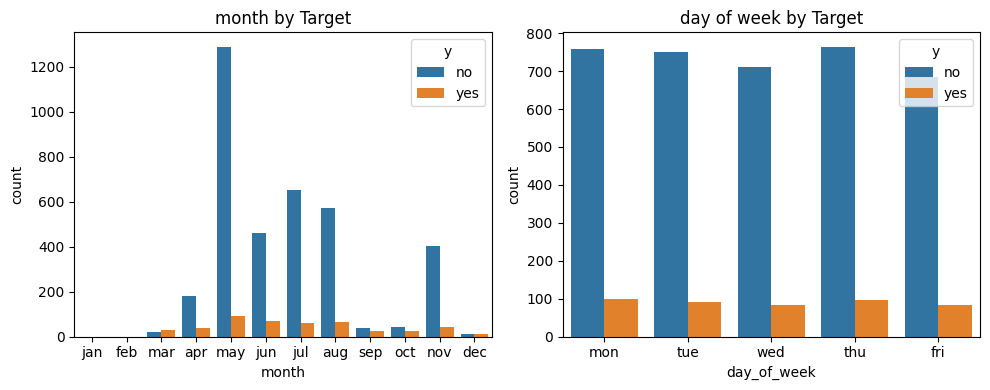

In [21]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)

sns.countplot(x='month', hue='y', data=df)
plt.title('month by Target')

plt.subplot(1, 2, 2)
sns.countplot(x='day_of_week', hue='y', data=df)
plt.title('day of week by Target')

plt.tight_layout()
plt.show()

In [22]:
df_agg = df.groupby(['month', 'day_of_week', 'y']).size().reset_index(name='count')
df_agg.head()

month day_of_week    y  count
0   jan         mon   no      0
1   jan         mon  yes      0
2   jan         tue   no      0
3   jan         tue  yes      0
4   jan         wed   no      0

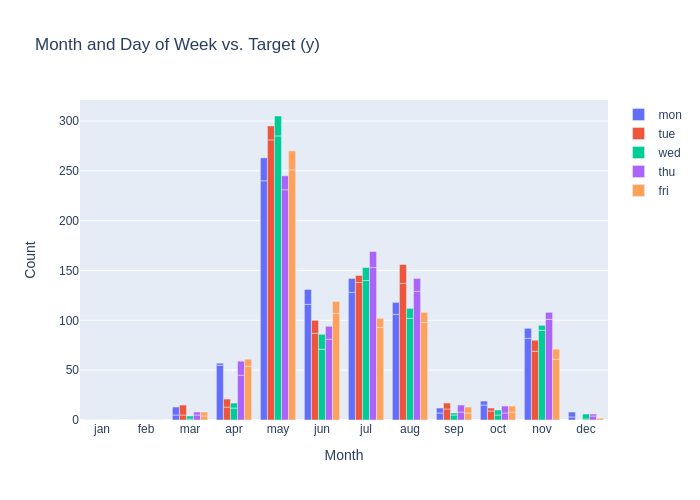

In [23]:
fig = go.Figure()

for day in df_agg['day_of_week'].unique():
    data = df_agg[df_agg['day_of_week'] == day]
    fig.add_trace(go.Bar(x=data['month'], y=data['count'], name=day))

fig.update_layout(
    barmode='group',
    xaxis=dict(title='Month'),
    yaxis=dict(title='Count'),
    title=' Month and Day of Week vs. Target (y)'
)

fig.show()
print()
fig.show('png') # wersja do zapisania w GitHub

Duration column

In [24]:
print(df.groupby('y')['duration'].describe())

      count       mean         std   min    25%    50%    75%     max
y                                                                    
no   3668.0  219.40976  198.256347   0.0   96.0  165.0  274.0  3253.0
yes   451.0  560.78714  411.537717  63.0  255.5  458.0  761.0  3643.0


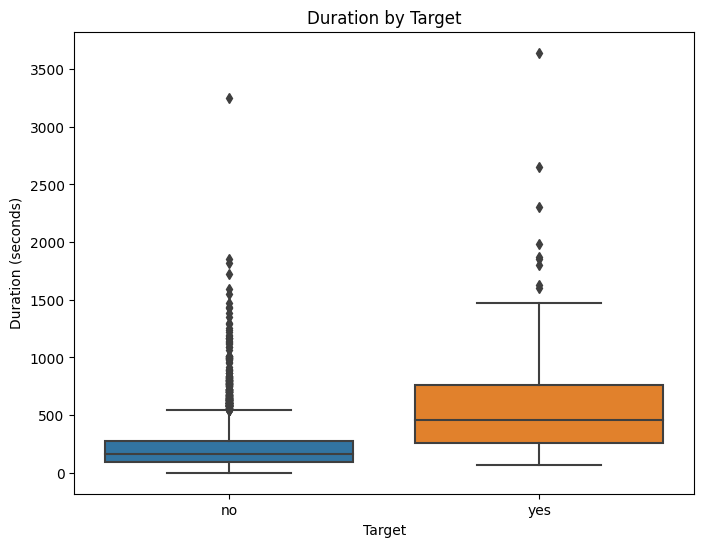

In [25]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='y', y='duration', data=df)
plt.title('Duration by Target')
plt.xlabel('Target')
plt.ylabel('Duration (seconds)')
plt.show()

In [26]:
from scipy import stats

duration_yes = df[df['y'] == 'yes']['duration']
duration_no = df[df['y'] == 'no']['duration']
t_stat, p_value = stats.ttest_ind(duration_yes, duration_no)

print(f'T-test statistic: {t_stat}')
print(f'P-value: {p_value}')

alpha = 0.05
print("There is a significant difference between 'yes' and ' no' groups.") if p_value < alpha else print("There is no significant difference between 'yes' and 'no' groups.")

T-test statistic: 29.57185726364515
P-value: 1.902622447564083e-174
There is a significant difference between 'yes' and ' no' groups.


In [27]:
num_bins = 15

df['duration_category'] = pd.qcut(df['duration'], q=num_bins, labels=False)

Campaign column

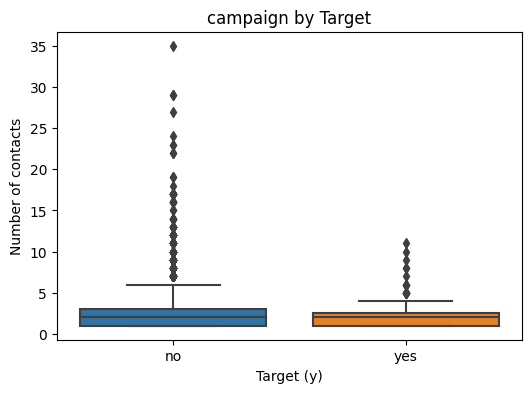

In [28]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='y', y='campaign', data=df)
plt.title(f'campaign by Target')
plt.xlabel('Target (y)')
plt.ylabel('Number of contacts')
plt.show()

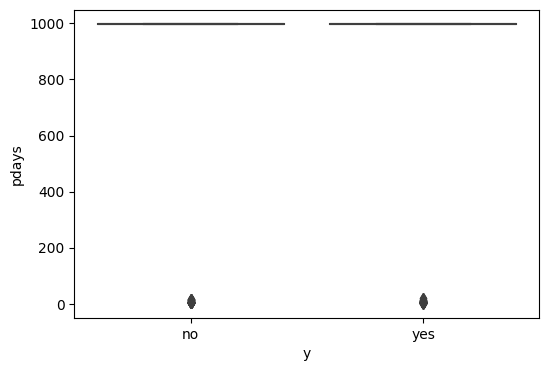

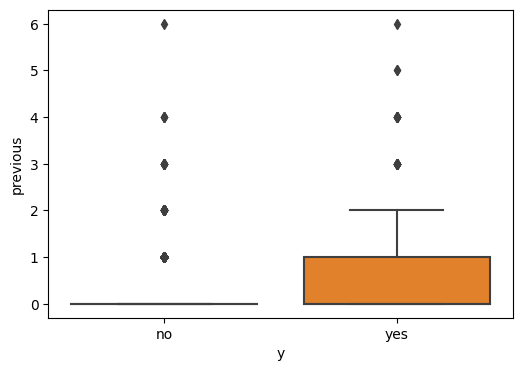

In [29]:
num_feat_01 = ['pdays', 'previous']

for f in num_feat_01:
  plt.figure(figsize=(6, 4))
  sns.boxplot(x=df['y'], y=df[f])
  plt.show()

In [30]:
df.month.value_counts()

may    1378
jul     711
aug     636
jun     530
nov     446
apr     215
oct      69
sep      64
mar      48
dec      22
jan       0
feb       0
Name: month, dtype: int64

In [31]:
df['y_numeric'] = df['y'].map({'yes': 1, 'no': 0}).astype('int')
df['month_numeric'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov':11, 'dec': 12 }).astype('int')

## Pairplot - financial coeff

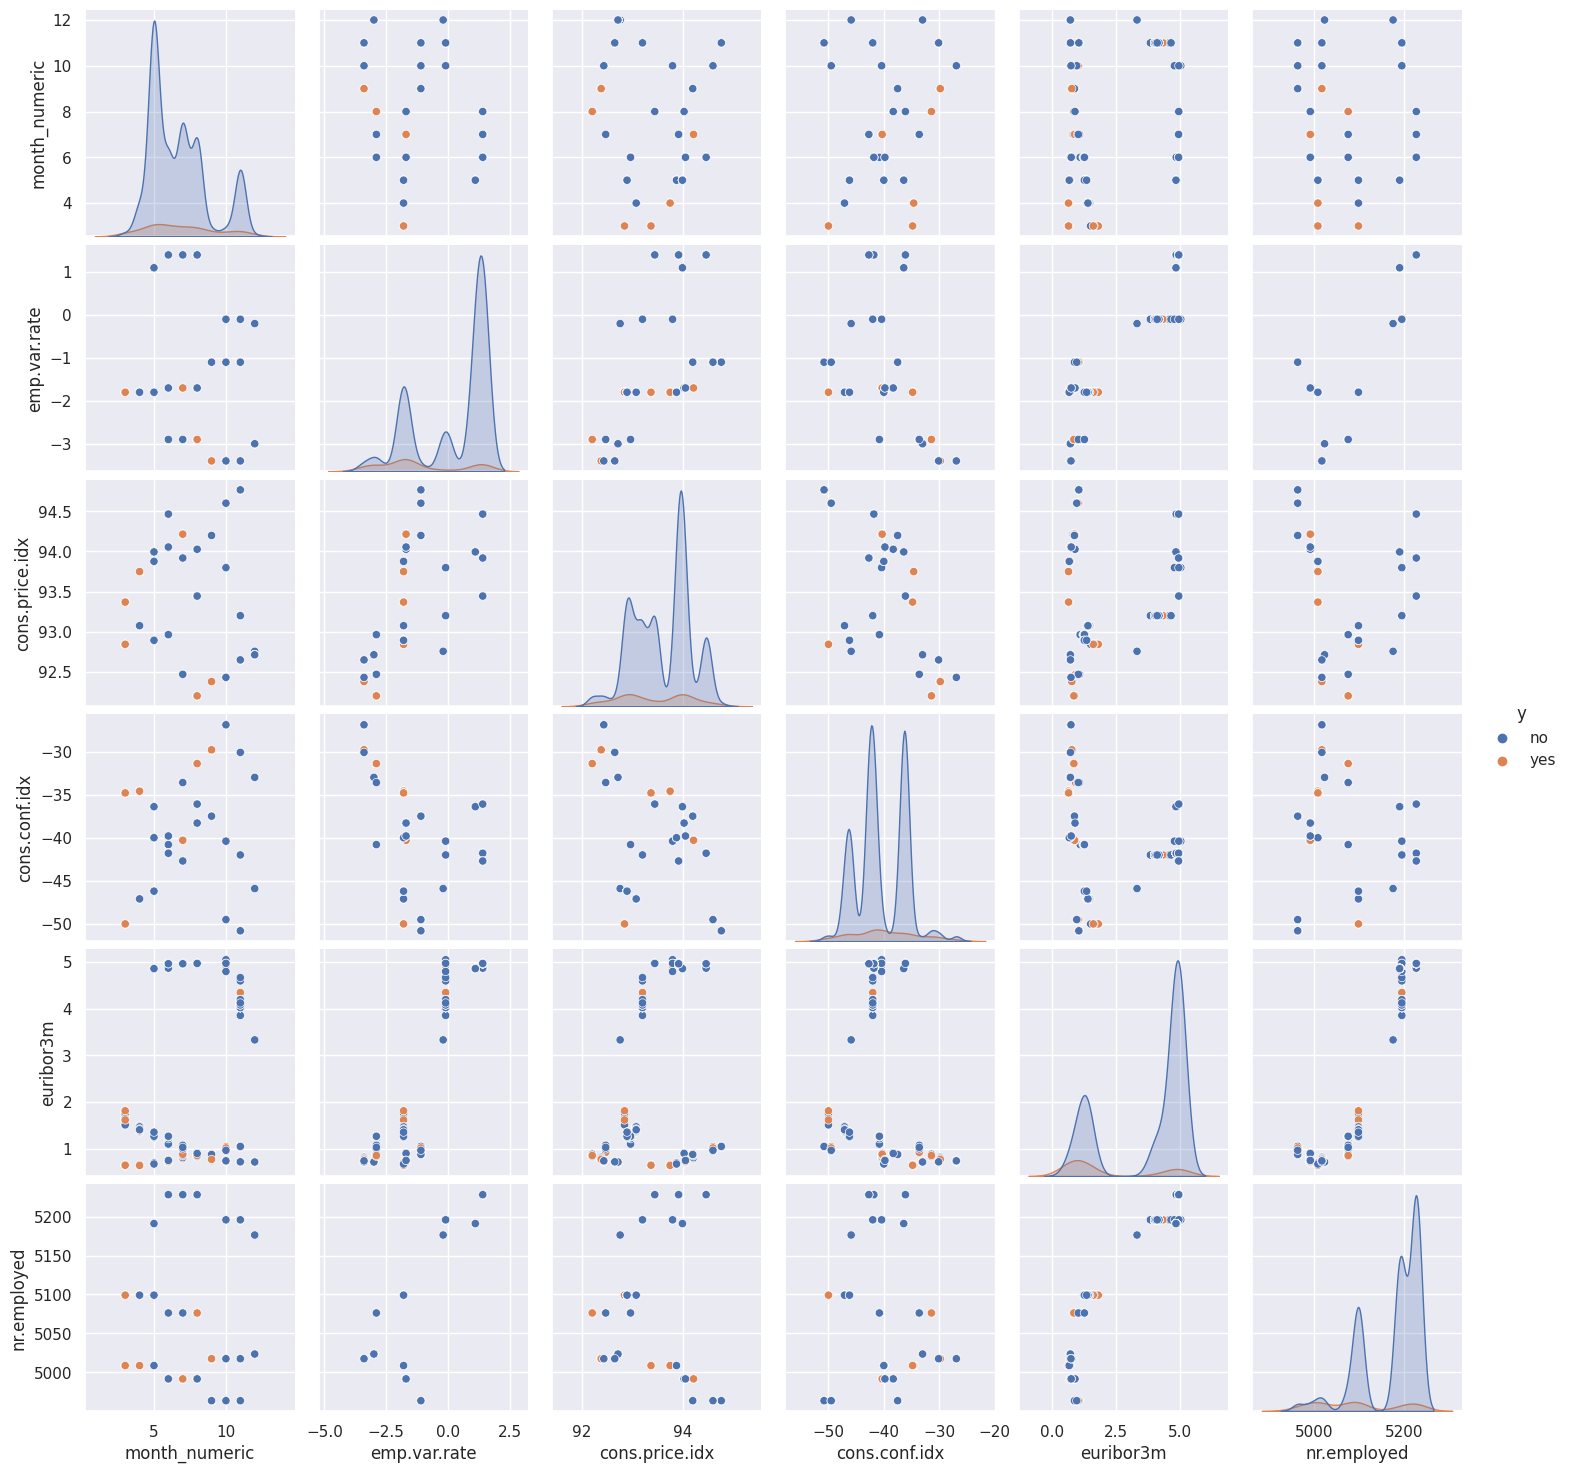

In [32]:
sns.set(rc={"figure.figsize":(32, 12)})

data_coeffs = ['month_numeric', 'emp.var.rate', 'cons.price.idx',  'cons.conf.idx', 'euribor3m', 'nr.employed', 'y']

sns.pairplot(df[data_coeffs], hue="y")

plt.show()

## Relacje pomiędzy zmiennymi w Data Frame

### Wartości numeryczne między sobą

In [33]:
numerical_features=[col for col in df.select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']
print(numerical_features)
print(len(numerical_features))
print(type(numerical_features))

['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'duration_category', 'month_numeric']
12
<class 'list'>


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5]),
 [Text(0.5, 0, 'age'),
  Text(1.5, 0, 'duration'),
  Text(2.5, 0, 'campaign'),
  Text(3.5, 0, 'pdays'),
  Text(4.5, 0, 'previous'),
  Text(5.5, 0, 'emp.var.rate'),
  Text(6.5, 0, 'cons.price.idx'),
  Text(7.5, 0, 'cons.conf.idx'),
  Text(8.5, 0, 'euribor3m'),
  Text(9.5, 0, 'nr.employed'),
  Text(10.5, 0, 'duration_category'),
  Text(11.5, 0, 'month_numeric')])

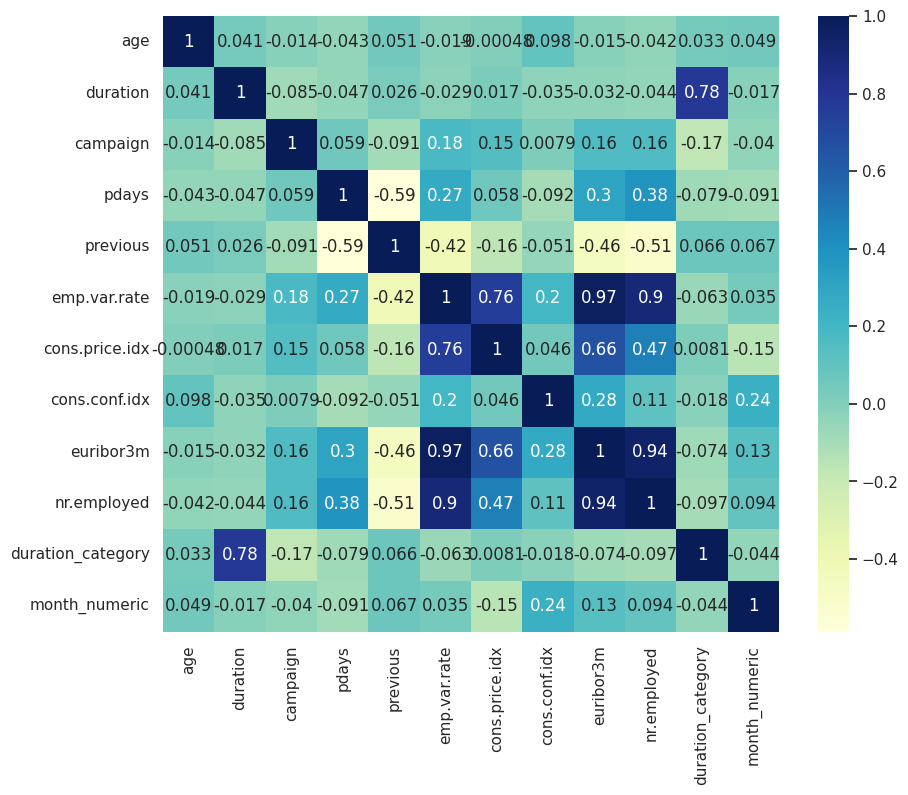

In [34]:
correlations=df[numerical_features].corr()
plt.figure(figsize=(10,8))

sns.heatmap(data=correlations,square=True,annot = True, cmap="YlGnBu")

plt.yticks(rotation=0)
plt.xticks(rotation=90)

In [35]:
# Calculate and display PPS scores for all pairs of numeric variables
for var1 in numerical_features:
    for var2 in numerical_features:
        if var1 != var2:
            pps_score = pps.score(df, var1, var2)['ppscore']
            print(f'PPS Score between {var1} and {var2}: {pps_score:.2f}')

PPS Score between age and duration: 0.00
PPS Score between age and campaign: 0.00
PPS Score between age and pdays: 0.00
PPS Score between age and previous: 0.00
PPS Score between age and emp.var.rate: 0.00
PPS Score between age and cons.price.idx: 0.00
PPS Score between age and cons.conf.idx: 0.00
PPS Score between age and euribor3m: 0.00
PPS Score between age and nr.employed: 0.00
PPS Score between age and duration_category: 0.00
PPS Score between age and month_numeric: 0.00
PPS Score between duration and age: 0.00
PPS Score between duration and campaign: 0.00
PPS Score between duration and pdays: 0.00
PPS Score between duration and previous: 0.00
PPS Score between duration and emp.var.rate: 0.00
PPS Score between duration and cons.price.idx: 0.00
PPS Score between duration and cons.conf.idx: 0.00
PPS Score between duration and euribor3m: 0.00
PPS Score between duration and nr.employed: 0.00
PPS Score between duration and duration_category: 1.00
PPS Score between duration and month_nu

### Wartości numeryczne vs target column

In [36]:
df_copy = df.copy()

In [37]:
df_copy.head()

age          job  marital          education default housing loan  \
0   30  blue-collar  married           basic.9y      no     yes   no   
1   39     services   single        high.school      no      no   no   
2   25     services  married        high.school      no     yes   no   
3   38     services  married           basic.9y      no     NaN  NaN   
4   47       admin.  married  university.degree      no     yes   no   

     contact month day_of_week  duration  campaign  pdays  previous  \
0   cellular   may         fri       487         2    999         0   
1  telephone   may         fri       346         4    999         0   
2  telephone   jun         wed       227         1    999         0   
3  telephone   jun         fri        17         3    999         0   
4   cellular   nov         mon        58         1    999         0   

      poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0  nonexistent          -1.8          92.893          -46.2      1.313   
1  nonexistent           1.1          93.994          -36.4      4.855   
2  nonexistent           1.4          94.465          -41.8      4.962   
3  nonexistent           1.4          94.465          -41.8      4.959   
4  nonexistent          -0.1          93.200          -42.0      4.191   

   nr.employed   y  duration_category  y_numeric  month_numeric  
0       5099.1  no                 13          0              5  
1       5191.0  no                 11          0              5  
2       5228.1  no                  9          0              6  
3       5228.1  no                  0          0              6  
4       5195.8  no                  1          0             11

In [38]:
y_numeric = df_copy.pop('y_numeric')

In [39]:
X = df_copy
X.head()

age          job  marital          education default housing loan  \
0   30  blue-collar  married           basic.9y      no     yes   no   
1   39     services   single        high.school      no      no   no   
2   25     services  married        high.school      no     yes   no   
3   38     services  married           basic.9y      no     NaN  NaN   
4   47       admin.  married  university.degree      no     yes   no   

     contact month day_of_week  duration  campaign  pdays  previous  \
0   cellular   may         fri       487         2    999         0   
1  telephone   may         fri       346         4    999         0   
2  telephone   jun         wed       227         1    999         0   
3  telephone   jun         fri        17         3    999         0   
4   cellular   nov         mon        58         1    999         0   

      poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0  nonexistent          -1.8          92.893          -46.2      1.313   
1  nonexistent           1.1          93.994          -36.4      4.855   
2  nonexistent           1.4          94.465          -41.8      4.962   
3  nonexistent           1.4          94.465          -41.8      4.959   
4  nonexistent          -0.1          93.200          -42.0      4.191   

   nr.employed   y  duration_category  month_numeric  
0       5099.1  no                 13              5  
1       5191.0  no                 11              5  
2       5228.1  no                  9              6  
3       5228.1  no                  0              6  
4       5195.8  no                  1             11

In [40]:
X[numerical_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                4119 non-null   int64  
 1   duration           4119 non-null   int64  
 2   campaign           4119 non-null   int64  
 3   pdays              4119 non-null   int64  
 4   previous           4119 non-null   int64  
 5   emp.var.rate       4119 non-null   float64
 6   cons.price.idx     4119 non-null   float64
 7   cons.conf.idx      4119 non-null   float64
 8   euribor3m          4119 non-null   float64
 9   nr.employed        4119 non-null   float64
 10  duration_category  4119 non-null   int64  
 11  month_numeric      4119 non-null   int64  
dtypes: float64(5), int64(7)
memory usage: 386.3 KB


In [41]:
y_numeric.info()

<class 'pandas.core.series.Series'>
RangeIndex: 4119 entries, 0 to 4118
Series name: y_numeric
Non-Null Count  Dtype
--------------  -----
4119 non-null   int64
dtypes: int64(1)
memory usage: 32.3 KB


In [42]:
# sprawdzenie korelacji między zmiennymi numerycznymi a targetem ('y_numeric')
for f in numerical_features:
  print(f'\nFeature: {f}')
  print(stats.pointbiserialr(X[f], y_numeric))


Feature: age
SignificanceResult(statistic=0.060374082506977636, pvalue=0.00010569353749626029)

Feature: duration
SignificanceResult(statistic=0.4185653682346244, pvalue=1.9026224475643572e-174)

Feature: campaign
SignificanceResult(statistic=-0.07609088294850745, pvalue=1.0131007149573394e-06)

Feature: pdays
SignificanceResult(statistic=-0.3320115339486591, pvalue=1.442855865352259e-106)

Feature: previous
SignificanceResult(statistic=0.25569662959028744, pvalue=1.725690840999725e-62)

Feature: emp.var.rate
SignificanceResult(statistic=-0.2832156765328247, pvalue=7.822982265332988e-77)

Feature: cons.price.idx
SignificanceResult(statistic=-0.09832603241628189, pvalue=2.5500558703296847e-10)

Feature: cons.conf.idx
SignificanceResult(statistic=0.05439301829399087, pvalue=0.0004786306153979258)

Feature: euribor3m
SignificanceResult(statistic=-0.2985649713595469, pvalue=1.4082264365897354e-85)

Feature: nr.employed
SignificanceResult(statistic=-0.3492412340486664, pvalue=1.84212732949

Zgodnie z informacją w danych - korelacja międzu duration - oraz przetworzoną jej formą duration_category mają dużą korleacją pozytywną ze y - z wuagi na specyfikę zmiennje, będzie później usunięta

## Wizualizacja danych kategorycznych

In [43]:
categorical_features = [col for col in df.select_dtypes(include=['object', 'category']).columns if col != 'y']
print(categorical_features)
print(len(categorical_features))
print(type(categorical_features))

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
10
<class 'list'>


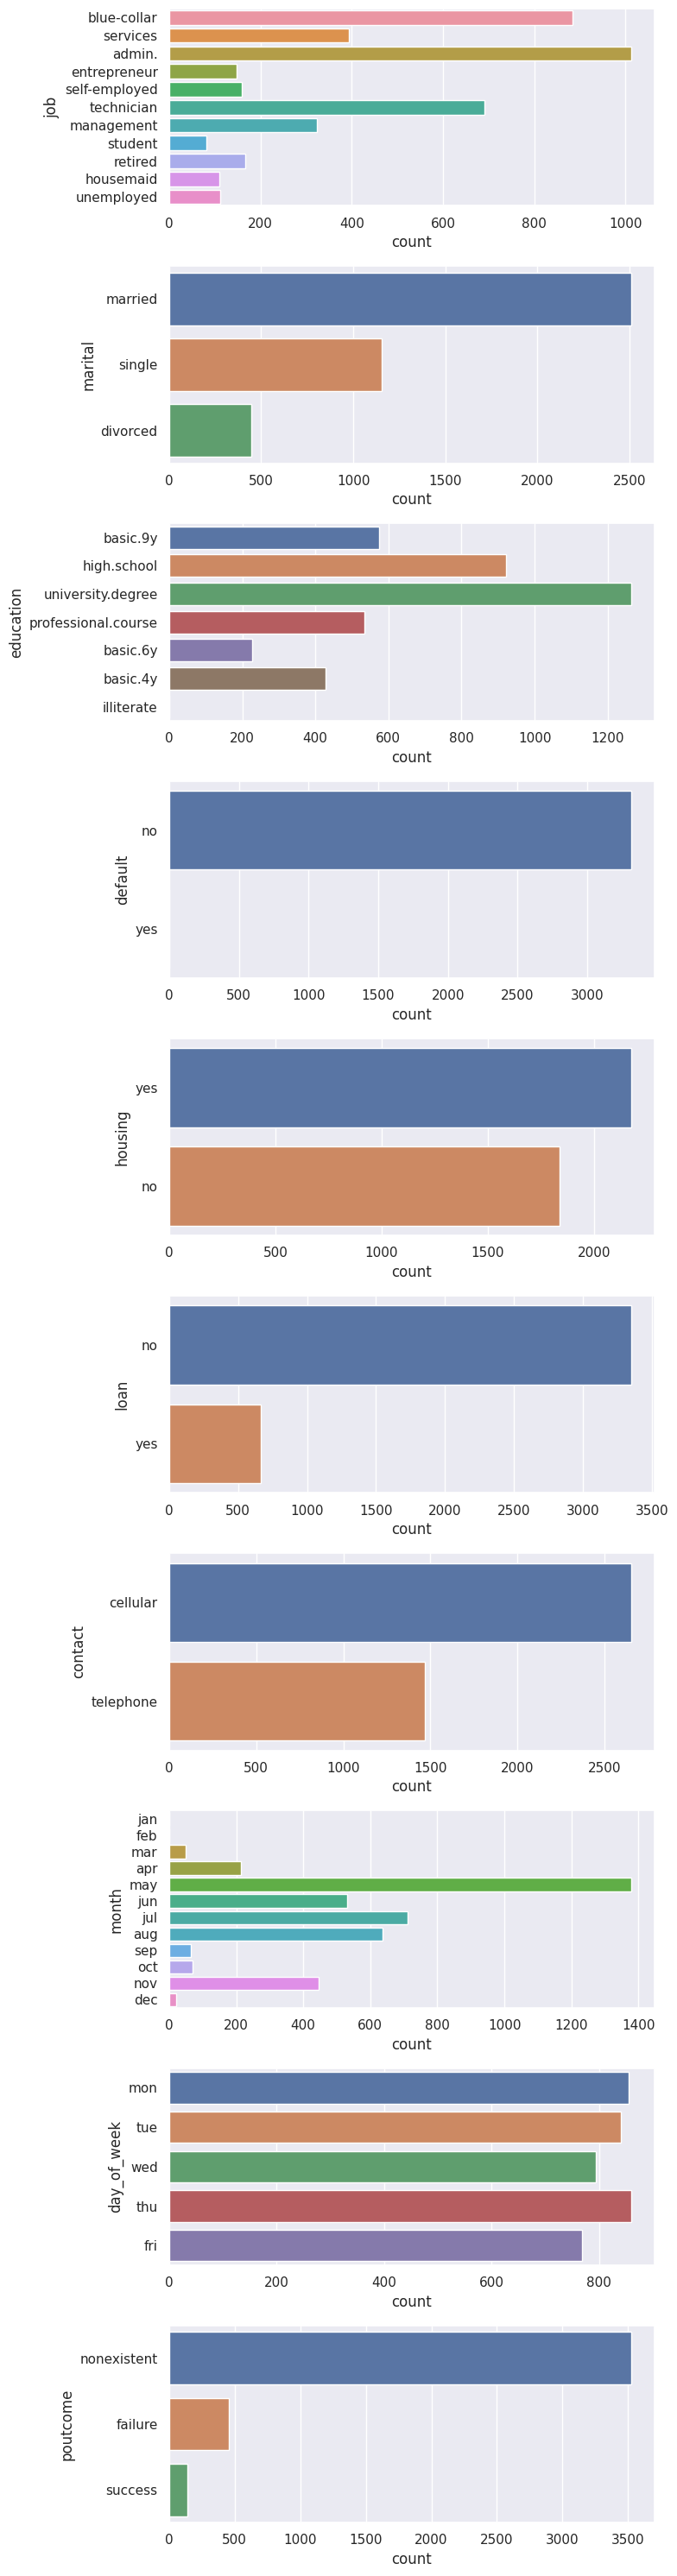

In [44]:
plt.figure(figsize=(8, 30), facecolor='white')

rows = len(categorical_features)
cols = 1

for i, categorical_feature in enumerate(categorical_features, start=1):
    ax = plt.subplot(rows, cols, i)
    sns.countplot(y=categorical_feature, data=df)

plt.tight_layout()

plt.show()

### Sprawdzenie relacji między zmiennymi kategorycznymi oraz targetem za pomconą Information gain w decision tree

In [45]:
target_col = 'y'
target = df[target_col]

df_cat_feat = df[categorical_features]

df_encoded = pd.get_dummies(df_cat_feat, columns=categorical_features, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(df_encoded, target, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(criterion='entropy')  # Information Gain criterion
clf.fit(X_train, y_train)

# Get feature importances (information gain)
feature_importance = clf.feature_importances_

# Create a dictionary mapping features to their importance
feature_importance_dict = dict(zip(df_encoded.columns, feature_importance))

# Sort the feature-importance dictionary by information gain
sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True))

# Print the sorted feature-importance pairs
for feature, info_gain in sorted_feature_importance.items():
    print(f"Feature: {feature}, Information Gain: {info_gain:.4f}")

Feature: poutcome_success, Information Gain: 0.1044
Feature: housing_yes, Information Gain: 0.0686
Feature: loan_yes, Information Gain: 0.0597
Feature: day_of_week_wed, Information Gain: 0.0525
Feature: day_of_week_thu, Information Gain: 0.0429
Feature: day_of_week_tue, Information Gain: 0.0412
Feature: job_technician, Information Gain: 0.0396
Feature: day_of_week_fri, Information Gain: 0.0342
Feature: job_management, Information Gain: 0.0341
Feature: marital_single, Information Gain: 0.0339
Feature: month_may, Information Gain: 0.0332
Feature: marital_married, Information Gain: 0.0323
Feature: month_jun, Information Gain: 0.0298
Feature: education_university.degree, Information Gain: 0.0278
Feature: education_high.school, Information Gain: 0.0278
Feature: contact_telephone, Information Gain: 0.0276
Feature: poutcome_nonexistent, Information Gain: 0.0265
Feature: month_jul, Information Gain: 0.0242
Feature: month_aug, Information Gain: 0.0241
Feature: month_nov, Information Gain: 0.023

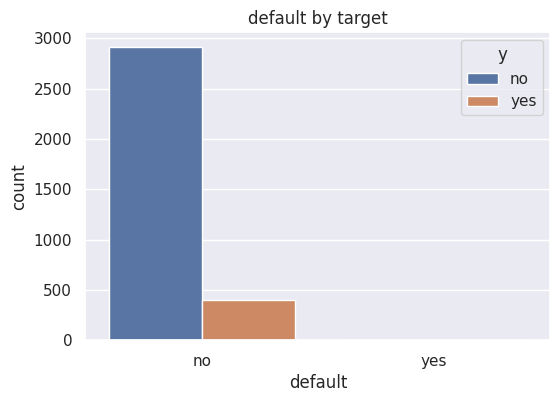

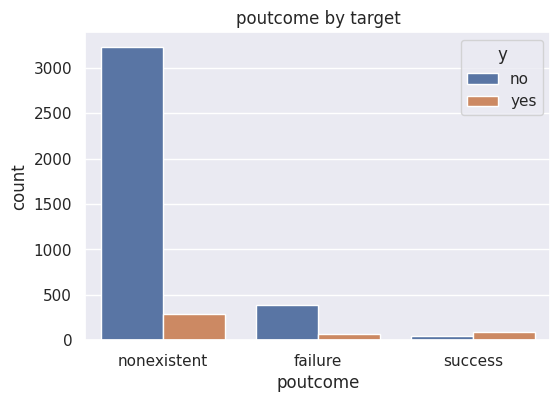

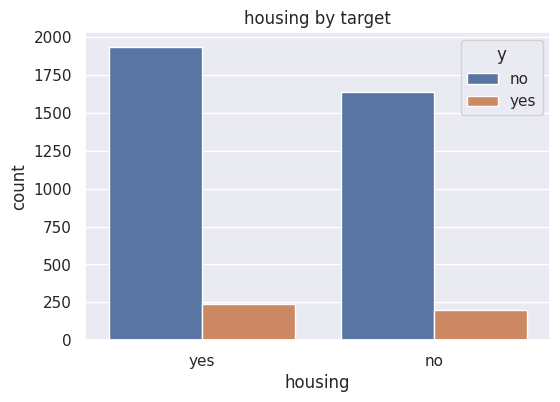

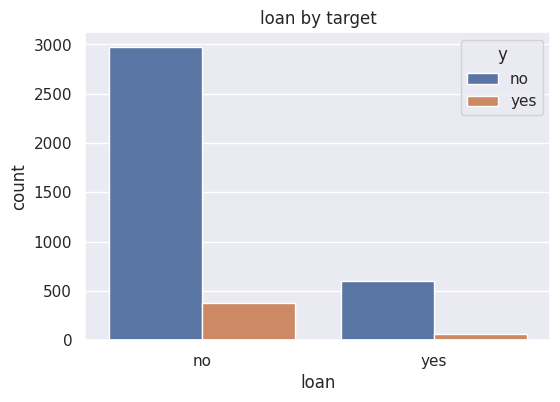

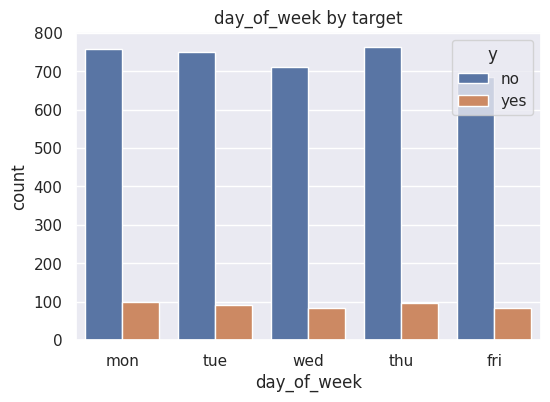

In [46]:
cat_features_vis = ['default', 'poutcome', 'housing', 'loan', 'day_of_week']

for f in cat_features_vis:
  plt.figure(figsize=(6, 4), facecolor='white')
  sns.countplot(x=f, hue='y', data=df)
  print()
  plt.title(f'{f} by target')

## Analiza współczynników społecznych / ekonomicznych emp.var.rate', 'cons.price.idx',  'cons.conf.idx', 'euribor3m', 'nr.employed' - dodanie zmiennej year

zmiana wartości euribor3m i innych wspólczynników finansowych na koszyki   w celu łatiwejszej obserwacji zależności oraz wyłapania zmian w poziomach wskaźników.

In [47]:
min_value_eur = df['euribor3m'].min()
max_value_eur = df['euribor3m'].max()


bin_width = 0.5

bins = np.arange(int(min_value_eur), int(max_value_eur) + bin_width, bin_width)

bins = np.linspace(int(min_value_eur), max_value_eur, num_bins + 1)

df['euribor3m_binned'] = pd.cut(df['euribor3m'], bins=bins, labels=bins[:-1])

In [48]:
print(df['euribor3m_binned'])
print(df['euribor3m'])

0       1.009000
1       4.708667
2       4.708667
3       4.708667
4       4.036000
          ...   
4114    4.708667
4115    4.708667
4116    1.345333
4117    4.708667
4118    4.036000
Name: euribor3m_binned, Length: 4119, dtype: category
Categories (15, float64): [0.000000 < 0.336333 < 0.672667 < 1.009000 ... 3.699667 < 4.036000 < 4.372333 <
                           4.708667]
0       1.313
1       4.855
2       4.962
3       4.959
4       4.191
        ...  
4114    4.958
4115    4.959
4116    1.354
4117    4.966
4118    4.120
Name: euribor3m, Length: 4119, dtype: float64


In [49]:
len(df['euribor3m_binned'].unique())

10

In [50]:
numerical_features.append('euribor3m_binned')

In [51]:
for column in df[numerical_features]:
    unique_values = df[column].unique()
    print(f"Unique values in column {column}: {', '.join(map(str, unique_values))}")

Unique values in column age: 30, 39, 25, 38, 47, 32, 41, 31, 35, 36, 29, 27, 44, 46, 45, 50, 55, 40, 28, 34, 33, 51, 48, 20, 76, 56, 24, 58, 60, 37, 52, 42, 49, 54, 59, 57, 43, 53, 75, 82, 71, 21, 22, 23, 26, 81, 61, 67, 73, 18, 64, 74, 77, 86, 85, 63, 88, 78, 72, 68, 80, 66, 19, 62, 65, 69, 70
Unique values in column duration: 487, 346, 227, 17, 58, 128, 290, 44, 68, 170, 301, 148, 97, 211, 553, 698, 191, 59, 38, 849, 326, 222, 626, 119, 388, 479, 446, 127, 109, 113, 393, 151, 256, 42, 525, 57, 499, 84, 137, 31, 430, 126, 340, 412, 132, 79, 341, 157, 252, 263, 215, 89, 143, 40, 10, 481, 233, 204, 403, 180, 16, 447, 81, 361, 1091, 395, 432, 596, 77, 768, 96, 357, 459, 11, 264, 93, 374, 158, 95, 835, 505, 300, 390, 274, 135, 257, 268, 477, 91, 76, 103, 436, 483, 250, 259, 389, 7, 123, 92, 297, 406, 104, 854, 147, 203, 149, 144, 394, 523, 73, 197, 108, 80, 114, 122, 1161, 181, 239, 360, 314, 984, 663, 141, 706, 797, 311, 63, 111, 49, 171, 242, 279, 246, 309, 168, 153, 152, 90, 117, 640, 

In [52]:
columns_coeff = ['emp.var.rate', 'cons.price.idx',  'cons.conf.idx', 'euribor3m', 'nr.employed', 'euribor3m_binned']

value_mappings = {}

for column in df[columns_coeff]:
    unique_values = df[column].unique()
    value_mapping = {value: i + 1 for i, value in enumerate(unique_values)}
    value_mappings[column] = value_mapping

for column in df[columns_coeff]:
    new_column_name = f"{column}_updated"
    df[new_column_name] = df[column].map(value_mappings[column])

print(df)

      age          job  marital          education default housing loan  \
0      30  blue-collar  married           basic.9y      no     yes   no   
1      39     services   single        high.school      no      no   no   
2      25     services  married        high.school      no     yes   no   
3      38     services  married           basic.9y      no     NaN  NaN   
4      47       admin.  married  university.degree      no     yes   no   
...   ...          ...      ...                ...     ...     ...  ...   
4114   30       admin.  married           basic.6y      no     yes  yes   
4115   39       admin.  married        high.school      no     yes   no   
4116   27      student   single        high.school      no      no   no   
4117   58       admin.  married        high.school      no      no   no   
4118   34   management   single        high.school      no     yes   no   

        contact month day_of_week  duration  campaign  pdays  previous  \
0      cellular   may    

Przyporządkowanie roku wierszom na bazie innych danych - 'euribor3m' oraz kolumny 'month' i reszty istniejących kolumn.
analizując ich zmiany oraz poównując z wartościami rzeczywistaymi (euribor3m) - na bazie zmian we wskaźnikach można jednoznacznie określić year i month wystąpienia (nie dokładny dzień)

In [53]:
conditions = [
    (df['euribor3m'] > 2.892),
    (df['euribor3m'] > 1.05),
    (df['month_numeric'] == 12),
    ((df['month_numeric'] >= 3) & (df['month_numeric'] <= 6)),
    ((df['month_numeric'] == 7) & (df['nr.employed_updated'] == 7)), # wybieramy lipiec 2009 z wszystkich danych lipcowych
    ((df['month_numeric'] == 8) & (df['nr.employed_updated'] == 7)),
    ((df['month_numeric'] == 9) & (df['nr.employed_updated'] == 9)),
    ((df['month_numeric'] == 10) & (df['nr.employed_updated'] == 9)),
    ((df['month_numeric'] == 11) & (df['nr.employed_updated'] == 9))
]
choices = ['2008', '2009', '2009', '2010', '2009', '2009','2009', '2009', '2009']

df['year'] = pd.np.select(conditions, choices, default='2010')

In [54]:
# dtale.show(df)

### Wizualizacja dla zmiennej "y" (kolumna binarna 0/1) z rozkładem w month(cecha) i year (cecha) na 1 wykresie.

In [55]:
df.groupby(['year', 'month_numeric'])['y_numeric'].count().unstack()

month_numeric    3      4      5      6      7      8     9     10     11  \
year                                                                        
2008            NaN    NaN  758.0  431.0  667.0  528.0   NaN   6.0  386.0   
2009           25.0  201.0  597.0   75.0   14.0   75.0  25.0  43.0   36.0   
2010           23.0   14.0   23.0   24.0   30.0   33.0  39.0  20.0   24.0   

month_numeric    12  
year                 
2008            1.0  
2009           21.0  
2010            NaN

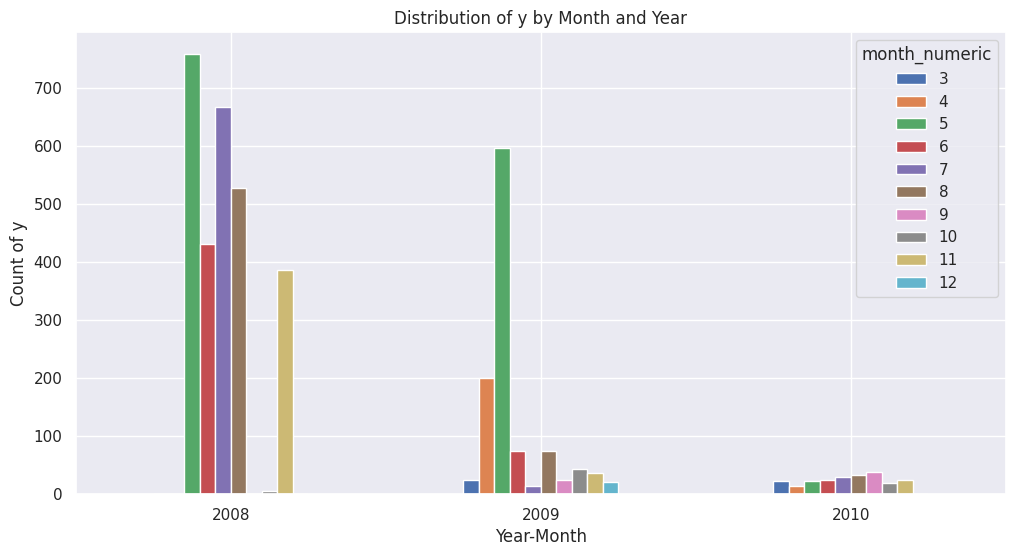

In [56]:
result = df.groupby(['year', 'month_numeric'])['y'].count().unstack(fill_value=0)

result.plot(kind='bar', figsize=(12, 6))
plt.title('Distribution of y by Month and Year')
plt.xlabel('Year-Month')
plt.ylabel('Count of y')
plt.legend(title='month_numeric')
plt.xticks(rotation=0)
plt.show()

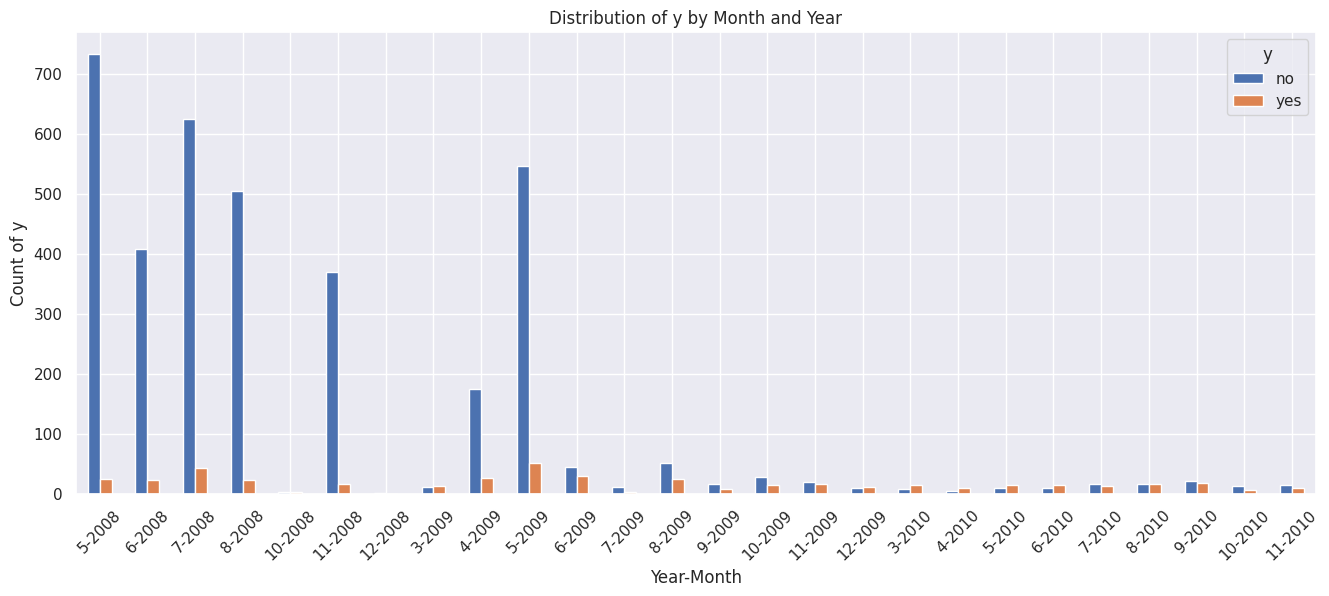

In [57]:
result = df.groupby(['year', 'month_numeric', 'y'])['y'].count().unstack(fill_value=0)

# Create a list of labels with year below each group of months
x_labels = [f"{month}-{year}" for (year, month) in result.index]

# Plot the results as a bar chart
fig, ax = plt.subplots(figsize=(16, 6))  # Extend the width of the chart
result.plot(kind='bar', ax=ax)

# Set x-axis labels (grouping months by year)
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels)

plt.title('Distribution of y by Month and Year')
plt.xlabel('Year-Month')
plt.ylabel('Count of y')
plt.legend(title='y')
plt.xticks(rotation=45)
plt.show()

In [58]:
df['month_object'] = df['month'].astype(str)

In [59]:
# łączenie kolumn month and w jedną kolumnę
df['month_year'] = df['month_object'] + '_' + df['year'].astype('str')
df['month_year'] = df['month_year'].astype('category')

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   age                       4119 non-null   int64   
 1   job                       4080 non-null   object  
 2   marital                   4108 non-null   object  
 3   education                 3952 non-null   object  
 4   default                   3316 non-null   object  
 5   housing                   4014 non-null   object  
 6   loan                      4014 non-null   object  
 7   contact                   4119 non-null   object  
 8   month                     4119 non-null   category
 9   day_of_week               4119 non-null   category
 10  duration                  4119 non-null   int64   
 11  campaign                  4119 non-null   int64   
 12  pdays                     4119 non-null   int64   
 13  previous                  4119 non-null   int64 

In [61]:
df.head()

age          job  marital          education default housing loan  \
0   30  blue-collar  married           basic.9y      no     yes   no   
1   39     services   single        high.school      no      no   no   
2   25     services  married        high.school      no     yes   no   
3   38     services  married           basic.9y      no     NaN  NaN   
4   47       admin.  married  university.degree      no     yes   no   

     contact month day_of_week  duration  campaign  pdays  previous  \
0   cellular   may         fri       487         2    999         0   
1  telephone   may         fri       346         4    999         0   
2  telephone   jun         wed       227         1    999         0   
3  telephone   jun         fri        17         3    999         0   
4   cellular   nov         mon        58         1    999         0   

      poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0  nonexistent          -1.8          92.893          -46.2      1.313   
1  nonexistent           1.1          93.994          -36.4      4.855   
2  nonexistent           1.4          94.465          -41.8      4.962   
3  nonexistent           1.4          94.465          -41.8      4.959   
4  nonexistent          -0.1          93.200          -42.0      4.191   

   nr.employed   y  duration_category  y_numeric  month_numeric  \
0       5099.1  no                 13          0              5   
1       5191.0  no                 11          0              5   
2       5228.1  no                  9          0              6   
3       5228.1  no                  0          0              6   
4       5195.8  no                  1          0             11   

  euribor3m_binned  emp.var.rate_updated  cons.price.idx_updated  \
0         1.009000                     1                       1   
1         4.708667                     2                       2   
2         4.708667                     3                       3   
3         4.708667                     3                       3   
4         4.036000                     4                       4   

   cons.conf.idx_updated  euribor3m_updated  nr.employed_updated  \
0                      1                  1                    1   
1                      2                  2                    2   
2                      3                  3                    3   
3                      3                  4                    3   
4                      4                  5                    4   

   euribor3m_binned_updated  year month_object month_year  
0                       1.0  2009          may   may_2009  
1                       2.0  2008          may   may_2008  
2                       2.0  2008          jun   jun_2008  
3                       2.0  2008          jun   jun_2008  
4                       3.0  2008          nov   nov_2008

# Data Preprocessing

## Wartości null

Łącznie mamy 1029 wierszy z wartościami null (niektóre w kilku kolumnach)
Dla 5 kolumn kategorycznych  wartości nulls są zdecydowaną mniejszością (od 1% od 4% wierszy) - dla nich uzupełnię nulle wartością zmiennej najczęście spotykaną.
Dla Kolumny 'default' aż 803 rekordy (19%) stanowią wartości null - będzie później usunięta.

In [62]:
df['job'].fillna(df['job'].mode()[0], inplace=True)
df['marital'].fillna(df['marital'].mode()[0], inplace=True)
df['education'].fillna(df['education'].mode()[0], inplace=True)
df['housing'].fillna(df['housing'].mode()[0], inplace=True)
df['loan'].fillna(df['loan'].mode()[0], inplace=True)

In [63]:
df.isnull().sum()

age                           0
job                           0
marital                       0
education                     0
default                     803
housing                       0
loan                          0
contact                       0
month                         0
day_of_week                   0
duration                      0
campaign                      0
pdays                         0
previous                      0
poutcome                      0
emp.var.rate                  0
cons.price.idx                0
cons.conf.idx                 0
euribor3m                     0
nr.employed                   0
y                             0
duration_category             0
y_numeric                     0
month_numeric                 0
euribor3m_binned              0
emp.var.rate_updated          0
cons.price.idx_updated        0
cons.conf.idx_updated         0
euribor3m_updated             0
nr.employed_updated           0
euribor3m_binned_updated      0
year    

Strukura kolumny 'default', nie pozwala jej wziąć do modelowania - tylko 1 wartośći z kategorii 'yes', 1/5 wartości to nulls, nie zależy również od informacji w innych kolumnach

In [64]:
df['default'].value_counts()

no     3315
yes       1
Name: default, dtype: int64

In [65]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   age                       4119 non-null   int64   
 1   job                       4119 non-null   object  
 2   marital                   4119 non-null   object  
 3   education                 4119 non-null   object  
 4   default                   3316 non-null   object  
 5   housing                   4119 non-null   object  
 6   loan                      4119 non-null   object  
 7   contact                   4119 non-null   object  
 8   month                     4119 non-null   category
 9   day_of_week               4119 non-null   category
 10  duration                  4119 non-null   int64   
 11  campaign                  4119 non-null   int64   
 12  pdays                     4119 non-null   int64   
 13  previous                  4119 non-null   int64 

## Podział danych na zbiór treningowy i testowy

In [66]:
df.head()

age          job  marital          education default housing loan  \
0   30  blue-collar  married           basic.9y      no     yes   no   
1   39     services   single        high.school      no      no   no   
2   25     services  married        high.school      no     yes   no   
3   38     services  married           basic.9y      no     yes   no   
4   47       admin.  married  university.degree      no     yes   no   

     contact month day_of_week  duration  campaign  pdays  previous  \
0   cellular   may         fri       487         2    999         0   
1  telephone   may         fri       346         4    999         0   
2  telephone   jun         wed       227         1    999         0   
3  telephone   jun         fri        17         3    999         0   
4   cellular   nov         mon        58         1    999         0   

      poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0  nonexistent          -1.8          92.893          -46.2      1.313   
1  nonexistent           1.1          93.994          -36.4      4.855   
2  nonexistent           1.4          94.465          -41.8      4.962   
3  nonexistent           1.4          94.465          -41.8      4.959   
4  nonexistent          -0.1          93.200          -42.0      4.191   

   nr.employed   y  duration_category  y_numeric  month_numeric  \
0       5099.1  no                 13          0              5   
1       5191.0  no                 11          0              5   
2       5228.1  no                  9          0              6   
3       5228.1  no                  0          0              6   
4       5195.8  no                  1          0             11   

  euribor3m_binned  emp.var.rate_updated  cons.price.idx_updated  \
0         1.009000                     1                       1   
1         4.708667                     2                       2   
2         4.708667                     3                       3   
3         4.708667                     3                       3   
4         4.036000                     4                       4   

   cons.conf.idx_updated  euribor3m_updated  nr.employed_updated  \
0                      1                  1                    1   
1                      2                  2                    2   
2                      3                  3                    3   
3                      3                  4                    3   
4                      4                  5                    4   

   euribor3m_binned_updated  year month_object month_year  
0                       1.0  2009          may   may_2009  
1                       2.0  2008          may   may_2008  
2                       2.0  2008          jun   jun_2008  
3                       2.0  2008          jun   jun_2008  
4                       3.0  2008          nov   nov_2008


* w listach zapisane  zmienne do późniejszego modelowania
* zmienna duration nie moze brać udział w modelowaniu danych - długość połączenia nie jest znana przed jego wykonaniem, zatem przy liście zmiennych pomijamy zmienną 'duration'

# Zestaw danych nr 1

In [67]:
model_columns = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'pdays',
       'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
      'y_numeric']

print(len(model_columns))
print(model_columns)

19
['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'y_numeric']


In [68]:
data = df[model_columns]
y = data.pop('y_numeric')
y

0       0
1       0
2       0
3       0
4       0
       ..
4114    0
4115    0
4116    0
4117    0
4118    0
Name: y_numeric, Length: 4119, dtype: int64

In [69]:
X = data
X.head()

age          job  marital          education housing loan    contact month  \
0   30  blue-collar  married           basic.9y     yes   no   cellular   may   
1   39     services   single        high.school      no   no  telephone   may   
2   25     services  married        high.school     yes   no  telephone   jun   
3   38     services  married           basic.9y     yes   no  telephone   jun   
4   47       admin.  married  university.degree     yes   no   cellular   nov   

  day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
0         fri         2    999         0  nonexistent          -1.8   
1         fri         4    999         0  nonexistent           1.1   
2         wed         1    999         0  nonexistent           1.4   
3         fri         3    999         0  nonexistent           1.4   
4         mon         1    999         0  nonexistent          -0.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed  
0          92.893          -46.2      1.313       5099.1  
1          93.994          -36.4      4.855       5191.0  
2          94.465          -41.8      4.962       5228.1  
3          94.465          -41.8      4.959       5228.1  
4          93.200          -42.0      4.191       5195.8

In [70]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             4119 non-null   int64   
 1   job             4119 non-null   object  
 2   marital         4119 non-null   object  
 3   education       4119 non-null   object  
 4   housing         4119 non-null   object  
 5   loan            4119 non-null   object  
 6   contact         4119 non-null   object  
 7   month           4119 non-null   category
 8   day_of_week     4119 non-null   category
 9   campaign        4119 non-null   int64   
 10  pdays           4119 non-null   int64   
 11  previous        4119 non-null   int64   
 12  poutcome        4119 non-null   object  
 13  emp.var.rate    4119 non-null   float64 
 14  cons.price.idx  4119 non-null   float64 
 15  cons.conf.idx   4119 non-null   float64 
 16  euribor3m       4119 non-null   float64 
 17  nr.employed   

In [71]:
num_feat = [col for col in df[model_columns].select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']

cat_feat = [col for col in df[model_columns].select_dtypes(include=['object']).columns if col != 'y']

ord_feat = [col for col in df[model_columns].select_dtypes(include=['category']).columns if col != 'y']

print(f'No. of numerical features: {len(num_feat)}')
print(num_feat)
print()
print(f'No. of categorical features: {len(cat_feat)}')
print(cat_feat)
print()
print(f'No. of ordinal features: {len(ord_feat)}')
print(ord_feat)

No. of numerical features: 9
['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

No. of categorical features: 7
['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome']

No. of ordinal features: 2
['month', 'day_of_week']


In [72]:
seed = 23

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

In [74]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3295, 18), (3295,), (824, 18), (824,))

In [75]:
y_train.value_counts()

0    2934
1     361
Name: y_numeric, dtype: int64

In [76]:
361 / (2934+361)

0.10955993930197269

In [77]:
y_test.value_counts()

0    734
1     90
Name: y_numeric, dtype: int64

## Feature Importance - RandomForestClassifier() - Zestaw danych nr 1

In [78]:
categorical_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, cat_feat),
        ('ordinal', ordinal_transformer, ord_feat)
    ]
)

rfc_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rfc_model', RandomForestClassifier(random_state=seed))])

In [79]:
rfc_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact',
                                                   'poutcome']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('label_encoder',
                                                                   <__main__.LabelEncoderTransformer object at 0x7d388ce0a140>)]),
                                                  ['month', 'day_of_week'])])),
                ('rfc_model', RandomForestClassifier(random_state=23))])

In [80]:
feature_importance = rfc_pipeline.steps[-1][1].feature_importances_
all_column_names = X_train.columns

importance_tuples = [(col, imp) for col, imp in zip(all_column_names, feature_importance)]

# Sort the list by feature importance in descending order
rfc_pre_sorted_importance = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

# Print feature importance values for each column in descending order
print('Random Forest Feature Importance: \n')
for column, importance in rfc_pre_sorted_importance:
    print(f" {column}: {importance}")

Random Forest Feature Importance: 

 age: 0.0268677584108947
 poutcome: 0.025710206691869675
 nr.employed: 0.024363048548194467
 emp.var.rate: 0.02428816364519069
 campaign: 0.02416070739269782
 month: 0.01751885007002464
 previous: 0.01726601742629355
 housing: 0.016861064168508327
 cons.price.idx: 0.01682548211672266
 job: 0.016700213012565614
 euribor3m: 0.01509328610188216
 loan: 0.014197137471708523
 pdays: 0.01143889857022313
 day_of_week: 0.01107454530846042
 cons.conf.idx: 0.009423281621242379
 contact: 0.00886578907181938
 marital: 0.007176347141683523
 education: 0.006912994859478684


# Zestaw danych nr 2

Zestaw z nowo stworzoną zmienną month_year oraz wybranym 1 z 5 wskaźników finansowych z uwagi na ich wysoką kolerację i wspólne zależności (ppsscore)

In [81]:
model_columns_2 = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
        'emp.var.rate', 'month_year',
        'y_numeric']

print(len(model_columns_2))
print(model_columns_2)

15
['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'month_year', 'y_numeric']


In [82]:
data_2 = df[model_columns_2]

In [83]:
y_2 = data_2.pop('y_numeric')
y_2

0       0
1       0
2       0
3       0
4       0
       ..
4114    0
4115    0
4116    0
4117    0
4118    0
Name: y_numeric, Length: 4119, dtype: int64

In [84]:
X_2 = data_2
X_2.head()

age          job  marital          education housing loan    contact  \
0   30  blue-collar  married           basic.9y     yes   no   cellular   
1   39     services   single        high.school      no   no  telephone   
2   25     services  married        high.school     yes   no  telephone   
3   38     services  married           basic.9y     yes   no  telephone   
4   47       admin.  married  university.degree     yes   no   cellular   

  day_of_week  campaign  pdays  previous     poutcome  emp.var.rate month_year  
0         fri         2    999         0  nonexistent          -1.8   may_2009  
1         fri         4    999         0  nonexistent           1.1   may_2008  
2         wed         1    999         0  nonexistent           1.4   jun_2008  
3         fri         3    999         0  nonexistent           1.4   jun_2008  
4         mon         1    999         0  nonexistent          -0.1   nov_2008

In [85]:
num_feat_2 = [col for col in df[model_columns_2].select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']
cat_feat_2 = [col for col in df[model_columns_2].select_dtypes(include=['object']).columns if col != 'y']
ord_feat_2 = [col for col in df[model_columns_2].select_dtypes(include=['category']).columns if col != 'y']
print(f'No. of numerical features: {len(num_feat_2)}')
print(num_feat_2)
print()
print(f'No. of categorical features: {len(cat_feat_2)}')
print(cat_feat_2)
print()
print(f'No. of ordinal features: {len(ord_feat_2)}')
print(ord_feat_2)

No. of numerical features: 5
['age', 'campaign', 'pdays', 'previous', 'emp.var.rate']

No. of categorical features: 7
['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome']

No. of ordinal features: 2
['day_of_week', 'month_year']


In [86]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=seed, stratify=y)

In [87]:
X_train_2.shape, y_train_2.shape, X_test_2.shape, y_test_2.shape

((3295, 14), (3295,), (824, 14), (824,))

In [88]:
y_train_2.value_counts()

0    2934
1     361
Name: y_numeric, dtype: int64

In [89]:
y_test_2.value_counts()

0    734
1     90
Name: y_numeric, dtype: int64

## Feature Importance - RandomForestClassifier() - Zestaw danych nr 2

In [90]:
categorical_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, cat_feat_2),
        ('ordinal', ordinal_transformer, ord_feat_2)
    ]
)

rfc_pipeline_2 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rfc_model_2', RandomForestClassifier(random_state=seed))])

In [91]:
rfc_pipeline_2.fit(X_train_2, y_train_2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact',
                                                   'poutcome']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('label_encoder',
                                                                   <__main__.LabelEncoderTransformer object at 0x7d387fdbfca0>)]),
                                                  ['day_of_week',
                                                   'month_year'])])),
                ('rfc_model_2', RandomForestClassifier(random_state=23))])

In [92]:
feature_importance = rfc_pipeline_2.steps[-1][1].feature_importances_
all_column_names = X_train_2.columns

importance_tuples = [(col, imp) for col, imp in zip(all_column_names, feature_importance)]

# Sort the list by feature importance in descending order
rfc_pre_sorted_importance = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

# Print feature importance values for each column in descending order
print('Random Forest Feature Importance - zestaw danych 2: \n')
for column, importance in rfc_pre_sorted_importance:
    print(f" {column}: {importance}")

Random Forest Feature Importance - zestaw danych 2: 

 age: 0.02591324001424403
 pdays: 0.02250008347873538
 emp.var.rate: 0.022331282777275828
 month_year: 0.0216472729054858
 day_of_week: 0.015419510063230417
 poutcome: 0.015312653130634067
 job: 0.015078911783612783
 housing: 0.015031408708265508
 loan: 0.013982861894174145
 previous: 0.010637547511346697
 campaign: 0.009908147031313225
 contact: 0.007912279402230486
 marital: 0.0066016848640053985
 education: 0.006427581316993075


# Zestaw danych 3

-  pozostawiono 2 zmienne społeczono - ekonomiczne wybrane ze względu na ich istotność (oraz niższy niż inne skorelowanie)

In [93]:
df.head()

age          job  marital          education default housing loan  \
0   30  blue-collar  married           basic.9y      no     yes   no   
1   39     services   single        high.school      no      no   no   
2   25     services  married        high.school      no     yes   no   
3   38     services  married           basic.9y      no     yes   no   
4   47       admin.  married  university.degree      no     yes   no   

     contact month day_of_week  duration  campaign  pdays  previous  \
0   cellular   may         fri       487         2    999         0   
1  telephone   may         fri       346         4    999         0   
2  telephone   jun         wed       227         1    999         0   
3  telephone   jun         fri        17         3    999         0   
4   cellular   nov         mon        58         1    999         0   

      poutcome  emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
0  nonexistent          -1.8          92.893          -46.2      1.313   
1  nonexistent           1.1          93.994          -36.4      4.855   
2  nonexistent           1.4          94.465          -41.8      4.962   
3  nonexistent           1.4          94.465          -41.8      4.959   
4  nonexistent          -0.1          93.200          -42.0      4.191   

   nr.employed   y  duration_category  y_numeric  month_numeric  \
0       5099.1  no                 13          0              5   
1       5191.0  no                 11          0              5   
2       5228.1  no                  9          0              6   
3       5228.1  no                  0          0              6   
4       5195.8  no                  1          0             11   

  euribor3m_binned  emp.var.rate_updated  cons.price.idx_updated  \
0         1.009000                     1                       1   
1         4.708667                     2                       2   
2         4.708667                     3                       3   
3         4.708667                     3                       3   
4         4.036000                     4                       4   

   cons.conf.idx_updated  euribor3m_updated  nr.employed_updated  \
0                      1                  1                    1   
1                      2                  2                    2   
2                      3                  3                    3   
3                      3                  4                    3   
4                      4                  5                    4   

   euribor3m_binned_updated  year month_object month_year  
0                       1.0  2009          may   may_2009  
1                       2.0  2008          may   may_2008  
2                       2.0  2008          jun   jun_2008  
3                       2.0  2008          jun   jun_2008  
4                       3.0  2008          nov   nov_2008

In [94]:
model_columns_3 = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
        'month', 'cons.conf.idx', 'emp.var.rate',
        'y_numeric']

print(len(model_columns_3))
print(model_columns_3)

16
['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'month', 'cons.conf.idx', 'emp.var.rate', 'y_numeric']


In [95]:
data_3 = df[model_columns_3]

y_3 = data_3.pop('y_numeric')
y_3

0       0
1       0
2       0
3       0
4       0
       ..
4114    0
4115    0
4116    0
4117    0
4118    0
Name: y_numeric, Length: 4119, dtype: int64

In [96]:
X_3 = data_3
X_3.head()

age          job  marital          education housing loan    contact  \
0   30  blue-collar  married           basic.9y     yes   no   cellular   
1   39     services   single        high.school      no   no  telephone   
2   25     services  married        high.school     yes   no  telephone   
3   38     services  married           basic.9y     yes   no  telephone   
4   47       admin.  married  university.degree     yes   no   cellular   

  day_of_week  campaign  pdays  previous     poutcome month  cons.conf.idx  \
0         fri         2    999         0  nonexistent   may          -46.2   
1         fri         4    999         0  nonexistent   may          -36.4   
2         wed         1    999         0  nonexistent   jun          -41.8   
3         fri         3    999         0  nonexistent   jun          -41.8   
4         mon         1    999         0  nonexistent   nov          -42.0   

   emp.var.rate  
0          -1.8  
1           1.1  
2           1.4  
3           1.4  
4          -0.1

In [97]:
num_feat_3 = [col for col in df[model_columns_3].select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']
cat_feat_3 = [col for col in df[model_columns_3].select_dtypes(include=['object']).columns if col != 'y']
ord_feat_3 = [col for col in df[model_columns_3].select_dtypes(include=['category']).columns if col != 'y']
print(f'No. of numerical features: {len(num_feat_3)}')
print(num_feat_3)
print()
print(f'No. of categorical features: {len(cat_feat_3)}')
print(cat_feat_3)
print()
print(f'No. of ordinal features: {len(ord_feat_3)}')
print(ord_feat_3)

No. of numerical features: 6
['age', 'campaign', 'pdays', 'previous', 'cons.conf.idx', 'emp.var.rate']

No. of categorical features: 7
['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome']

No. of ordinal features: 2
['day_of_week', 'month']


In [98]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=seed, stratify=y)

X_train_3.shape, y_train_3.shape, X_test_3.shape, y_test_3.shape

((3295, 15), (3295,), (824, 15), (824,))

In [99]:
print(y_train_3.value_counts())

0    2934
1     361
Name: y_numeric, dtype: int64


In [100]:
print(y_test_3.value_counts())

0    734
1     90
Name: y_numeric, dtype: int64


## Feature Importance - RandomForestClassifier() - Zestaw danych nr 3

In [101]:
categorical_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, cat_feat_3),
        ('ordinal', ordinal_transformer, ord_feat_3)
    ]
)

rfc_pipeline_3 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rfc_model_3', RandomForestClassifier(random_state=seed))])

In [102]:
rfc_pipeline_3.fit(X_train_3, y_train_3)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact',
                                                   'poutcome']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('label_encoder',
                                                                   <__main__.LabelEncoderTransformer object at 0x7d387fcf6590>)]),
                                                  ['day_of_week', 'month'])])),
                ('rfc_model_3', RandomForestClassifier(random_state=23))])

In [103]:
feature_importance = rfc_pipeline_3.steps[-1][1].feature_importances_
all_column_names = X_train_3.columns

importance_tuples = [(col, imp) for col, imp in zip(all_column_names, feature_importance)]

# Sort the list by feature importance in descending order
rfc_pre_sorted_importance = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

# Print feature importance values for each column in descending order
print('Random Forest Feature Importance - zestaw danych 3: \n')
for column, importance in rfc_pre_sorted_importance:
    print(f" {column}: {importance}")

Random Forest Feature Importance - zestaw danych 3: 

 age: 0.026123649498428925
 month: 0.024464120922559097
 cons.conf.idx: 0.023607166324329857
 pdays: 0.0231554581617383
 day_of_week: 0.0184142336554891
 housing: 0.016860328940924436
 poutcome: 0.01674457027654782
 job: 0.016482780768810597
 emp.var.rate: 0.01637145362741636
 loan: 0.014670891400417241
 campaign: 0.011134838766105574
 previous: 0.010459259207218184
 contact: 0.009389739970860846
 education: 0.007443469967620293
 marital: 0.00628507598971507


# Zestaw danych 4

- mix 2 i 3 zestawu - month_year zostawiony +  pozostawiono 2 zmienne społeczono - ekonomiczne wybrane ze względu na ich istotność (2, które mają najniższą korelację i wpły na siebie)

In [104]:
model_columns_4 = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'emp.var.rate', 'cons.conf.idx', 'month_year',
        'y_numeric']

In [105]:
print(len(model_columns_4))
print(model_columns_4)

16
['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.conf.idx', 'month_year', 'y_numeric']


In [106]:
data_4 = df[model_columns_4]

In [107]:
y_4 = data_4.pop('y_numeric')
y_4

0       0
1       0
2       0
3       0
4       0
       ..
4114    0
4115    0
4116    0
4117    0
4118    0
Name: y_numeric, Length: 4119, dtype: int64

In [108]:
X_4 = data_4
X_4.head()

age          job  marital          education housing loan    contact  \
0   30  blue-collar  married           basic.9y     yes   no   cellular   
1   39     services   single        high.school      no   no  telephone   
2   25     services  married        high.school     yes   no  telephone   
3   38     services  married           basic.9y     yes   no  telephone   
4   47       admin.  married  university.degree     yes   no   cellular   

  day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
0         fri         2    999         0  nonexistent          -1.8   
1         fri         4    999         0  nonexistent           1.1   
2         wed         1    999         0  nonexistent           1.4   
3         fri         3    999         0  nonexistent           1.4   
4         mon         1    999         0  nonexistent          -0.1   

   cons.conf.idx month_year  
0          -46.2   may_2009  
1          -36.4   may_2008  
2          -41.8   jun_2008  
3          -41.8   jun_2008  
4          -42.0   nov_2008

In [109]:
num_feat_4 = [col for col in df[model_columns_4].select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']
cat_feat_4 = [col for col in df[model_columns_4].select_dtypes(include=['object']).columns if col != 'y']
ord_feat_4 = [col for col in df[model_columns_4].select_dtypes(include=['category']).columns if col != 'y']
print(f'No. of numerical features: {len(num_feat_4)}')
print(num_feat_4)
print()
print(f'No. of categorical features: {len(cat_feat_4)}')
print(cat_feat_4)
print()
print(f'No. of ordinal features: {len(ord_feat_4)}')
print(ord_feat_4)

No. of numerical features: 6
['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.conf.idx']

No. of categorical features: 7
['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome']

No. of ordinal features: 2
['day_of_week', 'month_year']


In [110]:
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, test_size=0.2, random_state=seed, stratify=y)

In [111]:
X_train_4.shape, y_train_4.shape, X_test_4.shape, y_test_4.shape

((3295, 15), (3295,), (824, 15), (824,))

In [112]:
X_train_4.head()

age           job   marital            education housing loan  \
279    23  entrepreneur   married    university.degree     yes   no   
1064   47      services  divorced             basic.4y      no   no   
1037   43   blue-collar    single  professional.course      no   no   
3999   30      services    single          high.school     yes  yes   
1571   49  entrepreneur   married    university.degree     yes   no   

        contact day_of_week  campaign  pdays  previous     poutcome  \
279    cellular         thu         1    999         0  nonexistent   
1064   cellular         tue         2    999         0  nonexistent   
1037  telephone         thu         1    999         0  nonexistent   
3999   cellular         mon         1    999         0  nonexistent   
1571   cellular         mon         1    999         0  nonexistent   

      emp.var.rate  cons.conf.idx month_year  
279            1.4          -36.1   aug_2008  
1064           1.4          -42.7   jul_2008  
1037           1.4          -41.8   jun_2008  
3999          -1.8          -46.2   may_2009  
1571          -1.8          -47.1   apr_2009

In [113]:
y_train_4.value_counts()

0    2934
1     361
Name: y_numeric, dtype: int64

In [114]:
y_test_4.value_counts()

0    734
1     90
Name: y_numeric, dtype: int64

## Feature Importance - RandomForestClassifier() - Zestaw danych nr 4

In [115]:
categorical_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, cat_feat_4),
        ('ordinal', ordinal_transformer, ord_feat_4)
    ]
)

rfc_pipeline_4 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rfc_model_4', RandomForestClassifier(random_state=seed))])

In [116]:
rfc_pipeline_4.fit(X_train_4, y_train_4)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital',
                                                   'education', 'housing',
                                                   'loan', 'contact',
                                                   'poutcome']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('label_encoder',
                                                                   <__main__.LabelEncoderTransformer object at 0x7d387fb319c0>)]),
                                                  ['day_of_week',
                                                   'month_year'])])),
                ('rfc_model_4', RandomForestClassifier(random_state=23))])

In [117]:
feature_importance = rfc_pipeline_4.steps[-1][1].feature_importances_
all_column_names = X_train_4.columns

importance_tuples = [(col, imp) for col, imp in zip(all_column_names, feature_importance)]

# Sort the list by feature importance in descending order
rfc_pre_sorted_importance = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

# Print feature importance values for each column in descending order
print('Random Forest Feature Importance - zestaw danych 4: \n')
for column, importance in rfc_pre_sorted_importance:
    print(f" {column}: {importance}")

Random Forest Feature Importance - zestaw danych 4: 

 age: 0.02591324001424403
 pdays: 0.02250008347873538
 emp.var.rate: 0.022331282777275828
 cons.conf.idx: 0.0216472729054858
 day_of_week: 0.015419510063230417
 poutcome: 0.015312653130634067
 job: 0.015078911783612783
 housing: 0.015031408708265508
 month_year: 0.014659469397515312
 loan: 0.013982861894174145
 previous: 0.010637547511346697
 campaign: 0.009908147031313225
 contact: 0.007912279402230486
 marital: 0.0066016848640053985
 education: 0.006427581316993075


# Zestaw danych nr 5

In [118]:
model_columns_sampling = ['age', 'job', 'marital', 'education', 'housing', 'loan',
       'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome',
       'cons.conf.idx', 'emp.var.rate', 'month', 'year',
      'y_numeric']

print(len(model_columns_sampling))
print(model_columns_sampling)

17
['age', 'job', 'marital', 'education', 'housing', 'loan', 'contact', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'cons.conf.idx', 'emp.var.rate', 'month', 'year', 'y_numeric']


In [119]:
df_sampling = df[model_columns_sampling]
df_sampling.shape

(4119, 17)

In [120]:
y_sampling = df_sampling.pop('y_numeric')
y_sampling

0       0
1       0
2       0
3       0
4       0
       ..
4114    0
4115    0
4116    0
4117    0
4118    0
Name: y_numeric, Length: 4119, dtype: int64

In [121]:
X_sampling = df_sampling
X_sampling

age          job  marital          education housing loan    contact  \
0      30  blue-collar  married           basic.9y     yes   no   cellular   
1      39     services   single        high.school      no   no  telephone   
2      25     services  married        high.school     yes   no  telephone   
3      38     services  married           basic.9y     yes   no  telephone   
4      47       admin.  married  university.degree     yes   no   cellular   
...   ...          ...      ...                ...     ...  ...        ...   
4114   30       admin.  married           basic.6y     yes  yes   cellular   
4115   39       admin.  married        high.school     yes   no  telephone   
4116   27      student   single        high.school      no   no   cellular   
4117   58       admin.  married        high.school      no   no   cellular   
4118   34   management   single        high.school     yes   no   cellular   

     day_of_week  campaign  pdays  previous     poutcome  cons.conf.idx  \
0            fri         2    999         0  nonexistent          -46.2   
1            fri         4    999         0  nonexistent          -36.4   
2            wed         1    999         0  nonexistent          -41.8   
3            fri         3    999         0  nonexistent          -41.8   
4            mon         1    999         0  nonexistent          -42.0   
...          ...       ...    ...       ...          ...            ...   
4114         thu         1    999         0  nonexistent          -42.7   
4115         fri         1    999         0  nonexistent          -42.7   
4116         mon         2    999         1      failure          -46.2   
4117         fri         1    999         0  nonexistent          -36.1   
4118         wed         1    999         0  nonexistent          -42.0   

      emp.var.rate month  year  
0             -1.8   may  2009  
1              1.1   may  2008  
2              1.4   jun  2008  
3              1.4   jun  2008  
4             -0.1   nov  2008  
...            ...   ...   ...  
4114           1.4   jul  2008  
4115           1.4   jul  2008  
4116          -1.8   may  2009  
4117           1.4   aug  2008  
4118          -0.1   nov  2008  

[4119 rows x 16 columns]

In [122]:
X_train_sampling, X_test_sampling, y_train_sampling, y_test_sampling = train_test_split(X_sampling, y_sampling, test_size=0.3, random_state=seed, stratify=y)

In [123]:
X_train_sampling.shape, X_test_sampling.shape, y_train_sampling.shape, y_test_sampling.shape

((2883, 16), (1236, 16), (2883,), (1236,))

In [124]:
X_train_sampling['year'] = X_train_sampling['year'].astype('int')

In [125]:
df_sampling_2 = X_train_sampling

In [126]:
df_sampling_2['y_numeric'] = y_train_sampling

In [127]:
df_sampling_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2883 entries, 2522 to 2274
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   age            2883 non-null   int64   
 1   job            2883 non-null   object  
 2   marital        2883 non-null   object  
 3   education      2883 non-null   object  
 4   housing        2883 non-null   object  
 5   loan           2883 non-null   object  
 6   contact        2883 non-null   object  
 7   day_of_week    2883 non-null   category
 8   campaign       2883 non-null   int64   
 9   pdays          2883 non-null   int64   
 10  previous       2883 non-null   int64   
 11  poutcome       2883 non-null   object  
 12  cons.conf.idx  2883 non-null   float64 
 13  emp.var.rate   2883 non-null   float64 
 14  month          2883 non-null   category
 15  year           2883 non-null   int64   
 16  y_numeric      2883 non-null   int64   
dtypes: category(2), float64(2), in

In [128]:
cat_feat_sampling = [col for col in X_train_sampling.select_dtypes(include=['object', 'category']).columns]
cat_feat_sampling

['job',
 'marital',
 'education',
 'housing',
 'loan',
 'contact',
 'day_of_week',
 'poutcome',
 'month']

In [129]:
df_encoded = pd.get_dummies(df_sampling_2, columns=cat_feat_sampling)

df_encoded.shape

(2883, 55)

In [130]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2883 entries, 2522 to 2274
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            2883 non-null   int64  
 1   campaign                       2883 non-null   int64  
 2   pdays                          2883 non-null   int64  
 3   previous                       2883 non-null   int64  
 4   cons.conf.idx                  2883 non-null   float64
 5   emp.var.rate                   2883 non-null   float64
 6   year                           2883 non-null   int64  
 7   y_numeric                      2883 non-null   int64  
 8   job_admin.                     2883 non-null   uint8  
 9   job_blue-collar                2883 non-null   uint8  
 10  job_entrepreneur               2883 non-null   uint8  
 11  job_housemaid                  2883 non-null   uint8  
 12  job_management                 2883 non-null 

Podział zestawu wg lat

In [131]:
df_2008 = df_encoded[df_encoded['year'] == 2008]
print(df_2008.shape)
df_2009_2010 = df_encoded[df_encoded['year'].isin([2009, 2010])]
print(df_2009_2010.shape)

(1939, 55)
(944, 55)


In [132]:
X_2009_2010 = df_2009_2010
y_2009_2010 = y_sampling

In [133]:
X_2009_2010.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 944 entries, 3414 to 2274
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            944 non-null    int64  
 1   campaign                       944 non-null    int64  
 2   pdays                          944 non-null    int64  
 3   previous                       944 non-null    int64  
 4   cons.conf.idx                  944 non-null    float64
 5   emp.var.rate                   944 non-null    float64
 6   year                           944 non-null    int64  
 7   y_numeric                      944 non-null    int64  
 8   job_admin.                     944 non-null    uint8  
 9   job_blue-collar                944 non-null    uint8  
 10  job_entrepreneur               944 non-null    uint8  
 11  job_housemaid                  944 non-null    uint8  
 12  job_management                 944 non-null   

In [134]:
y_2009_2010 = df_2009_2010['y_numeric']
X_2009_2010 = df_2009_2010.drop(columns=['y_numeric'])

In [135]:
# Inicjalizacja RandomOverSampler
ros = RandomOverSampler(sampling_strategy={0: 1025*2, 1: 317*2}, random_state=seed) # podniesienie ilości obserwacji dwurkotnie z zachowaniem proprocji między etykietami

# Zastosowanie RandomOverSampler do X i y
X_resampled, y_resampled = ros.fit_resample(X_2009_2010, y_2009_2010)

df_resampled = pd.DataFrame(data=X_resampled, columns=X_2009_2010.columns)
df_resampled['y_numeric'] = y_resampled

df_oversampled = pd.concat([df_2008, df_resampled], ignore_index=True)

In [136]:
df_oversampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4623 entries, 0 to 4622
Data columns (total 55 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            4623 non-null   int64  
 1   campaign                       4623 non-null   int64  
 2   pdays                          4623 non-null   int64  
 3   previous                       4623 non-null   int64  
 4   cons.conf.idx                  4623 non-null   float64
 5   emp.var.rate                   4623 non-null   float64
 6   year                           4623 non-null   int64  
 7   y_numeric                      4623 non-null   int64  
 8   job_admin.                     4623 non-null   uint8  
 9   job_blue-collar                4623 non-null   uint8  
 10  job_entrepreneur               4623 non-null   uint8  
 11  job_housemaid                  4623 non-null   uint8  
 12  job_management                 4623 non-null   u

In [137]:
df.groupby(['year', 'y_numeric'])['y_numeric'].count().unstack(fill_value=0)

y_numeric     0    1
year                
2008       2643  134
2009        913  199
2010        112  118

In [138]:
df_oversampled.groupby(['year', 'y_numeric'])['y_numeric'].count().unstack(fill_value=0)

y_numeric     0    1
year                
2008       1843   96
2009       1832  408
2010        218  226

<Figure size 800x600 with 0 Axes>

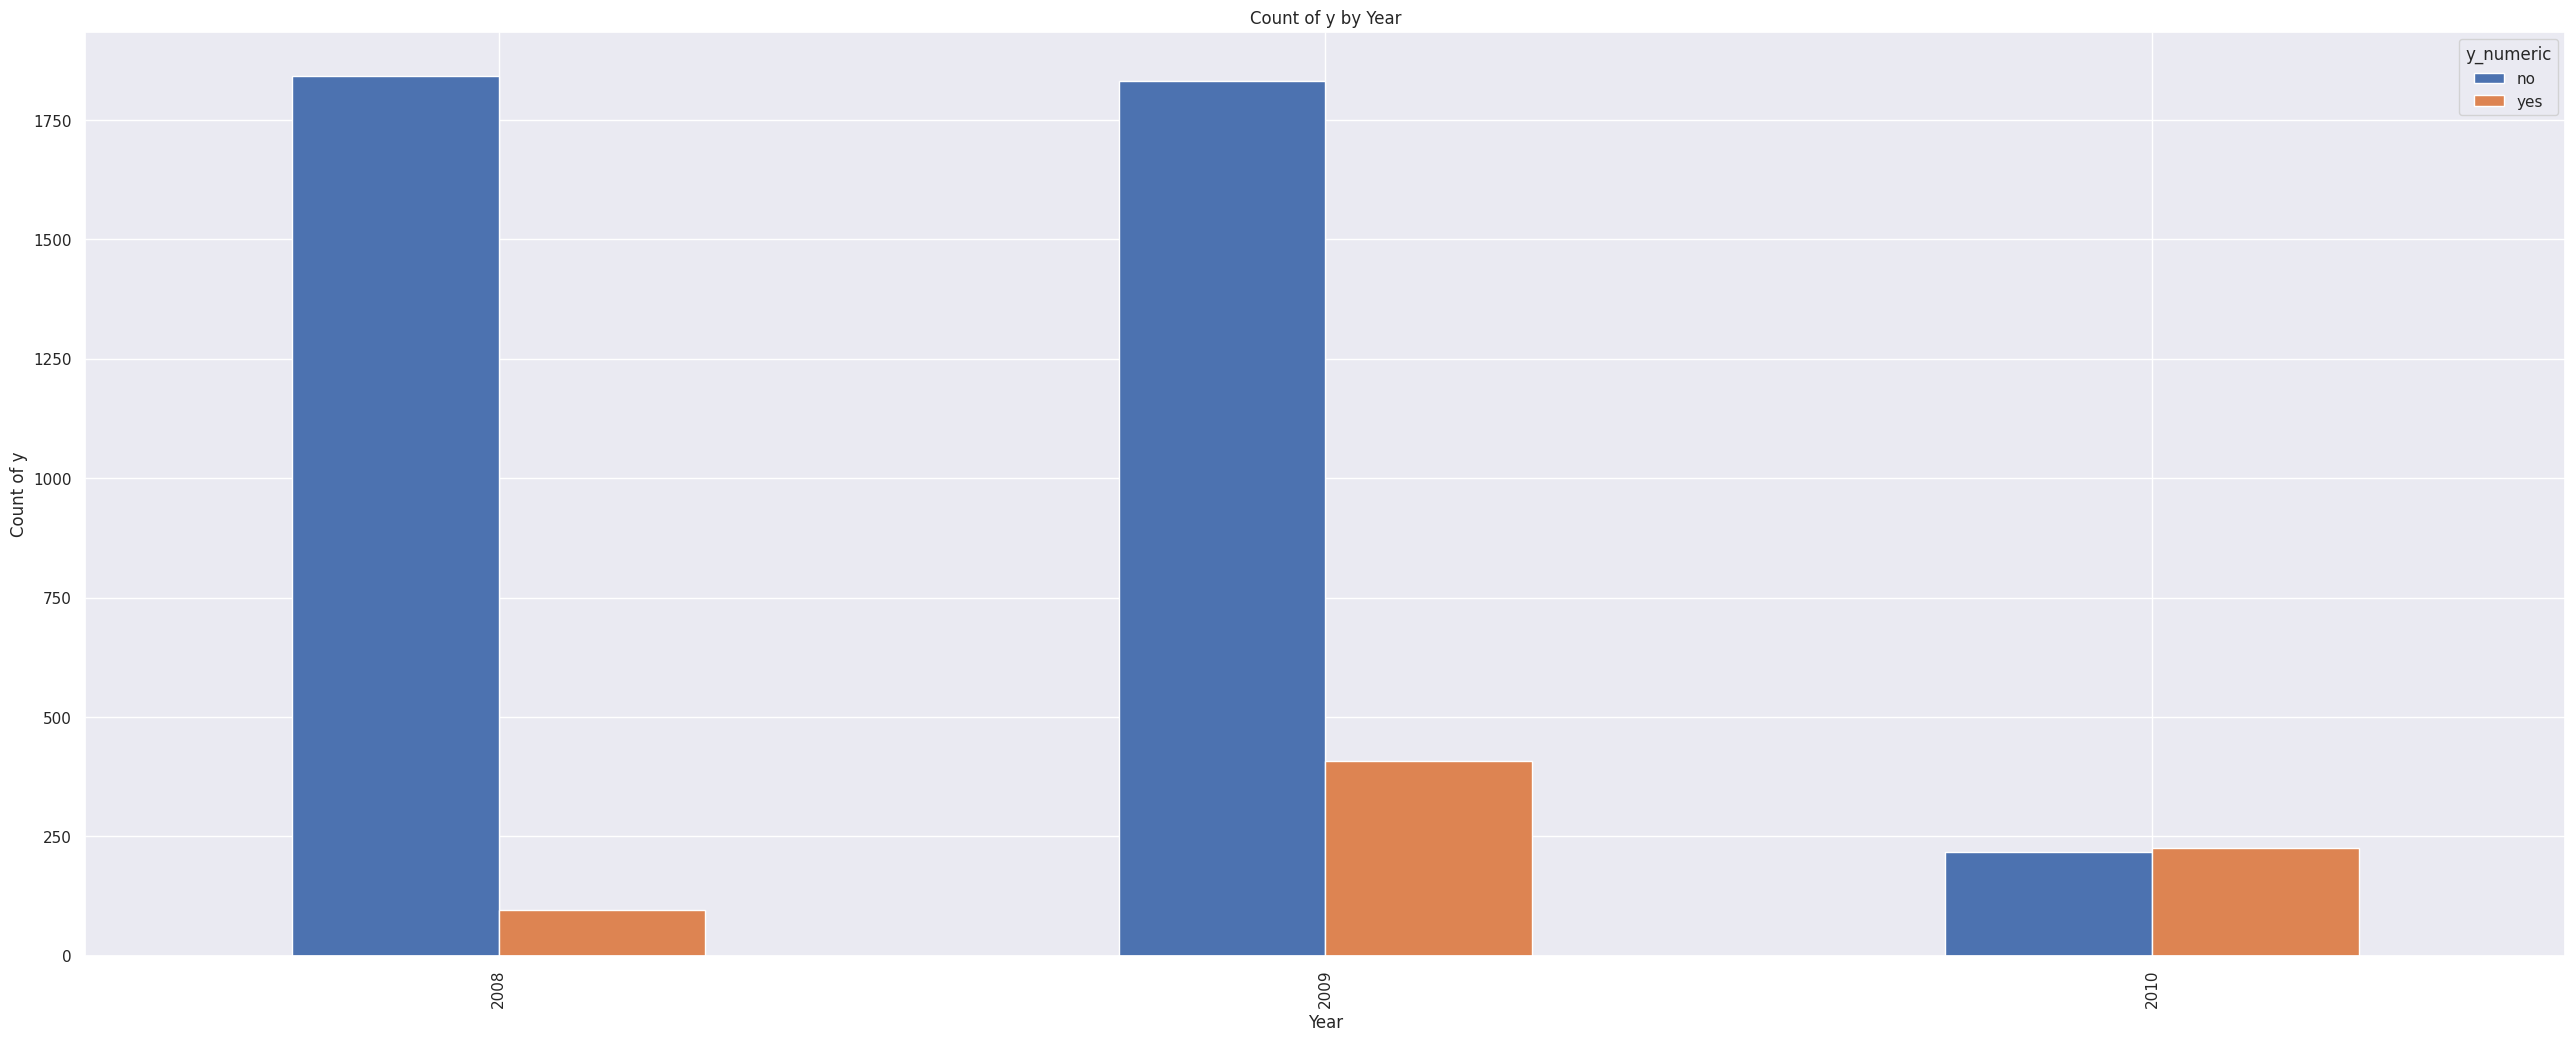

In [139]:
plt.figure(figsize=(8, 6))

grouped_data = df_oversampled.groupby(['year', 'y_numeric'])['y_numeric'].count().unstack(fill_value=0)

grouped_data.plot(kind='bar')
plt.xlabel('Year')
plt.ylabel('Count of y')
plt.title('Count of y by Year')
plt.legend(title='y_numeric', labels=['no', 'yes'])
plt.show()

In [140]:
categories = []

for column in df_oversampled.columns:

    patterns = ["job_", "marital_", "housing_", "education_", "contact_", "loan_", "day_of_week_", "poutcome_", "month_"]

    for pattern in patterns:
        if pattern in column:
            categories.append(column)

In [141]:
patterns = ["job_", "marital_", "housing_", 'education_', 'contact_', 'loan_', 'day_of_week_', 'poutcome_', 'month_']

In [142]:
categories

['job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'marital_divorced',
 'marital_married',
 'marital_single',
 'education_basic.4y',
 'education_basic.6y',
 'education_basic.9y',
 'education_high.school',
 'education_illiterate',
 'education_professional.course',
 'education_university.degree',
 'housing_no',
 'housing_yes',
 'loan_no',
 'loan_yes',
 'contact_cellular',
 'contact_telephone',
 'day_of_week_mon',
 'day_of_week_tue',
 'day_of_week_wed',
 'day_of_week_thu',
 'day_of_week_fri',
 'poutcome_failure',
 'poutcome_nonexistent',
 'poutcome_success',
 'month_jan',
 'month_feb',
 'month_mar',
 'month_apr',
 'month_may',
 'month_jun',
 'month_jul',
 'month_aug',
 'month_sep',
 'month_oct',
 'month_nov',
 'month_dec']

In [143]:
job_categories = []
marital_categories = []
housing_categories = []
education_categories = []
contact_categories = []
loan_categories = []
day_of_week_categories = []
poutcome_categories = []
month_categories = []

# Iteruj przez 'categories' i podziel na kategorie na podstawie wzorców
for category in categories:
    for pattern in patterns:
        if category.startswith(pattern):
            if pattern == "job_":
                job_categories.append(category)
            elif pattern == "marital_":
                marital_categories.append(category)
            elif pattern == "housing_":
                housing_categories.append(category)
            elif pattern == "education_":
                education_categories.append(category)
            elif pattern == "contact_":
                contact_categories.append(category)
            elif pattern == "loan_":
                loan_categories.append(category)
            elif pattern == "day_of_week_":
                day_of_week_categories.append(category)
            elif pattern == "poutcome_":
                poutcome_categories.append(category)
            elif pattern == "month_":
                month_categories.append(category)

In [144]:
# Odtwórz oryginalne kategorie na podstawie kolumn numerycznych
df_oversampled['job'] = df_oversampled[job_categories].idxmax(axis=1)
df_oversampled['marital'] = df_oversampled[marital_categories].idxmax(axis=1)
df_oversampled['housing'] = df_oversampled[housing_categories].idxmax(axis=1)
df_oversampled['education'] = df_oversampled[education_categories].idxmax(axis=1)
df_oversampled['contact'] = df_oversampled[contact_categories].idxmax(axis=1)
df_oversampled['loan'] = df_oversampled[loan_categories].idxmax(axis=1)
df_oversampled['day_of_week'] = df_oversampled[day_of_week_categories].idxmax(axis=1)
df_oversampled['poutcome'] = df_oversampled[poutcome_categories].idxmax(axis=1)
df_oversampled['month'] = df_oversampled[month_categories].idxmax(axis=1)
# Odtwórz pozostałe oryginalne kategorie


df_oversampled['marital'] = df_oversampled[marital_categories].idxmax(axis=1)
df_oversampled['housing'] = df_oversampled[housing_categories].idxmax(axis=1)
df_oversampled['education'] = df_oversampled[education_categories].idxmax(axis=1)
df_oversampled['contact'] = df_oversampled[contact_categories].idxmax(axis=1)
df_oversampled['loan'] = df_oversampled[loan_categories].idxmax(axis=1)
df_oversampled['day_of_week'] = df_oversampled[day_of_week_categories].idxmax(axis=1)
df_oversampled['poutcome'] = df_oversampled[poutcome_categories].idxmax(axis=1)
df_oversampled['month'] = df_oversampled[month_categories].idxmax(axis=1)

# # Usuń kolumny numeryczne
df_oversampled = df_oversampled.drop(columns=job_categories)
df_oversampled = df_oversampled.drop(columns=marital_categories)
df_oversampled = df_oversampled.drop(columns=housing_categories)
df_oversampled = df_oversampled.drop(columns=education_categories)
df_oversampled = df_oversampled.drop(columns=contact_categories)
df_oversampled = df_oversampled.drop(columns=loan_categories)
df_oversampled = df_oversampled.drop(columns=day_of_week_categories)
df_oversampled = df_oversampled.drop(columns=poutcome_categories)
df_oversampled = df_oversampled.drop(columns=month_categories)
# Usuń pozostałe kolumny numeryczne

# Teraz DataFrame df_oversampled ma oryginalne kategorie
df_oversampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4623 entries, 0 to 4622
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            4623 non-null   int64  
 1   campaign       4623 non-null   int64  
 2   pdays          4623 non-null   int64  
 3   previous       4623 non-null   int64  
 4   cons.conf.idx  4623 non-null   float64
 5   emp.var.rate   4623 non-null   float64
 6   year           4623 non-null   int64  
 7   y_numeric      4623 non-null   int64  
 8   job            4623 non-null   object 
 9   marital        4623 non-null   object 
 10  housing        4623 non-null   object 
 11  education      4623 non-null   object 
 12  contact        4623 non-null   object 
 13  loan           4623 non-null   object 
 14  day_of_week    4623 non-null   object 
 15  poutcome       4623 non-null   object 
 16  month          4623 non-null   object 
dtypes: float64(2), int64(6), object(9)
memory usage: 614

In [145]:
df_oversampled[cat_feat_sampling]

job          marital                      education  \
0          job_admin.   marital_single             education_basic.4y   
1     job_blue-collar  marital_married             education_basic.9y   
2         job_retired  marital_married    education_university.degree   
3      job_technician  marital_married  education_professional.course   
4       job_housemaid  marital_married             education_basic.4y   
...               ...              ...                            ...   
4618   job_technician  marital_married    education_university.degree   
4619      job_retired   marital_single             education_basic.4y   
4620     job_services  marital_married  education_professional.course   
4621   job_management  marital_married    education_university.degree   
4622     job_services  marital_married    education_university.degree   

          housing     loan            contact      day_of_week  \
0      housing_no  loan_no  contact_telephone  day_of_week_mon   
1      housing_no  loan_no  contact_telephone  day_of_week_fri   
2     housing_yes  loan_no  contact_telephone  day_of_week_fri   
3     housing_yes  loan_no   contact_cellular  day_of_week_thu   
4      housing_no  loan_no   contact_cellular  day_of_week_fri   
...           ...      ...                ...              ...   
4618   housing_no  loan_no   contact_cellular  day_of_week_thu   
4619   housing_no  loan_no   contact_cellular  day_of_week_mon   
4620  housing_yes  loan_no   contact_cellular  day_of_week_thu   
4621  housing_yes  loan_no   contact_cellular  day_of_week_fri   
4622  housing_yes  loan_no   contact_cellular  day_of_week_tue   

                  poutcome      month  
0     poutcome_nonexistent  month_may  
1     poutcome_nonexistent  month_jun  
2     poutcome_nonexistent  month_jun  
3     poutcome_nonexistent  month_aug  
4     poutcome_nonexistent  month_jul  
...                    ...        ...  
4618      poutcome_success  month_may  
4619      poutcome_success  month_nov  
4620      poutcome_success  month_apr  
4621      poutcome_success  month_jul  
4622  poutcome_nonexistent  month_jun  

[4623 rows x 9 columns]

In [146]:
df_oversampled['job'] = df_oversampled['job'].str.replace('job_', '')
df_oversampled['job']

0            admin.
1       blue-collar
2           retired
3        technician
4         housemaid
           ...     
4618     technician
4619        retired
4620       services
4621     management
4622       services
Name: job, Length: 4623, dtype: object

In [147]:
df_oversampled['marital'] = df_oversampled['marital'].str.replace('marital_', '')
df_oversampled['marital']

0        single
1       married
2       married
3       married
4       married
         ...   
4618    married
4619     single
4620    married
4621    married
4622    married
Name: marital, Length: 4623, dtype: object

In [148]:
df_oversampled['housing'] = df_oversampled['housing'].str.replace('housing_', '')
df_oversampled['housing']

0        no
1        no
2       yes
3       yes
4        no
       ... 
4618     no
4619     no
4620    yes
4621    yes
4622    yes
Name: housing, Length: 4623, dtype: object

In [149]:
df_oversampled['education'] = df_oversampled['education'].str.replace('education_', '')
df_oversampled['education']

0                  basic.4y
1                  basic.9y
2         university.degree
3       professional.course
4                  basic.4y
               ...         
4618      university.degree
4619               basic.4y
4620    professional.course
4621      university.degree
4622      university.degree
Name: education, Length: 4623, dtype: object

In [150]:
df_oversampled['contact'] = df_oversampled['contact'].str.replace('contact_', '')
df_oversampled['contact']

0       telephone
1       telephone
2       telephone
3        cellular
4        cellular
          ...    
4618     cellular
4619     cellular
4620     cellular
4621     cellular
4622     cellular
Name: contact, Length: 4623, dtype: object

In [151]:
df_oversampled['loan'] = df_oversampled['loan'].str.replace('loan_', '')
df_oversampled['loan']

0       no
1       no
2       no
3       no
4       no
        ..
4618    no
4619    no
4620    no
4621    no
4622    no
Name: loan, Length: 4623, dtype: object

In [152]:
df_oversampled['month'] = df_oversampled['month'].str.replace('month_', '')
df_oversampled['month']

0       may
1       jun
2       jun
3       aug
4       jul
       ... 
4618    may
4619    nov
4620    apr
4621    jul
4622    jun
Name: month, Length: 4623, dtype: object

In [153]:
df_oversampled['day_of_week'] = df_oversampled['day_of_week'].str.replace('day_of_week_', '')
df_oversampled['day_of_week']

0       mon
1       fri
2       fri
3       thu
4       fri
       ... 
4618    thu
4619    mon
4620    thu
4621    fri
4622    tue
Name: day_of_week, Length: 4623, dtype: object

In [154]:
df_oversampled['poutcome'] = df_oversampled['poutcome'].str.replace('poutcome_', '')
df_oversampled['poutcome']

0       nonexistent
1       nonexistent
2       nonexistent
3       nonexistent
4       nonexistent
           ...     
4618        success
4619        success
4620        success
4621        success
4622    nonexistent
Name: poutcome, Length: 4623, dtype: object

In [155]:
df_oversampled['month_year'] = df_oversampled['month'] + '_' + df_oversampled['year'].astype('str')

In [156]:
df_oversampled.drop(columns='month', inplace=True)
df_oversampled.drop(columns='year', inplace=True)

In [157]:
df_oversampled['month_year'] = df_oversampled['month_year'].astype('category')
df_oversampled['day_of_week'] = df_oversampled['day_of_week'].astype('category')

In [158]:
# dane dla części testowej z podziału przed dolosowywaniem

X_test_sampling['month_year'] = X_test_sampling['month'].astype('str') + '_' + X_test_sampling['year'].astype('str')

In [159]:
X_test_sampling.drop(columns='month', inplace=True)
X_test_sampling.drop(columns='year', inplace=True)

In [160]:
X_test_sampling['y_numeric'] = y_test_sampling

In [161]:
X_test_sampling['month_year'] = X_test_sampling['month_year'].astype('category')

In [162]:
X_test_sampling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1236 entries, 2577 to 2937
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   age            1236 non-null   int64   
 1   job            1236 non-null   object  
 2   marital        1236 non-null   object  
 3   education      1236 non-null   object  
 4   housing        1236 non-null   object  
 5   loan           1236 non-null   object  
 6   contact        1236 non-null   object  
 7   day_of_week    1236 non-null   category
 8   campaign       1236 non-null   int64   
 9   pdays          1236 non-null   int64   
 10  previous       1236 non-null   int64   
 11  poutcome       1236 non-null   object  
 12  cons.conf.idx  1236 non-null   float64 
 13  emp.var.rate   1236 non-null   float64 
 14  month_year     1236 non-null   category
 15  y_numeric      1236 non-null   int64   
dtypes: category(2), float64(2), int64(5), object(7)
memory usage: 148.2+ KB


## Przygotowanie do modelowania

In [163]:
y_train_5 = df_oversampled.pop('y_numeric')
X_train_5 = df_oversampled

In [164]:
y_test_5 = X_test_sampling.pop('y_numeric')
X_test_5 = X_test_sampling

In [165]:
print(X_train_5.shape, y_train_5.shape, X_test_5.shape, y_test_5.shape)

(4623, 15) (4623,) (1236, 15) (1236,)


In [166]:
num_feat_5 = [col for col in df_oversampled.select_dtypes(include=['integer', 'float']).columns if col != 'y_numeric']
cat_feat_5 = [col for col in df_oversampled.select_dtypes(include=['object']).columns if col != 'y']
ord_feat_5 = [col for col in df_oversampled.select_dtypes(include=['category']).columns if col != 'y']

print(f'No. of numerical features: {len(num_feat_5)}')
print(num_feat_5)
print()
print(f'No. of categorical features: {len(cat_feat_5)}')
print(cat_feat_5)
print()
print(f'No. of ordinal features: {len(ord_feat_5)}')
print(ord_feat_5)

No. of numerical features: 6
['age', 'campaign', 'pdays', 'previous', 'cons.conf.idx', 'emp.var.rate']

No. of categorical features: 7
['job', 'marital', 'housing', 'education', 'contact', 'loan', 'poutcome']

No. of ordinal features: 2
['day_of_week', 'month_year']


## Feature Importance - RandomForestClassifier() - Zestaw danych nr 5

In [167]:
categorical_transformer = Pipeline(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', categorical_transformer, cat_feat_5),
        ('ordinal', ordinal_transformer, ord_feat_5)
    ]
)

rfc_pipeline_5 = Pipeline(steps=[('preprocessor', preprocessor),
                              ('rfc_model_5', RandomForestClassifier(random_state=seed))])

In [168]:
rfc_pipeline_5.fit(X_train_5, y_train_5)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder())]),
                                                  ['job', 'marital', 'housing',
                                                   'education', 'contact',
                                                   'loan', 'poutcome']),
                                                 ('ordinal',
                                                  Pipeline(steps=[('label_encoder',
                                                                   <__main__.LabelEncoderTransformer object at 0x7d387fafb040>)]),
                                                  ['day_of_week',
                                                   'month_year'])])),
                ('rfc_model_5', RandomForestClassifier(random_state=23))])

In [169]:
feature_importance = rfc_pipeline_5.steps[-1][1].feature_importances_
all_column_names = X_train_5.columns

importance_tuples = [(col, imp) for col, imp in zip(all_column_names, feature_importance)]

# Sort the list by feature importance in descending order
rfc_pre_sorted_importance = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

# Print feature importance values for each column in descending order
print('Random Forest Feature Importance - zestaw danych 5: \n')
for column, importance in rfc_pre_sorted_importance:
    print(f" {column}: {importance}")

Random Forest Feature Importance - zestaw danych 5: 

 month_year: 0.026067169937455503
 day_of_week: 0.0251685574498777
 poutcome: 0.025107676152262476
 age: 0.022562089954153892
 education: 0.021125267889451696
 loan: 0.017718680592278824
 marital: 0.016229266887192634
 cons.conf.idx: 0.015459487788024272
 campaign: 0.014000471940907255
 housing: 0.013369403947851813
 emp.var.rate: 0.010679413858471688
 contact: 0.00866844189203183
 job: 0.0080643404048423
 pdays: 0.006128921290002406
 previous: 0.004906396924495462


#Modelowanie

## Baseline Random Forest Classifier - zestaw 1

In [170]:
X_test_data = X_test
y_test_data = y_test

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       734
           1       0.56      0.20      0.30        90

    accuracy                           0.90       824
   macro avg       0.74      0.59      0.62       824
weighted avg       0.87      0.90      0.87       824



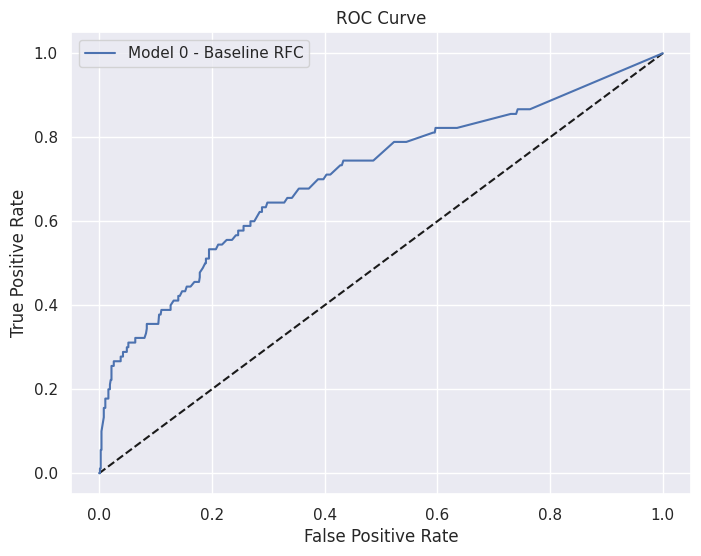

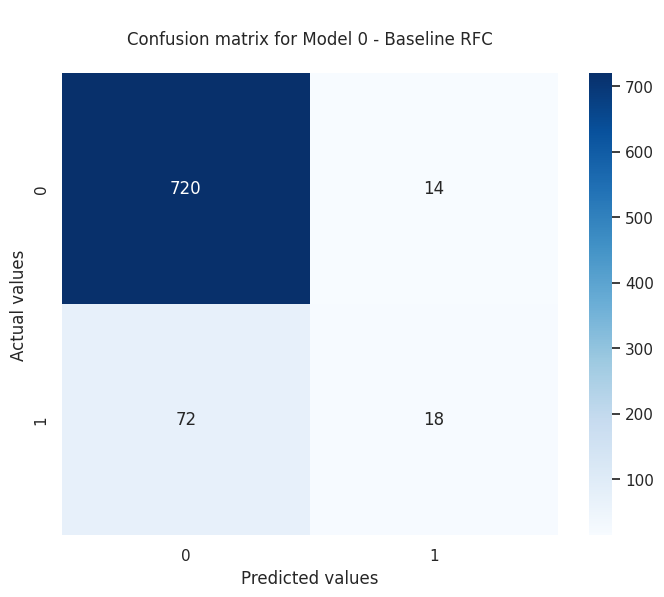

Model  F1_score       AUC
0  Model 0 - Baseline RFC  0.295082  0.706668

In [171]:
sns.set(rc={"figure.figsize":(8, 6)})
calculation_metrics(rfc_pipeline, 'Model 0 - Baseline RFC')

## Model 1 - Logistic Regression zestaw danych 1


* z użyciem zestawu danych nr 1 wraz SMOTE (oversampling danych - przeciwdziałanie niezbalansowaniu - widoczny słabe wyniki prognozy w mniej licznej klasie) - dodanie również StandardScaler() - celem jest sprawdzenie feature importance dla wskaźników finansowych


In [172]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat),
        ('ordinal_transformer', ordinal_transformer, ord_feat),
        ('numeric_transformer', numeric_transformer, num_feat)
    ]
)

lr_pipeline = Pipeline_imb(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=seed)),
                              ('lr_model', LogisticRegression(random_state=seed))])

In [173]:
lr_param_grid = {
    'smote__sampling_strategy': [ 'minority', 'all', 0.5, 0.8, 0.9],
    'smote__k_neighbors': [2, 3, 5],
    'lr_model__C': [0.001, 0.01, 0.1],
    'lr_model__penalty': ['l1', 'l2', 'none'],
    'lr_model__max_iter': [15, 25, 50],
}

In [ ]:
lr_model_gridsearch = HalvingGridSearchCV(estimator = lr_pipeline,
                                       param_grid = lr_param_grid,
                                       scoring='f1_weighted',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=seed,
                                       refit=True)

lr_model_gridsearch.fit(X_train, y_train)

In [175]:
print('\nBest hyperparameter:', lr_model_gridsearch.best_params_)


Best hyperparameter: {'lr_model__C': 0.01, 'lr_model__max_iter': 15, 'lr_model__penalty': 'l2', 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.8}


In [176]:
lr_model = lr_model_gridsearch.best_estimator_

In [177]:
X_test_data = X_test
y_test_data = y_test

              precision    recall  f1-score   support

           0       0.95      0.87      0.91       734
           1       0.36      0.59      0.44        90

    accuracy                           0.84       824
   macro avg       0.65      0.73      0.67       824
weighted avg       0.88      0.84      0.86       824



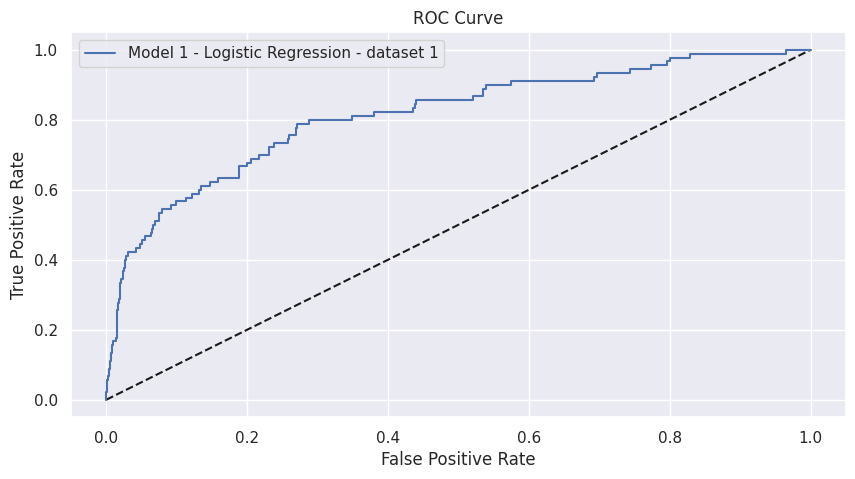

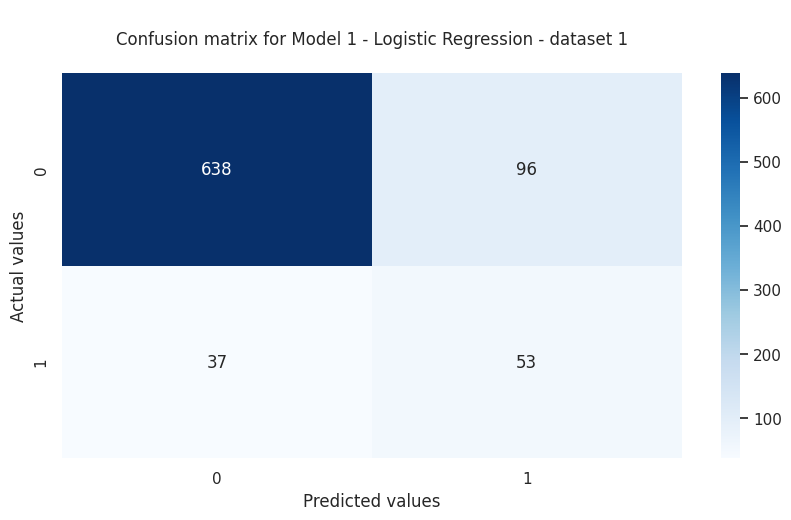

Model  F1_score       AUC
0                     Model 0 - Baseline RFC  0.295082  0.706668
1  Model 1 - Logistic Regression - dataset 1  0.443515  0.813896

In [178]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(lr_model, 'Model 1 - Logistic Regression - dataset 1')

### Sprawdzenie istotności cech na bazie Regresji Logistycznej - zestaw 1

In [179]:
training_features = list(model_columns)
training_features.remove('y_numeric')

In [180]:
calculate_and_print_feature_importance(lr_model, training_features)

Feature: housing, Importance: 0.175177139210776
Feature: age, Importance: 0.15860554122447473
Feature: previous, Importance: 0.15782289331996194
Feature: campaign, Importance: 0.13518323779640337
Feature: pdays, Importance: 0.10739383979024758
Feature: contact, Importance: 0.10604134467530842
Feature: education, Importance: 0.10576845381131755
Feature: nr.employed, Importance: 0.09970193884028697
Feature: euribor3m, Importance: 0.08640855182053632
Feature: marital, Importance: 0.0767016566223686
Feature: emp.var.rate, Importance: 0.050358015457208284
Feature: month, Importance: 0.043299102767981434
Feature: day_of_week, Importance: 0.03713878577265043
Feature: loan, Importance: 0.02399067306865605
Feature: cons.conf.idx, Importance: 0.023568848823901613
Feature: job, Importance: 0.015509793262396682
Feature: cons.price.idx, Importance: 0.012483984920966924
Feature: poutcome, Importance: 0.004021480144527018


## Model 2 - Logistic Regression zestaw danych 2

In [181]:
data_2.head()

age          job  marital          education housing loan    contact  \
0   30  blue-collar  married           basic.9y     yes   no   cellular   
1   39     services   single        high.school      no   no  telephone   
2   25     services  married        high.school     yes   no  telephone   
3   38     services  married           basic.9y     yes   no  telephone   
4   47       admin.  married  university.degree     yes   no   cellular   

  day_of_week  campaign  pdays  previous     poutcome  emp.var.rate month_year  
0         fri         2    999         0  nonexistent          -1.8   may_2009  
1         fri         4    999         0  nonexistent           1.1   may_2008  
2         wed         1    999         0  nonexistent           1.4   jun_2008  
3         fri         3    999         0  nonexistent           1.4   jun_2008  
4         mon         1    999         0  nonexistent          -0.1   nov_2008

In [182]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_2),
        ('ordinal_transformer', ordinal_transformer, ord_feat_2),
        ('numeric_transformer', numeric_transformer, num_feat_2)
    ]
)

lr_pipeline_2 = Pipeline_imb(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=seed)),
                              ('lr_model_2', LogisticRegression(random_state=seed))])

In [183]:
lr_param_grid_2 = {
    'smote__sampling_strategy': [ 'minority', 'all', 0.3, 0.5, 0.8],
    'smote__k_neighbors': [3, 4, 5],
    'lr_model_2__C': [0.001, 0.01, 0.1],
    'lr_model_2__penalty': ['l1', 'l2', 'none'],
    'lr_model_2__max_iter': [4, 8, 15, 25]
}

In [ ]:
lr_model_2_gridsearch = HalvingGridSearchCV(estimator = lr_pipeline_2,
                                       param_grid = lr_param_grid_2,
                                       scoring='f1_weighted',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=seed,
                                       refit=True)

lr_model_2_gridsearch.fit(X_train_2, y_train_2)

In [185]:
print('\nBest hyperparameter:', lr_model_2_gridsearch.best_params_)


Best hyperparameter: {'lr_model_2__C': 0.01, 'lr_model_2__max_iter': 4, 'lr_model_2__penalty': 'l2', 'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.5}


In [186]:
lr_model_2 = lr_model_2_gridsearch.best_estimator_

In [187]:
X_test_data = X_test_2
y_test_data = y_test_2

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       734
           1       0.37      0.39      0.38        90

    accuracy                           0.86       824
   macro avg       0.65      0.65      0.65       824
weighted avg       0.86      0.86      0.86       824



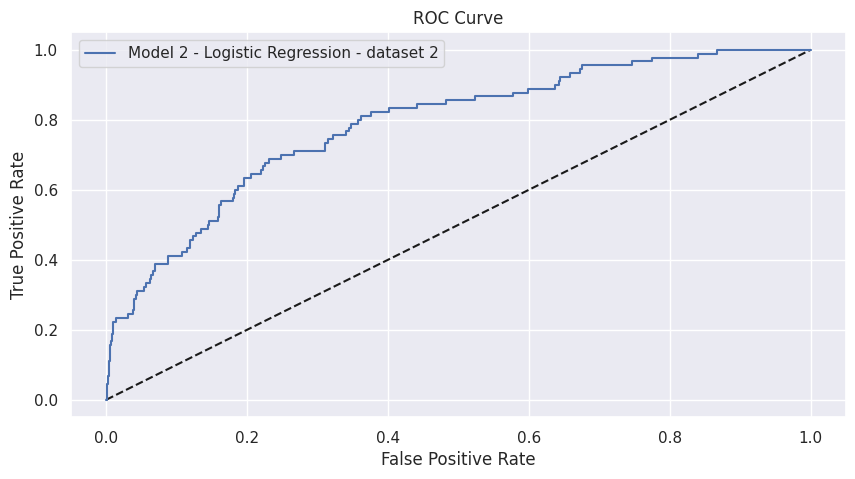

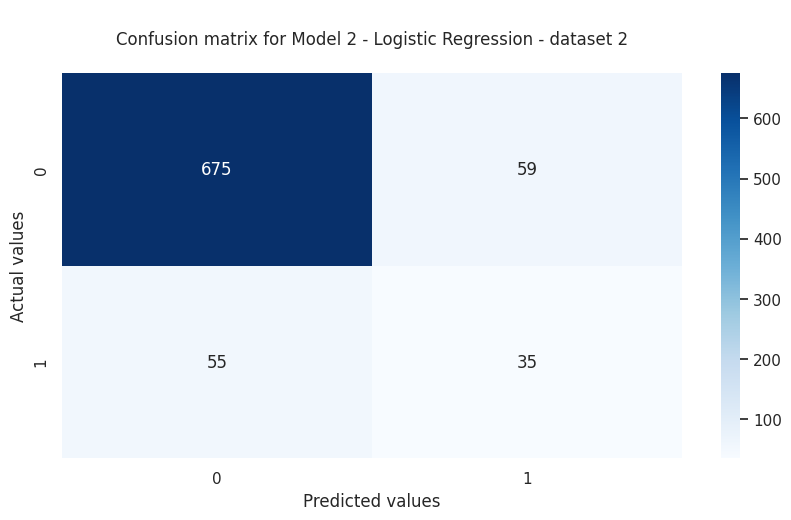

Model  F1_score       AUC
0                     Model 0 - Baseline RFC  0.295082  0.706668
1  Model 1 - Logistic Regression - dataset 1  0.443515  0.813896
2  Model 2 - Logistic Regression - dataset 2  0.380435  0.786088

In [188]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(lr_model_2, 'Model 2 - Logistic Regression - dataset 2')

### Istotność cech Logistic Regression zestaw danych 2

In [189]:
training_features_2 = list(model_columns_2)
training_features_2.remove('y_numeric')
training_features_2

['age',
 'job',
 'marital',
 'education',
 'housing',
 'loan',
 'contact',
 'day_of_week',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'month_year']

In [190]:
calculate_and_print_feature_importance(lr_model_2, training_features_2)

Feature: emp.var.rate, Importance: 0.0679821624730779
Feature: job, Importance: 0.055727500804553645
Feature: housing, Importance: 0.024553835878027765
Feature: day_of_week, Importance: 0.022391866193650738
Feature: poutcome, Importance: 0.02115893126060713
Feature: loan, Importance: 0.01395748632991227
Feature: previous, Importance: 0.013565038393704546
Feature: marital, Importance: 0.012864581884209608
Feature: campaign, Importance: 0.011363176322935811
Feature: education, Importance: 0.009010531566169046
Feature: contact, Importance: 0.00812929359625971
Feature: age, Importance: 0.008110228408805202
Feature: month_year, Importance: 0.0051919087455658194
Feature: pdays, Importance: 0.0017324954793953727


## Model 3 - Logistic Regression zestaw danych 3

In [191]:
data_3.head()

age          job  marital          education housing loan    contact  \
0   30  blue-collar  married           basic.9y     yes   no   cellular   
1   39     services   single        high.school      no   no  telephone   
2   25     services  married        high.school     yes   no  telephone   
3   38     services  married           basic.9y     yes   no  telephone   
4   47       admin.  married  university.degree     yes   no   cellular   

  day_of_week  campaign  pdays  previous     poutcome month  cons.conf.idx  \
0         fri         2    999         0  nonexistent   may          -46.2   
1         fri         4    999         0  nonexistent   may          -36.4   
2         wed         1    999         0  nonexistent   jun          -41.8   
3         fri         3    999         0  nonexistent   jun          -41.8   
4         mon         1    999         0  nonexistent   nov          -42.0   

   emp.var.rate  
0          -1.8  
1           1.1  
2           1.4  
3           1.4  
4          -0.1

In [192]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_3),
        ('ordinal_transformer', ordinal_transformer, ord_feat_3),
        ('numeric_transformer', numeric_transformer, num_feat_3)
    ]
)

lr_pipeline_3 = Pipeline_imb(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=seed)),
                              ('lr_model_3', LogisticRegression(random_state=seed))])

In [193]:
lr_param_grid_3 = {
    'smote__sampling_strategy': [ 'minority', 'all', 0.3, 0.5, 0.8],
    'smote__k_neighbors': [3, 4, 5],
    'lr_model_3__C': [0.001, 0.01, 0.1],
    'lr_model_3__penalty': ['l1', 'l2', 'none'],
    'lr_model_3__max_iter': [25, 50, 100],
}

In [ ]:
lr_model_3_gridsearch = HalvingGridSearchCV(estimator = lr_pipeline_3,
                                       param_grid = lr_param_grid_3,
                                       scoring='f1_weighted',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=seed,
                                       refit=True)

lr_model_3_gridsearch.fit(X_train_3, y_train_3)

In [195]:
print('\nBest hyperparameter:', lr_model_3_gridsearch.best_params_)


Best hyperparameter: {'lr_model_3__C': 0.01, 'lr_model_3__max_iter': 50, 'lr_model_3__penalty': 'l2', 'smote__k_neighbors': 3, 'smote__sampling_strategy': 0.5}


In [196]:
lr_model_3 = lr_model_3_gridsearch.best_estimator_

In [197]:
X_test_data = X_test_3
y_test_data = y_test_3

              precision    recall  f1-score   support

           0       0.93      0.93      0.93       734
           1       0.42      0.39      0.40        90

    accuracy                           0.87       824
   macro avg       0.67      0.66      0.67       824
weighted avg       0.87      0.87      0.87       824



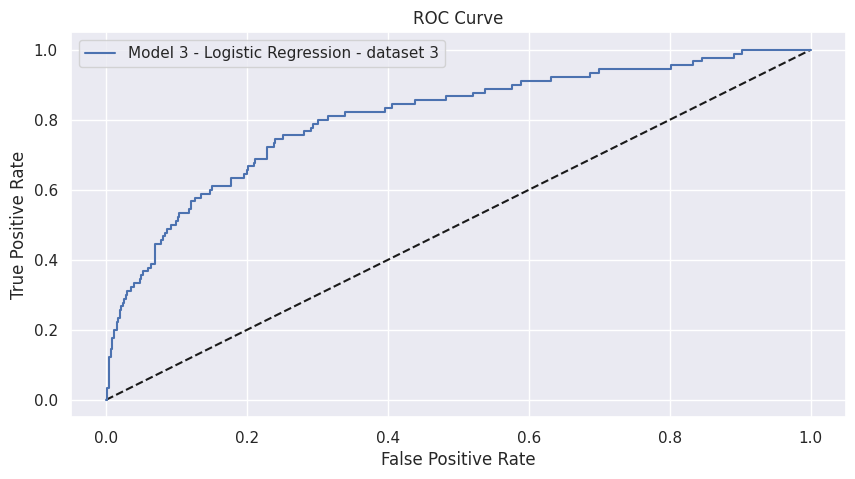

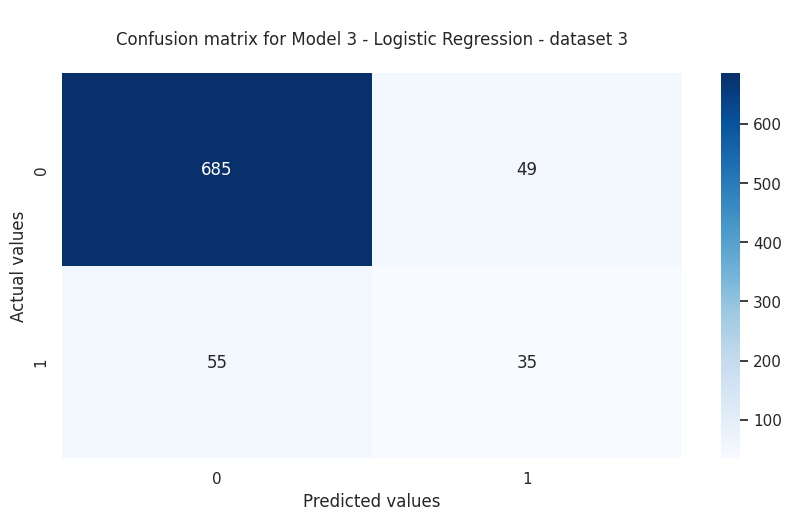

Model  F1_score       AUC
0                     Model 0 - Baseline RFC  0.295082  0.706668
1  Model 1 - Logistic Regression - dataset 1  0.443515  0.813896
2  Model 2 - Logistic Regression - dataset 2  0.380435  0.786088
3  Model 3 - Logistic Regression - dataset 3  0.402299  0.805767

In [198]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(lr_model_3, 'Model 3 - Logistic Regression - dataset 3')

### Istotność cech Logitic Regression zestaw 3

In [199]:
training_features_3 = list(model_columns_3)
training_features_3.remove('y_numeric')
training_features_3

['age',
 'job',
 'marital',
 'education',
 'housing',
 'loan',
 'contact',
 'day_of_week',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'month',
 'cons.conf.idx',
 'emp.var.rate']

In [200]:
calculate_and_print_feature_importance(lr_model_3, training_features_3)

Feature: age, Importance: 0.18797224108017593
Feature: housing, Importance: 0.1682120405614
Feature: pdays, Importance: 0.08835225428374605
Feature: poutcome, Importance: 0.083240253555034
Feature: previous, Importance: 0.0751249060155485
Feature: education, Importance: 0.06495319414745161
Feature: marital, Importance: 0.06392731111757435
Feature: day_of_week, Importance: 0.06317826386839759
Feature: cons.conf.idx, Importance: 0.054368591246276736
Feature: contact, Importance: 0.05035467069349298
Feature: emp.var.rate, Importance: 0.04541909810732866
Feature: campaign, Importance: 0.04149494572489367
Feature: month, Importance: 0.028901585349931348
Feature: loan, Importance: 0.01664304707491994
Feature: job, Importance: 0.0010680092502045517


## Model 4 - Logistic Regression zestaw danych 4

In [201]:
data_4.head()

age          job  marital          education housing loan    contact  \
0   30  blue-collar  married           basic.9y     yes   no   cellular   
1   39     services   single        high.school      no   no  telephone   
2   25     services  married        high.school     yes   no  telephone   
3   38     services  married           basic.9y     yes   no  telephone   
4   47       admin.  married  university.degree     yes   no   cellular   

  day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
0         fri         2    999         0  nonexistent          -1.8   
1         fri         4    999         0  nonexistent           1.1   
2         wed         1    999         0  nonexistent           1.4   
3         fri         3    999         0  nonexistent           1.4   
4         mon         1    999         0  nonexistent          -0.1   

   cons.conf.idx month_year  
0          -46.2   may_2009  
1          -36.4   may_2008  
2          -41.8   jun_2008  
3          -41.8   jun_2008  
4          -42.0   nov_2008

In [202]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_4),
        ('ordinal_transformer', ordinal_transformer, ord_feat_4),
        ('numeric_transformer', numeric_transformer, num_feat_4)
    ]
)

lr_4_pipeline = Pipeline_imb(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=seed)),
                              ('lr_model_4', LogisticRegression(random_state=seed))])

In [203]:
lr_4_param_grid = {
    'smote__sampling_strategy': [ 'minority', 'all', 0.5, 0.8, 0.9],
    'smote__k_neighbors': [4, 5, 7],
    'lr_model_4__C': [0.001, 0.01, 0.1],
    'lr_model_4__penalty': ['l1', 'l4', 'none', 'elasticnet'],
    'lr_model_4__max_iter': [25, 50, 100],
}

In [ ]:
lr_model_gridsearch_4 = HalvingGridSearchCV(estimator = lr_4_pipeline,
                                       param_grid = lr_4_param_grid,
                                       scoring='f1_weighted',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=seed,
                                       refit=True)

lr_model_gridsearch_4.fit(X_train_4, y_train_4)

In [205]:
print('\nBest hyperparameter:', lr_model_gridsearch_4.best_params_)


Best hyperparameter: {'lr_model_4__C': 0.01, 'lr_model_4__max_iter': 25, 'lr_model_4__penalty': 'none', 'smote__k_neighbors': 7, 'smote__sampling_strategy': 0.8}


In [206]:
lr_model_4 = lr_model_gridsearch_4.best_estimator_

In [207]:
X_test_data = X_test_4
y_test_data = y_test_4

              precision    recall  f1-score   support

           0       0.95      0.83      0.88       734
           1       0.31      0.62      0.41        90

    accuracy                           0.81       824
   macro avg       0.63      0.73      0.65       824
weighted avg       0.88      0.81      0.83       824



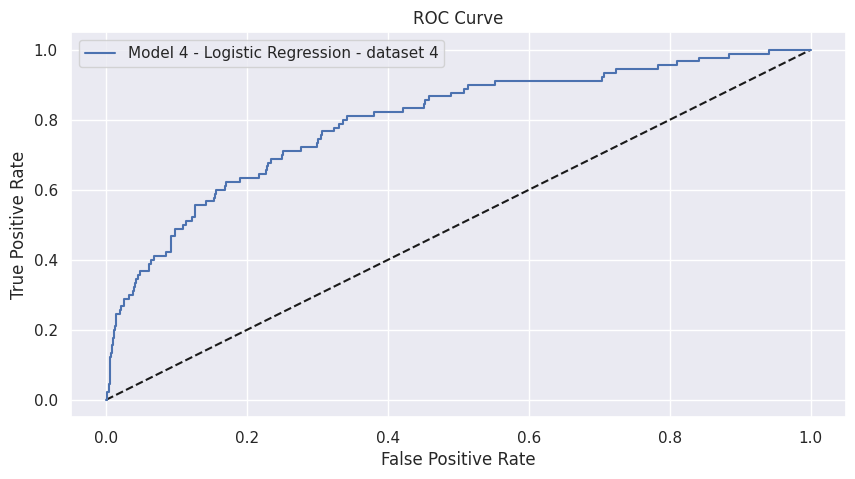

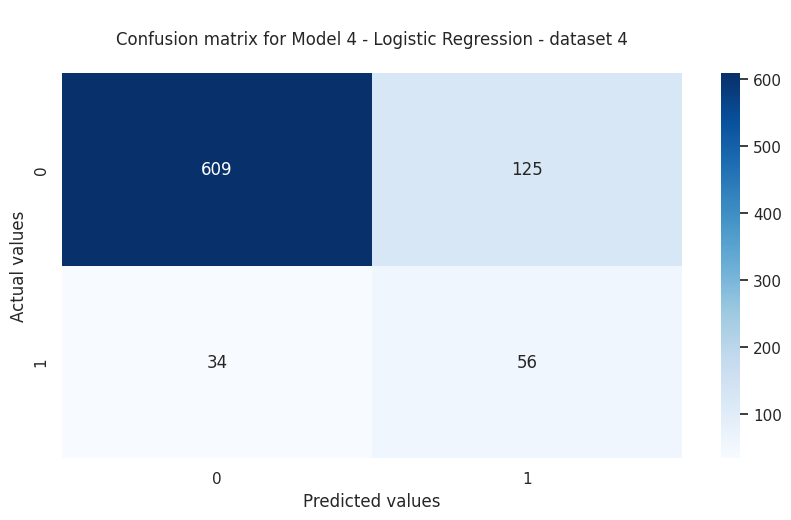

Model  F1_score       AUC
0                     Model 0 - Baseline RFC  0.295082  0.706668
1  Model 1 - Logistic Regression - dataset 1  0.443515  0.813896
2  Model 2 - Logistic Regression - dataset 2  0.380435  0.786088
3  Model 3 - Logistic Regression - dataset 3  0.402299  0.805767
4  Model 4 - Logistic Regression - dataset 4  0.413284  0.795777

In [208]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(lr_model_4, 'Model 4 - Logistic Regression - dataset 4')

### Istotność cech Logitic Regression zestaw 4

In [209]:
training_features_4 = list(model_columns_4)
training_features_4.remove('y_numeric')

In [210]:
training_features_4

['age',
 'job',
 'marital',
 'education',
 'housing',
 'loan',
 'contact',
 'day_of_week',
 'campaign',
 'pdays',
 'previous',
 'poutcome',
 'emp.var.rate',
 'cons.conf.idx',
 'month_year']

In [211]:
calculate_and_print_feature_importance(lr_model_4, training_features_4)

Feature: housing, Importance: 0.3883791878655073
Feature: poutcome, Importance: 0.33663197060748795
Feature: previous, Importance: 0.2104843506857789
Feature: age, Importance: 0.20968296771488903
Feature: contact, Importance: 0.20512418021133516
Feature: cons.conf.idx, Importance: 0.16751394614528914
Feature: education, Importance: 0.16071178493322777
Feature: pdays, Importance: 0.15843181737256318
Feature: marital, Importance: 0.14466441093629556
Feature: job, Importance: 0.12408595897160137
Feature: day_of_week, Importance: 0.11925380028275474
Feature: campaign, Importance: 0.08536932277824973
Feature: emp.var.rate, Importance: 0.06469225437597872
Feature: month_year, Importance: 0.0384199213902257
Feature: loan, Importance: 0.0037313321321379715


## Model 5 - Support Vector Classifier ()- zestaw 1

In [212]:
data.head()

age          job  marital          education housing loan    contact month  \
0   30  blue-collar  married           basic.9y     yes   no   cellular   may   
1   39     services   single        high.school      no   no  telephone   may   
2   25     services  married        high.school     yes   no  telephone   jun   
3   38     services  married           basic.9y     yes   no  telephone   jun   
4   47       admin.  married  university.degree     yes   no   cellular   nov   

  day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
0         fri         2    999         0  nonexistent          -1.8   
1         fri         4    999         0  nonexistent           1.1   
2         wed         1    999         0  nonexistent           1.4   
3         fri         3    999         0  nonexistent           1.4   
4         mon         1    999         0  nonexistent          -0.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed  
0          92.893          -46.2      1.313       5099.1  
1          93.994          -36.4      4.855       5191.0  
2          94.465          -41.8      4.962       5228.1  
3          94.465          -41.8      4.959       5228.1  
4          93.200          -42.0      4.191       5195.8

In [213]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

svm_pipeline = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat),
        ('ordinal_transformer', ordinal_transformer, ord_feat),
        ('numeric_transformer', numeric_transformer, num_feat)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('svm_model', svm.SVC(probability=True))
])

In [214]:
svm_param_grid = {
    'smote__sampling_strategy':
     ['all', 0.3, 0.5, 0.8],
    'smote__k_neighbors':
     [3, 5, 7],
    'svm_model__C':
     [0.001, 0.1, 1],
    'svm_model__kernel':
     ['linear', 'rbf', 'poly'],
    'svm_model__gamma':
     [ 0.001, 0.1]
}

In [ ]:
svm_search = HalvingGridSearchCV(svm_pipeline,
                                 svm_param_grid,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

svm_search.fit(X_train, y_train)

In [216]:
print('\nBest hyperparameter:', svm_search.best_params_)


Best hyperparameter: {'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.3, 'svm_model__C': 0.001, 'svm_model__gamma': 0.001, 'svm_model__kernel': 'linear'}


In [217]:
svm_model = svm_search.best_estimator_

In [218]:
X_test_data = X_test
y_test_data = y_test

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       734
           1       0.68      0.23      0.35        90

    accuracy                           0.90       824
   macro avg       0.80      0.61      0.65       824
weighted avg       0.89      0.90      0.88       824



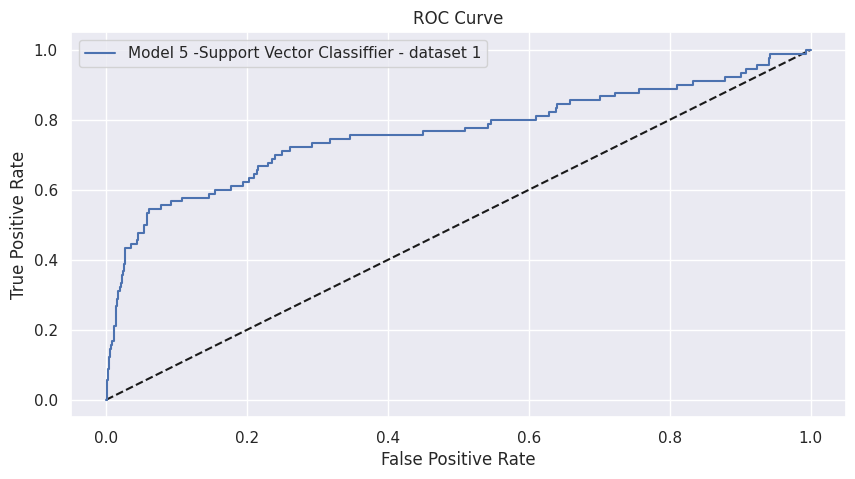

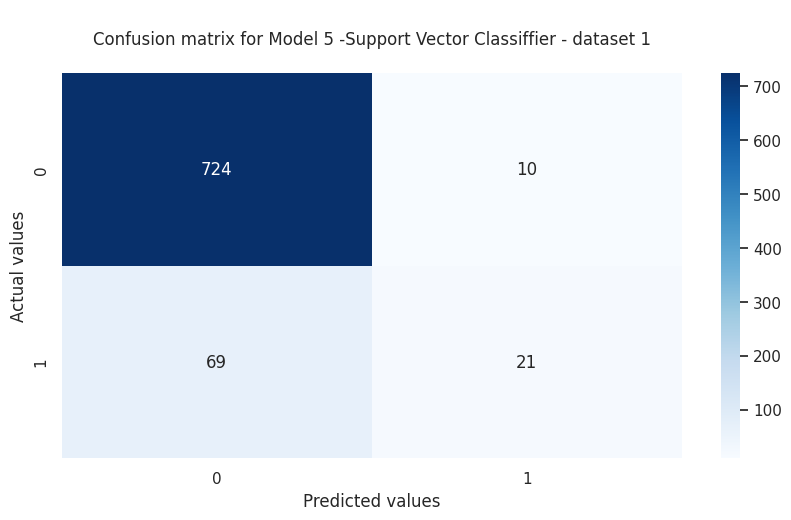

Model  F1_score       AUC
0                           Model 0 - Baseline RFC  0.295082  0.706668
1        Model 1 - Logistic Regression - dataset 1  0.443515  0.813896
2        Model 2 - Logistic Regression - dataset 2  0.380435  0.786088
3        Model 3 - Logistic Regression - dataset 3  0.402299  0.805767
4        Model 4 - Logistic Regression - dataset 4  0.413284  0.795777
5  Model 5 -Support Vector Classiffier - dataset 1  0.347107  0.761823

In [219]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(svm_model, 'Model 5 -Support Vector Classiffier - dataset 1')

In [220]:
feature_importance = calculate_and_print_feature_importance_2(svm_model, X_test, y_test)
print(feature_importance)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0427 ± 0.0090  pdays
     0 ± 0.0000  nr.employed
     0 ± 0.0000  month
     0 ± 0.0000  job
     0 ± 0.0000  marital
     0 ± 0.0000  education
     0 ± 0.0000  housing
     0 ± 0.0000  loan
     0 ± 0.0000  contact
     0 ± 0.0000  day_of_week
     0 ± 0.0000  euribor3m
     0 ± 0.0000  campaign
     0 ± 0.0000  previous
     0 ± 0.0000  poutcome
     0 ± 0.0000  emp.var.rate
     0 ± 0.0000  cons.price.idx
     0 ± 0.0000  cons.conf.idx
     0 ± 0.0000  age
None


## Model 6 - Support Vector Classifier () - zestaw 2

In [221]:
data_2.head()

age          job  marital          education housing loan    contact  \
0   30  blue-collar  married           basic.9y     yes   no   cellular   
1   39     services   single        high.school      no   no  telephone   
2   25     services  married        high.school     yes   no  telephone   
3   38     services  married           basic.9y     yes   no  telephone   
4   47       admin.  married  university.degree     yes   no   cellular   

  day_of_week  campaign  pdays  previous     poutcome  emp.var.rate month_year  
0         fri         2    999         0  nonexistent          -1.8   may_2009  
1         fri         4    999         0  nonexistent           1.1   may_2008  
2         wed         1    999         0  nonexistent           1.4   jun_2008  
3         fri         3    999         0  nonexistent           1.4   jun_2008  
4         mon         1    999         0  nonexistent          -0.1   nov_2008

In [222]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

svm_pipeline_2 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_2),
        ('ordinal_transformer', ordinal_transformer, ord_feat_2),
        ('numeric_transformer', numeric_transformer, num_feat_2)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('svm_model_2', svm.SVC(probability=True))
])

In [223]:
svm_param_grid_2 = {
    'smote__sampling_strategy':
     [ 'all', 0.3, 0.5],
    'smote__k_neighbors':
     [3, 5],
    'svm_model_2__C':
     [0.001, 0.01],
    'svm_model_2__kernel':
     ['linear', 'rbf', 'poly'],
    'svm_model_2__gamma':
     [0.001, 0.1, 1]
}

In [ ]:
svm_search_2 = HalvingGridSearchCV(svm_pipeline_2,
                                 svm_param_grid_2,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

svm_search_2.fit(X_train_2, y_train_2)

In [225]:
print('\nBest hyperparameter:', svm_search_2.best_params_)


Best hyperparameter: {'smote__k_neighbors': 3, 'smote__sampling_strategy': 0.3, 'svm_model_2__C': 0.01, 'svm_model_2__gamma': 0.001, 'svm_model_2__kernel': 'linear'}


In [226]:
svm_model_2 = svm_search_2.best_estimator_

In [227]:
X_test_data = X_test_2
y_test_data = y_test_2

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       734
           1       0.68      0.23      0.35        90

    accuracy                           0.90       824
   macro avg       0.80      0.61      0.65       824
weighted avg       0.89      0.90      0.88       824



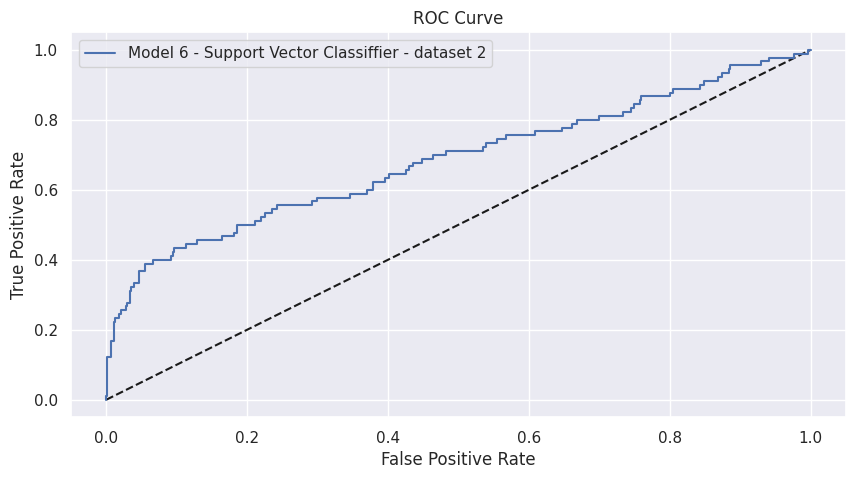

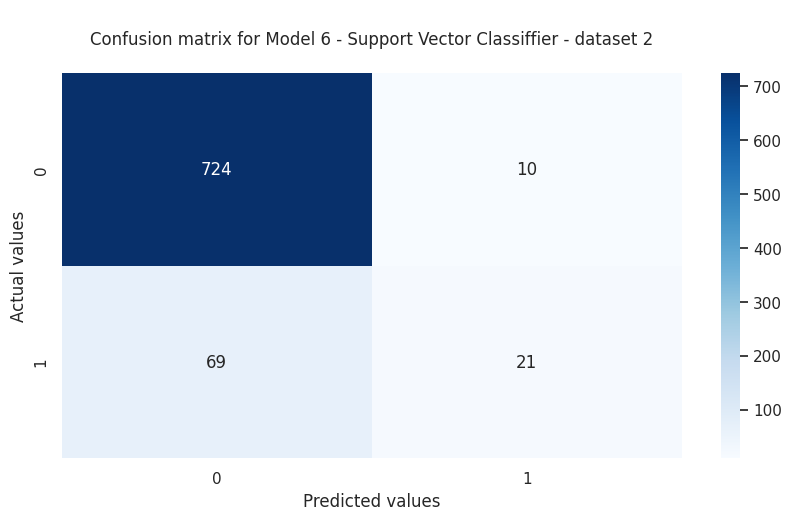

Model  F1_score       AUC
0                            Model 0 - Baseline RFC  0.295082  0.706668
1         Model 1 - Logistic Regression - dataset 1  0.443515  0.813896
2         Model 2 - Logistic Regression - dataset 2  0.380435  0.786088
3         Model 3 - Logistic Regression - dataset 3  0.402299  0.805767
4         Model 4 - Logistic Regression - dataset 4  0.413284  0.795777
5   Model 5 -Support Vector Classiffier - dataset 1  0.347107  0.761823
6  Model 6 - Support Vector Classiffier - dataset 2  0.347107  0.683409

In [228]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(svm_model_2, 'Model 6 - Support Vector Classiffier - dataset 2')

In [229]:
feature_importance = calculate_and_print_feature_importance_2(svm_model_2, X_test_2, y_test_2)
print(feature_importance)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0427 ± 0.0095  pdays
     0 ± 0.0000  month_year
     0 ± 0.0000  emp.var.rate
     0 ± 0.0000  poutcome
     0 ± 0.0000  previous
     0 ± 0.0000  campaign
     0 ± 0.0000  day_of_week
     0 ± 0.0000  contact
     0 ± 0.0000  loan
     0 ± 0.0000  housing
     0 ± 0.0000  education
     0 ± 0.0000  marital
     0 ± 0.0000  job
     0 ± 0.0000  age
None


## Model 7 - Support Vector Classifier () - zestaw 3

In [230]:
data_3.head()

age          job  marital          education housing loan    contact  \
0   30  blue-collar  married           basic.9y     yes   no   cellular   
1   39     services   single        high.school      no   no  telephone   
2   25     services  married        high.school     yes   no  telephone   
3   38     services  married           basic.9y     yes   no  telephone   
4   47       admin.  married  university.degree     yes   no   cellular   

  day_of_week  campaign  pdays  previous     poutcome month  cons.conf.idx  \
0         fri         2    999         0  nonexistent   may          -46.2   
1         fri         4    999         0  nonexistent   may          -36.4   
2         wed         1    999         0  nonexistent   jun          -41.8   
3         fri         3    999         0  nonexistent   jun          -41.8   
4         mon         1    999         0  nonexistent   nov          -42.0   

   emp.var.rate  
0          -1.8  
1           1.1  
2           1.4  
3           1.4  
4          -0.1

In [231]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

svm_pipeline_3 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_3),
        ('ordinal_transformer', ordinal_transformer, ord_feat_3),
        ('numeric_transformer', numeric_transformer, num_feat_3)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('svm_model_3', svm.SVC(probability=True))
])

In [232]:
svm_param_grid_3 = {
    'smote__sampling_strategy':
     [ 'all', 0.3, 0.5],
    'smote__k_neighbors':
     [3, 5],
    'svm_model_3__C':
     [0.001, 0.1, 1],
    'svm_model_3__kernel':
     ['linear', 'rbf', 'poly'],
    'svm_model_3__gamma':
     [0.001, 0.1]
}

In [ ]:
svm_search_3 = HalvingGridSearchCV(svm_pipeline_3,
                                 svm_param_grid_3,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

svm_search_3.fit(X_train_3, y_train_3)

In [234]:
print('\nBest hyperparameter:', svm_search_3.best_params_)


Best hyperparameter: {'smote__k_neighbors': 3, 'smote__sampling_strategy': 0.3, 'svm_model_3__C': 0.1, 'svm_model_3__gamma': 0.001, 'svm_model_3__kernel': 'linear'}


In [235]:
svm_model_3 = svm_search_3.best_estimator_

In [236]:
X_test_data = X_test_3
y_test_data = y_test_3

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       734
           1       0.68      0.23      0.35        90

    accuracy                           0.90       824
   macro avg       0.80      0.61      0.65       824
weighted avg       0.89      0.90      0.88       824



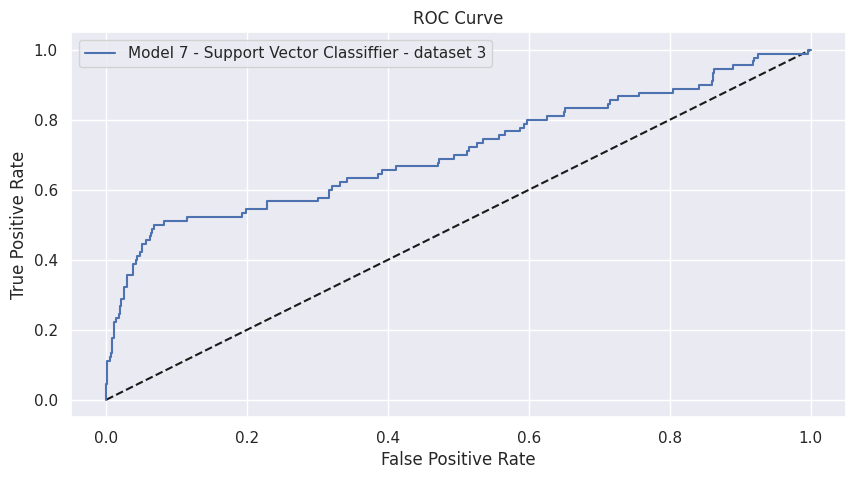

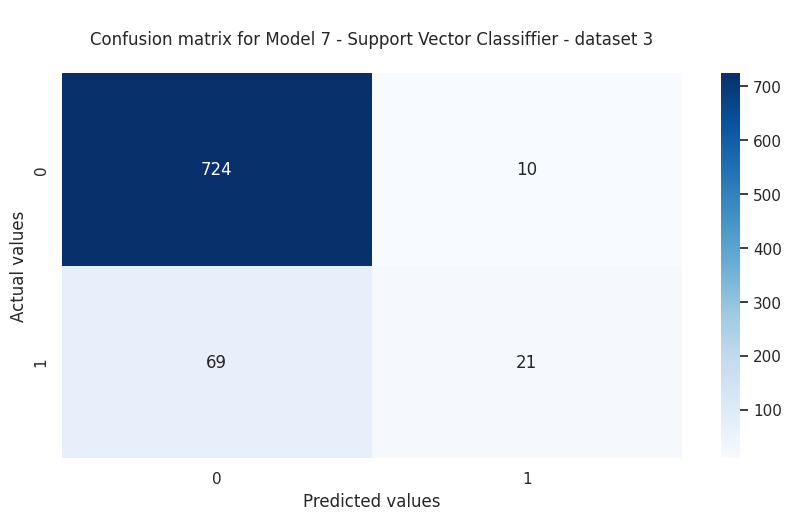

Model  F1_score       AUC
0                            Model 0 - Baseline RFC  0.295082  0.706668
1         Model 1 - Logistic Regression - dataset 1  0.443515  0.813896
2         Model 2 - Logistic Regression - dataset 2  0.380435  0.786088
3         Model 3 - Logistic Regression - dataset 3  0.402299  0.805767
4         Model 4 - Logistic Regression - dataset 4  0.413284  0.795777
5   Model 5 -Support Vector Classiffier - dataset 1  0.347107  0.761823
6  Model 6 - Support Vector Classiffier - dataset 2  0.347107  0.683409
7  Model 7 - Support Vector Classiffier - dataset 3  0.347107  0.708916

In [237]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(svm_model_3, 'Model 7 - Support Vector Classiffier - dataset 3')

In [238]:
feature_importance = calculate_and_print_feature_importance_2(svm_model_3, X_test_3, y_test_3)
print(feature_importance)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0413 ± 0.0069  pdays
     0 ± 0.0000  emp.var.rate
     0 ± 0.0000  cons.conf.idx
     0 ± 0.0000  month
     0 ± 0.0000  poutcome
     0 ± 0.0000  previous
     0 ± 0.0000  campaign
     0 ± 0.0000  day_of_week
     0 ± 0.0000  contact
     0 ± 0.0000  loan
     0 ± 0.0000  housing
     0 ± 0.0000  education
     0 ± 0.0000  marital
     0 ± 0.0000  job
     0 ± 0.0000  age
None


## Model 8 - Support Vector Classifier - zestaw 4

In [239]:
data_4.head()

age          job  marital          education housing loan    contact  \
0   30  blue-collar  married           basic.9y     yes   no   cellular   
1   39     services   single        high.school      no   no  telephone   
2   25     services  married        high.school     yes   no  telephone   
3   38     services  married           basic.9y     yes   no  telephone   
4   47       admin.  married  university.degree     yes   no   cellular   

  day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
0         fri         2    999         0  nonexistent          -1.8   
1         fri         4    999         0  nonexistent           1.1   
2         wed         1    999         0  nonexistent           1.4   
3         fri         3    999         0  nonexistent           1.4   
4         mon         1    999         0  nonexistent          -0.1   

   cons.conf.idx month_year  
0          -46.2   may_2009  
1          -36.4   may_2008  
2          -41.8   jun_2008  
3          -41.8   jun_2008  
4          -42.0   nov_2008

In [240]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

svm_pipeline_4 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_4),
        ('ordinal_transformer', ordinal_transformer, ord_feat_4),
        ('numeric_transformer', numeric_transformer, num_feat_4)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('svm_model_4', svm.SVC(probability=True))
])


In [241]:
svm_param_grid_4 = {
    'smote__sampling_strategy':
     [0.3, 0.5, 0.8],
    'smote__k_neighbors':
     [3, 5],
    'svm_model_4__C':
     [0.001, 0.1],
    'svm_model_4__kernel':
     ['linear', 'rbf', 'poly'],
    'svm_model_4__gamma':
     [0.001, 0.01, 0.1]
}

In [ ]:
svm_search_4 = HalvingGridSearchCV(svm_pipeline_4,
                                 svm_param_grid_4,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

svm_search_4.fit(X_train_4, y_train_4)

In [243]:
print('\nBest hyperparameter:', svm_search_4.best_params_)


Best hyperparameter: {'smote__k_neighbors': 3, 'smote__sampling_strategy': 0.5, 'svm_model_4__C': 0.001, 'svm_model_4__gamma': 0.1, 'svm_model_4__kernel': 'linear'}


In [244]:
svm_model_4 = svm_search_4.best_estimator_

In [245]:
X_test_data = X_test_4
y_test_data = y_test_4

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       734
           1       0.68      0.23      0.35        90

    accuracy                           0.90       824
   macro avg       0.80      0.61      0.65       824
weighted avg       0.89      0.90      0.88       824



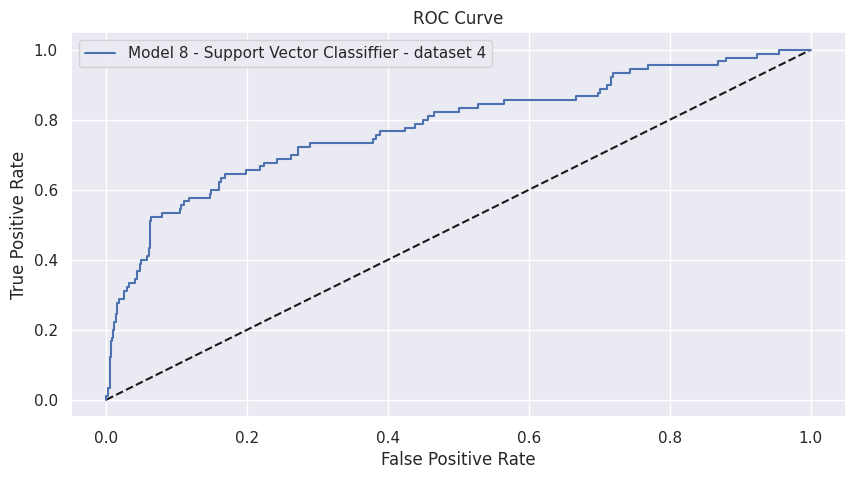

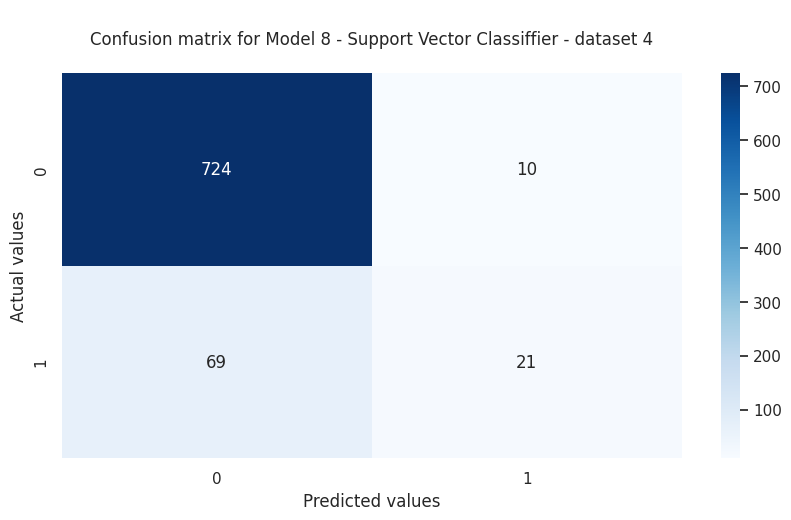

Model  F1_score       AUC
0                            Model 0 - Baseline RFC  0.295082  0.706668
1         Model 1 - Logistic Regression - dataset 1  0.443515  0.813896
2         Model 2 - Logistic Regression - dataset 2  0.380435  0.786088
3         Model 3 - Logistic Regression - dataset 3  0.402299  0.805767
4         Model 4 - Logistic Regression - dataset 4  0.413284  0.795777
5   Model 5 -Support Vector Classiffier - dataset 1  0.347107  0.761823
6  Model 6 - Support Vector Classiffier - dataset 2  0.347107  0.683409
7  Model 7 - Support Vector Classiffier - dataset 3  0.347107  0.708916
8  Model 8 - Support Vector Classiffier - dataset 4  0.347107  0.780321

In [246]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(svm_model_4, 'Model 8 - Support Vector Classiffier - dataset 4')

In [247]:
feature_importance = calculate_and_print_feature_importance_2(svm_model_4, X_test_4, y_test_4)
print(feature_importance)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0413 ± 0.0069  pdays
     0 ± 0.0000  month_year
     0 ± 0.0000  cons.conf.idx
     0 ± 0.0000  emp.var.rate
     0 ± 0.0000  poutcome
     0 ± 0.0000  previous
     0 ± 0.0000  campaign
     0 ± 0.0000  day_of_week
     0 ± 0.0000  contact
     0 ± 0.0000  loan
     0 ± 0.0000  housing
     0 ± 0.0000  education
     0 ± 0.0000  marital
     0 ± 0.0000  job
     0 ± 0.0000  age
None


## Model 9 - XGBoost() - zestaw 1

In [248]:
data.head()

age          job  marital          education housing loan    contact month  \
0   30  blue-collar  married           basic.9y     yes   no   cellular   may   
1   39     services   single        high.school      no   no  telephone   may   
2   25     services  married        high.school     yes   no  telephone   jun   
3   38     services  married           basic.9y     yes   no  telephone   jun   
4   47       admin.  married  university.degree     yes   no   cellular   nov   

  day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
0         fri         2    999         0  nonexistent          -1.8   
1         fri         4    999         0  nonexistent           1.1   
2         wed         1    999         0  nonexistent           1.4   
3         fri         3    999         0  nonexistent           1.4   
4         mon         1    999         0  nonexistent          -0.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed  
0          92.893          -46.2      1.313       5099.1  
1          93.994          -36.4      4.855       5191.0  
2          94.465          -41.8      4.962       5228.1  
3          94.465          -41.8      4.959       5228.1  
4          93.200          -42.0      4.191       5195.8

In [249]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])


xgb_pipeline = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat),
        ('ordinal_transformer', ordinal_transformer, ord_feat),
        ('numeric_transformer', numeric_transformer, num_feat)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('xgb_model', XGBClassifier(verbosity=0))
])

In [250]:
xgb_param_grid = {
    'smote__sampling_strategy':
     ['minority', 'all', 0.3, 0.5],
    'smote__k_neighbors':
     [3, 5, 7],
    'xgb_model__n_estimators': [50, 100, 150],
    'xgb_model__max_depth': [2, 18, 25, 35],
    'xgb_model__learning_rate': [0.1, 0.01, 0.001],
    'xgb_model__gamma': [ 0.0001, 0.001, 0.01, 0.1]
}

In [ ]:
xgb_search = HalvingGridSearchCV(xgb_pipeline,
                                 xgb_param_grid,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

xgb_search.fit(X_train, y_train)

In [252]:
print('\nBest hyperparameters:', xgb_search.best_params_)
xgb_model = xgb_search.best_estimator_


Best hyperparameters: {'smote__k_neighbors': 5, 'smote__sampling_strategy': 'all', 'xgb_model__gamma': 0.0001, 'xgb_model__learning_rate': 0.1, 'xgb_model__max_depth': 18, 'xgb_model__n_estimators': 100}


In [253]:
X_test_data = X_test
y_test_data = y_test

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       734
           1       0.55      0.34      0.42        90

    accuracy                           0.90       824
   macro avg       0.74      0.66      0.68       824
weighted avg       0.88      0.90      0.89       824



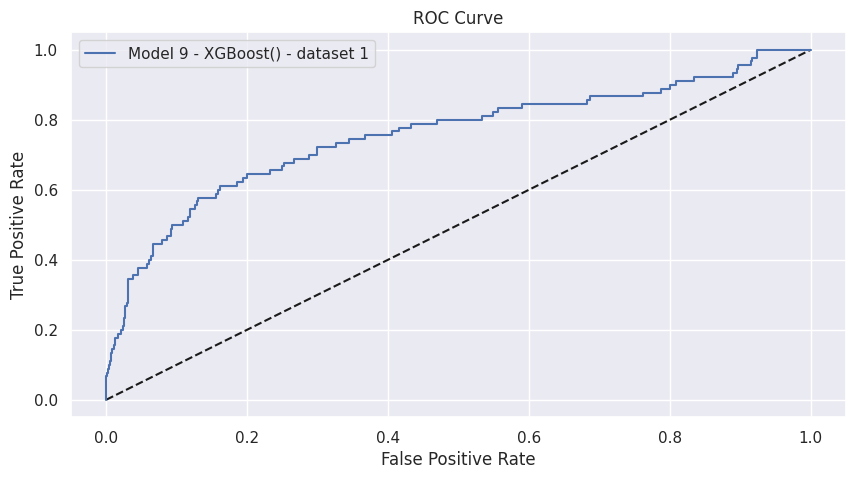

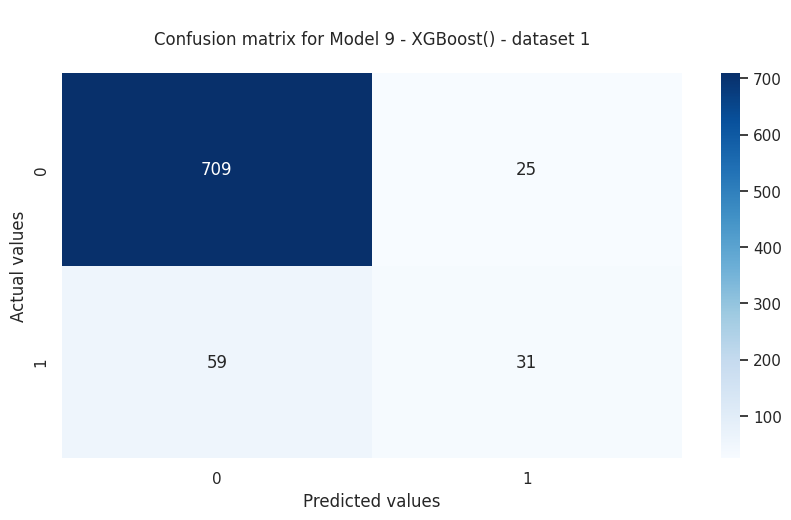

Model  F1_score       AUC
0                            Model 0 - Baseline RFC  0.295082  0.706668
1         Model 1 - Logistic Regression - dataset 1  0.443515  0.813896
2         Model 2 - Logistic Regression - dataset 2  0.380435  0.786088
3         Model 3 - Logistic Regression - dataset 3  0.402299  0.805767
4         Model 4 - Logistic Regression - dataset 4  0.413284  0.795777
5   Model 5 -Support Vector Classiffier - dataset 1  0.347107  0.761823
6  Model 6 - Support Vector Classiffier - dataset 2  0.347107  0.683409
7  Model 7 - Support Vector Classiffier - dataset 3  0.347107  0.708916
8  Model 8 - Support Vector Classiffier - dataset 4  0.347107  0.780321
9                   Model 9 - XGBoost() - dataset 1  0.424658  0.756252

In [254]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(xgb_model, 'Model 9 - XGBoost() - dataset 1')

In [255]:
feature_importance = calculate_and_print_feature_importance_2(xgb_model, X_test , y_test )
print(feature_importance)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0211 ± 0.0075  nr.employed
0.0119 ± 0.0071  age
0.0112 ± 0.0077  day_of_week
0.0075 ± 0.0069  marital
0.0070 ± 0.0036  housing
0.0051 ± 0.0052  education
0.0039 ± 0.0032  contact
0.0039 ± 0.0018  pdays
0.0032 ± 0.0059  month
0.0029 ± 0.0033  emp.var.rate
0.0022 ± 0.0066  campaign
0.0019 ± 0.0039  job
0.0012 ± 0.0027  loan
0.0005 ± 0.0039  cons.price.idx
     0 ± 0.0000  previous
-0.0007 ± 0.0039  euribor3m
-0.0010 ± 0.0028  poutcome
-0.0012 ± 0.0065  cons.conf.idx
None


## Model 10 - XGBoost() - zestaw 2

In [256]:
data_2.head()

age          job  marital          education housing loan    contact  \
0   30  blue-collar  married           basic.9y     yes   no   cellular   
1   39     services   single        high.school      no   no  telephone   
2   25     services  married        high.school     yes   no  telephone   
3   38     services  married           basic.9y     yes   no  telephone   
4   47       admin.  married  university.degree     yes   no   cellular   

  day_of_week  campaign  pdays  previous     poutcome  emp.var.rate month_year  
0         fri         2    999         0  nonexistent          -1.8   may_2009  
1         fri         4    999         0  nonexistent           1.1   may_2008  
2         wed         1    999         0  nonexistent           1.4   jun_2008  
3         fri         3    999         0  nonexistent           1.4   jun_2008  
4         mon         1    999         0  nonexistent          -0.1   nov_2008

In [257]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

xgb_pipeline_2 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_2),
        ('ordinal_transformer', ordinal_transformer, ord_feat_2),
        ('numeric_transformer', numeric_transformer, num_feat_2)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('xgb_model_2', XGBClassifier(verbosity=0))
])


In [258]:
xgb_param_grid_2 = {
    'smote__sampling_strategy':
     ['minority', 'all', 0.3, 0.5, 0.8],
    'smote__k_neighbors':
     [3, 5, 7],
    'xgb_model_2__n_estimators': [50, 100, 150],
    'xgb_model_2__max_depth': [3, 6, 12],
    'xgb_model_2__learning_rate': [0.1, 0.01, 0.001],
    'xgb_model_2__gamma': [0.0001, 0.001, 0.01]
}

In [ ]:
xgb_search_2 = HalvingGridSearchCV(xgb_pipeline_2,
                                 xgb_param_grid_2,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

xgb_search_2.fit(X_train_2, y_train_2)

In [260]:
print('\nBest hyperparameters:', xgb_search_2.best_params_)


Best hyperparameters: {'smote__k_neighbors': 5, 'smote__sampling_strategy': 0.3, 'xgb_model_2__gamma': 0.0001, 'xgb_model_2__learning_rate': 0.1, 'xgb_model_2__max_depth': 6, 'xgb_model_2__n_estimators': 100}


In [261]:
xgb_model_2 = xgb_search_2.best_estimator_

In [262]:
X_test_data = X_test_2
y_test_data = y_test_2

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       734
           1       0.61      0.30      0.40        90

    accuracy                           0.90       824
   macro avg       0.77      0.64      0.68       824
weighted avg       0.89      0.90      0.89       824



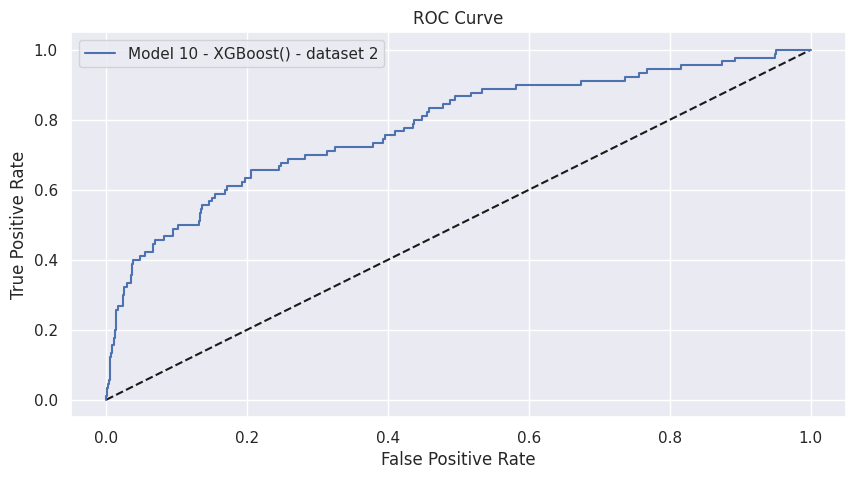

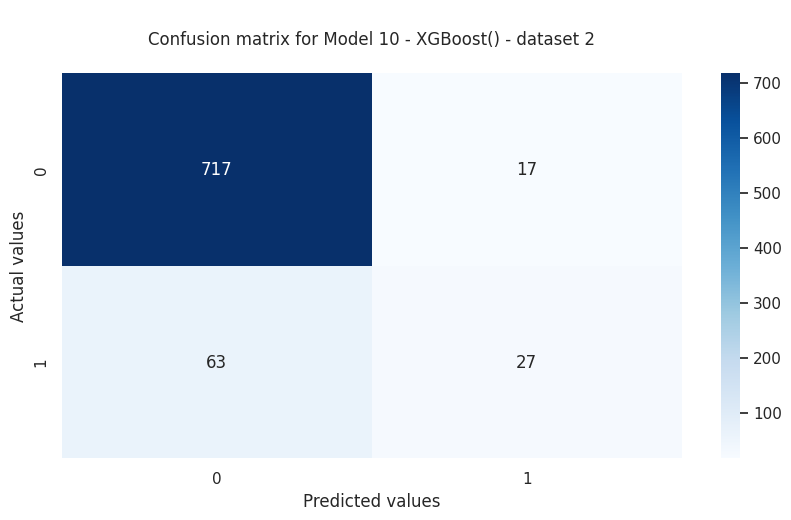

Model  F1_score       AUC
0                             Model 0 - Baseline RFC  0.295082  0.706668
1          Model 1 - Logistic Regression - dataset 1  0.443515  0.813896
2          Model 2 - Logistic Regression - dataset 2  0.380435  0.786088
3          Model 3 - Logistic Regression - dataset 3  0.402299  0.805767
4          Model 4 - Logistic Regression - dataset 4  0.413284  0.795777
5    Model 5 -Support Vector Classiffier - dataset 1  0.347107  0.761823
6   Model 6 - Support Vector Classiffier - dataset 2  0.347107  0.683409
7   Model 7 - Support Vector Classiffier - dataset 3  0.347107  0.708916
8   Model 8 - Support Vector Classiffier - dataset 4  0.347107  0.780321
9                    Model 9 - XGBoost() - dataset 1  0.424658  0.756252
10                  Model 10 - XGBoost() - dataset 2  0.402985  0.778641

In [263]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(xgb_model_2, 'Model 10 - XGBoost() - dataset 2')

In [264]:
feature_importance = calculate_and_print_feature_importance_2(xgb_model_2, X_test_2 , y_test_2 )
print(feature_importance)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0235 ± 0.0104  emp.var.rate
0.0092 ± 0.0098  month_year
0.0092 ± 0.0045  age
0.0046 ± 0.0028  pdays
0.0044 ± 0.0042  contact
0.0024 ± 0.0059  education
0.0022 ± 0.0024  loan
0.0019 ± 0.0059  marital
0.0002 ± 0.0010  previous
0.0000 ± 0.0034  job
-0.0007 ± 0.0050  housing
-0.0015 ± 0.0042  poutcome
-0.0024 ± 0.0034  campaign
-0.0024 ± 0.0059  day_of_week
None


## Model 11 - XGBoost() - zestaw 3

In [265]:
data_3.head()

age          job  marital          education housing loan    contact  \
0   30  blue-collar  married           basic.9y     yes   no   cellular   
1   39     services   single        high.school      no   no  telephone   
2   25     services  married        high.school     yes   no  telephone   
3   38     services  married           basic.9y     yes   no  telephone   
4   47       admin.  married  university.degree     yes   no   cellular   

  day_of_week  campaign  pdays  previous     poutcome month  cons.conf.idx  \
0         fri         2    999         0  nonexistent   may          -46.2   
1         fri         4    999         0  nonexistent   may          -36.4   
2         wed         1    999         0  nonexistent   jun          -41.8   
3         fri         3    999         0  nonexistent   jun          -41.8   
4         mon         1    999         0  nonexistent   nov          -42.0   

   emp.var.rate  
0          -1.8  
1           1.1  
2           1.4  
3           1.4  
4          -0.1

In [266]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

xgb_pipeline_3 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_3),
        ('ordinal_transformer', ordinal_transformer, ord_feat_3),
        ('numeric_transformer', numeric_transformer, num_feat_3)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('xgb_model_3', XGBClassifier(verbosity=0))
])

In [267]:
xgb_param_grid_3 = {
    'smote__sampling_strategy':
     ['minority', 'all', 0.3, 0.5, 0.8],
    'smote__k_neighbors':
     [3, 5, 7],
    'xgb_model_3__n_estimators': [100, 150, 200],
    'xgb_model_3__max_depth': [6, 12, 20],
    'xgb_model_3__learning_rate': [0.01, 0.001, 0.0001],
    'xgb_model_3__gamma': [0.001, 0.01, 0.1]
}

In [ ]:
xgb_search_3 = HalvingGridSearchCV(xgb_pipeline_3,
                                 xgb_param_grid_3,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

xgb_search_3.fit(X_train_3, y_train_3)

In [269]:
print('\nBest hyperparameters:', xgb_search_3.best_params_)
xgb_model_3 = xgb_search_3.best_estimator_


Best hyperparameters: {'smote__k_neighbors': 3, 'smote__sampling_strategy': 'all', 'xgb_model_3__gamma': 0.01, 'xgb_model_3__learning_rate': 0.01, 'xgb_model_3__max_depth': 20, 'xgb_model_3__n_estimators': 200}


In [270]:
X_test_data = X_test_3
y_test_data = y_test_3

              precision    recall  f1-score   support

           0       0.92      0.95      0.94       734
           1       0.48      0.37      0.42        90

    accuracy                           0.89       824
   macro avg       0.70      0.66      0.68       824
weighted avg       0.88      0.89      0.88       824



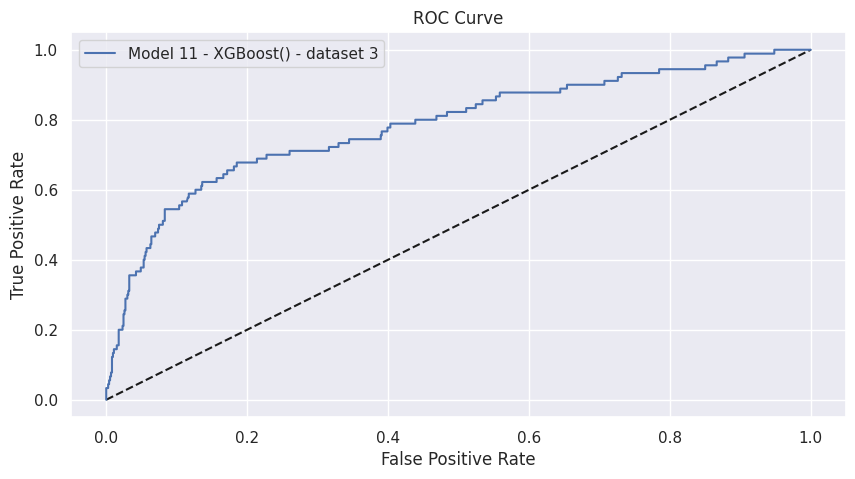

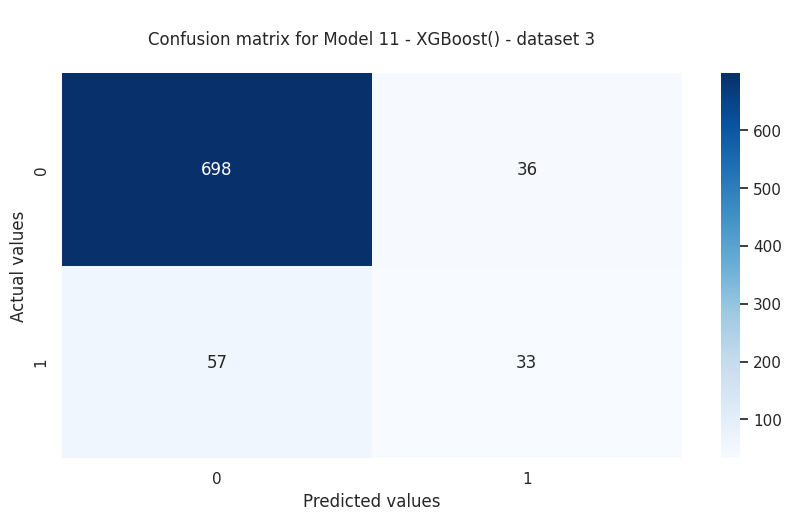

Model  F1_score       AUC
0                             Model 0 - Baseline RFC  0.295082  0.706668
1          Model 1 - Logistic Regression - dataset 1  0.443515  0.813896
2          Model 2 - Logistic Regression - dataset 2  0.380435  0.786088
3          Model 3 - Logistic Regression - dataset 3  0.402299  0.805767
4          Model 4 - Logistic Regression - dataset 4  0.413284  0.795777
5    Model 5 -Support Vector Classiffier - dataset 1  0.347107  0.761823
6   Model 6 - Support Vector Classiffier - dataset 2  0.347107  0.683409
7   Model 7 - Support Vector Classiffier - dataset 3  0.347107  0.708916
8   Model 8 - Support Vector Classiffier - dataset 4  0.347107  0.780321
9                    Model 9 - XGBoost() - dataset 1  0.424658  0.756252
10                  Model 10 - XGBoost() - dataset 2  0.402985  0.778641
11                  Model 11 - XGBoost() - dataset 3  0.415094  0.784340

In [271]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(xgb_model_3, 'Model 11 - XGBoost() - dataset 3')

In [272]:
feature_importance = calculate_and_print_feature_importance_2(xgb_model_3, X_test_3 , y_test_3)
print(feature_importance)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.1051 ± 0.0098  cons.conf.idx
0.1036 ± 0.0113  emp.var.rate
0.0114 ± 0.0061  month
0.0073 ± 0.0038  pdays
0.0049 ± 0.0043  marital
0.0036 ± 0.0053  campaign
0.0029 ± 0.0039  poutcome
0.0027 ± 0.0095  contact
     0 ± 0.0000  previous
-0.0000 ± 0.0015  loan
-0.0017 ± 0.0066  job
-0.0032 ± 0.0052  age
-0.0032 ± 0.0073  day_of_week
-0.0095 ± 0.0054  housing
-0.0095 ± 0.0066  education
None


## Model 12 - XGBoost() - zestaw  4

In [273]:
data_4.head()

age          job  marital          education housing loan    contact  \
0   30  blue-collar  married           basic.9y     yes   no   cellular   
1   39     services   single        high.school      no   no  telephone   
2   25     services  married        high.school     yes   no  telephone   
3   38     services  married           basic.9y     yes   no  telephone   
4   47       admin.  married  university.degree     yes   no   cellular   

  day_of_week  campaign  pdays  previous     poutcome  emp.var.rate  \
0         fri         2    999         0  nonexistent          -1.8   
1         fri         4    999         0  nonexistent           1.1   
2         wed         1    999         0  nonexistent           1.4   
3         fri         3    999         0  nonexistent           1.4   
4         mon         1    999         0  nonexistent          -0.1   

   cons.conf.idx month_year  
0          -46.2   may_2009  
1          -36.4   may_2008  
2          -41.8   jun_2008  
3          -41.8   jun_2008  
4          -42.0   nov_2008

In [274]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

xgb_pipeline_4 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_4),
        ('ordinal_transformer', ordinal_transformer, ord_feat_4),
        ('numeric_transformer', numeric_transformer, num_feat_4)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('xgb_model_4', XGBClassifier(verbosity=0))
])

In [275]:
xgb_param_grid_4 = {
    'smote__sampling_strategy':
     ['minority', 'all', 0.3, 0.5, 0.8],
    'smote__k_neighbors':
     [3, 5, 7],
    'xgb_model_4__n_estimators': [50, 100, 150],
    'xgb_model_4__max_depth': [6, 12, 20],
    'xgb_model_4__learning_rate': [0.1, 0.01, 0.001],
    'xgb_model_4__gamma': [0.001, 0.01, 0.1]
}

In [ ]:
xgb_search_4 = HalvingGridSearchCV(xgb_pipeline_4,
                                 xgb_param_grid_4,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

xgb_search_4.fit(X_train_4, y_train_4)

n_iterations: 5
n_required_iterations: 7
n_possible_iterations: 5
min_resources_: 40
max_resources_: 3295
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1215
n_resources: 40
Fitting 10 folds for each of 1215 candidates, totalling 12150 fits
----------
iter: 1
n_candidates: 405
n_resources: 120
Fitting 10 folds for each of 405 candidates, totalling 4050 fits
----------
iter: 2
n_candidates: 135
n_resources: 360
Fitting 10 folds for each of 135 candidates, totalling 1350 fits
----------
iter: 3
n_candidates: 45
n_resources: 1080
Fitting 10 folds for each of 45 candidates, totalling 450 fits
----------
iter: 4
n_candidates: 15
n_resources: 3240
Fitting 10 folds for each of 15 candidates, totalling 150 fits


In [ ]:
print('\nBest hyperparameters:', xgb_search_4.best_params_)
xgb_model_4 = xgb_search_4.best_estimator_

In [ ]:
X_test_data = X_test_4
y_test_data = y_test_4

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(xgb_model_4, 'Model 12 - XGBoost() - dataset_4')

In [ ]:
feature_importance = calculate_and_print_feature_importance_2(xgb_model_4, X_test_4 , y_test_4)
print(feature_importance)

## Model 13 - Logistic Regression zestaw danych 5

In [ ]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_5),
        ('ordinal_transformer', ordinal_transformer, ord_feat_5),
        ('numeric_transformer', numeric_transformer, num_feat_5)
    ]
)

lr_pipeline_5 = Pipeline_imb(steps=[('preprocessor', preprocessor),
                              ('smote', SMOTE(random_state=seed)),
                              ('lr_model_5', LogisticRegression(random_state=seed))])

In [ ]:
lr_param_grid_5 = {
    'smote__sampling_strategy': ['minority', 'all', 0.3, 0.5, 0.8],
    'smote__k_neighbors': [3, 4, 5],
    'lr_model_5__C': [0.001, 0.01, 0.1],
    'lr_model_5__penalty': [ 'l1', 'l2', 'none'],
    'lr_model_5__max_iter': [25, 50, 100],
}

In [ ]:
lr_model_5_gridsearch = HalvingGridSearchCV(estimator = lr_pipeline_5,
                                       param_grid = lr_param_grid_5,
                                       scoring='f1_weighted',
                                       cv=10,
                                       verbose=1,
                                       n_jobs=-1,
                                       random_state=seed,
                                       refit=True)

lr_model_5_gridsearch.fit(X_train_5, y_train_5)

In [ ]:
lr_model_5 = lr_model_5_gridsearch.best_estimator_

In [ ]:
X_test_data = X_test_5
y_test_data = y_test_5

In [ ]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(lr_model_5, 'Model 13 - Logistic Regression - dataset 5')

In [296]:
feature_importance = calculate_and_print_feature_importance_2(lr_model_5, X_test_5 , y_test_5)
print(feature_importance)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0102 ± 0.0030  pdays
0.0097 ± 0.0043  poutcome
0.0045 ± 0.0043  previous
0.0023 ± 0.0054  emp.var.rate
0.0015 ± 0.0024  month_year
0.0010 ± 0.0047  contact
0.0010 ± 0.0037  age
-0.0002 ± 0.0028  loan
-0.0003 ± 0.0030  day_of_week
-0.0015 ± 0.0019  marital
-0.0018 ± 0.0031  education
-0.0018 ± 0.0057  job
-0.0023 ± 0.0033  housing
-0.0031 ± 0.0024  cons.conf.idx
-0.0031 ± 0.0024  campaign
None


## Model 14 - Support Vector Classifier - zestaw 5

In [297]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

svm_pipeline_5 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_5),
        ('ordinal_transformer', ordinal_transformer, ord_feat_5),
        ('numeric_transformer', numeric_transformer, num_feat_5)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('svm_model_5', svm.SVC(probability=True))
])

In [298]:
svm_param_grid_5 = {
    'smote__sampling_strategy':
     ['minority', 0.3, 0.5, 0.8],
    'smote__k_neighbors':
     [2, 4],
    'svm_model_5__C':
     [0.001, 0.01, 0.1, 1],
    'svm_model_5__kernel':
     ['linear', 'rbf', 'poly'],
    'svm_model_5__gamma':
     ['scale', 0.001, 0.01]
}

In [ ]:
svm_search_5 = HalvingGridSearchCV(svm_pipeline_5,
                                 svm_param_grid_5,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

svm_search_5.fit(X_train_5, y_train_5)

In [300]:
print('\nBest hyperparameter:', svm_search_5.best_params_)


Best hyperparameter: {'smote__k_neighbors': 2, 'smote__sampling_strategy': 0.5, 'svm_model_5__C': 0.001, 'svm_model_5__gamma': 0.001, 'svm_model_5__kernel': 'linear'}


In [301]:
svm_model_5 = svm_search_5.best_estimator_

In [302]:
X_test_data = X_test_5
y_test_data = y_test_5

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      1101
           1       0.43      0.50      0.46       135

    accuracy                           0.87      1236
   macro avg       0.68      0.71      0.69      1236
weighted avg       0.88      0.87      0.88      1236



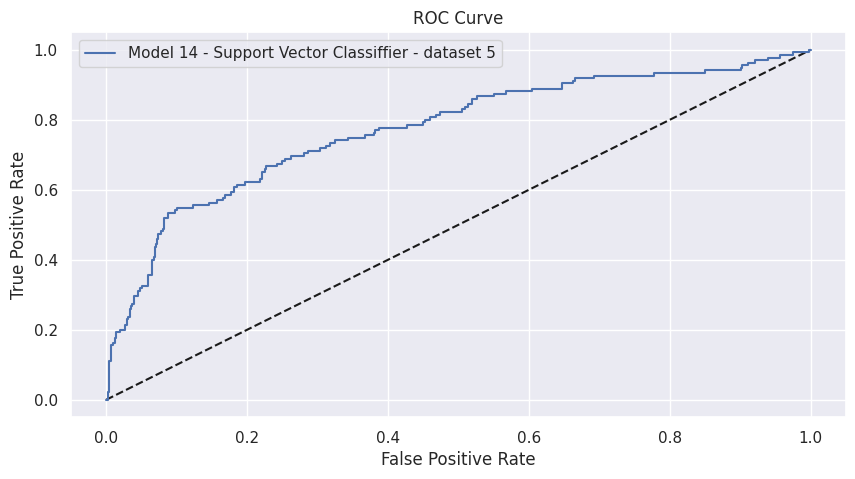

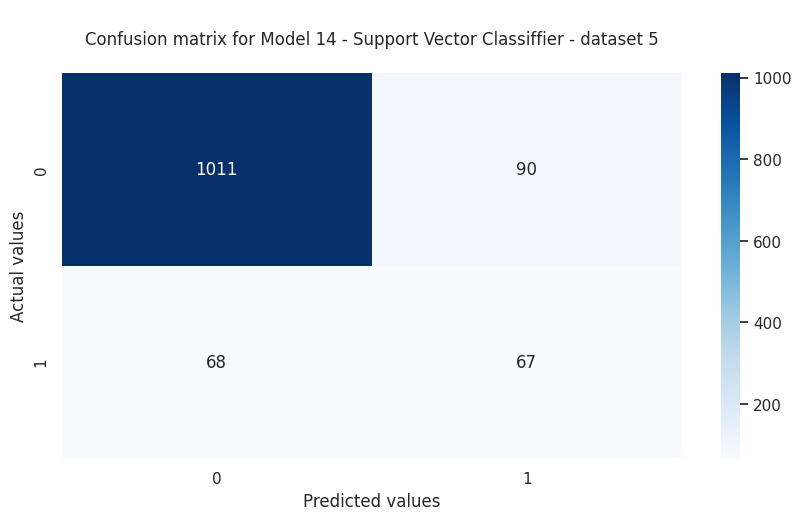

Model  F1_score       AUC
0                              Model 0 - Baseline RFC  0.295082  0.706668
1           Model 1 - Logistic Regression - dataset 1  0.443515  0.813896
2           Model 2 - Logistic Regression - dataset 2  0.380435  0.786088
3           Model 3 - Logistic Regression - dataset 3  0.402299  0.805767
4           Model 4 - Logistic Regression - dataset 4  0.413284  0.795777
5     Model 5 -Support Vector Classiffier - dataset 1  0.347107  0.761823
6    Model 6 - Support Vector Classiffier - dataset 2  0.347107  0.683409
7    Model 7 - Support Vector Classiffier - dataset 3  0.347107  0.708916
8    Model 8 - Support Vector Classiffier - dataset 4  0.347107  0.780321
9                     Model 9 - XGBoost() - dataset 1  0.424658  0.756252
10                   Model 10 - XGBoost() - dataset 2  0.402985  0.778641
11                   Model 11 - XGBoost() - dataset 3  0.415094  0.784340
12                   Model 12 - XGBoost() - dataset_4  0.312500  0.771919
13         Model 13 - Logistic Regression - dataset 5  0.368932  0.775780
14  Model 14 - Support Vector Classiffier - dataset 5  0.458904  0.772691

In [303]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(svm_model_5, 'Model 14 - Support Vector Classiffier - dataset 5')

In [304]:
feature_importance = calculate_and_print_feature_importance_2(svm_model_5, X_test_5 , y_test_5)
print(feature_importance)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0709 ± 0.0110  emp.var.rate
0.0406 ± 0.0102  cons.conf.idx
0.0163 ± 0.0058  pdays
0.0026 ± 0.0012  poutcome
0.0018 ± 0.0033  age
0.0006 ± 0.0016  previous
0.0003 ± 0.0038  contact
0.0003 ± 0.0042  job
-0.0002 ± 0.0026  housing
-0.0013 ± 0.0024  marital
-0.0016 ± 0.0029  education
-0.0019 ± 0.0017  month_year
-0.0024 ± 0.0027  campaign
-0.0024 ± 0.0018  loan
-0.0028 ± 0.0017  day_of_week
None


## Model 15 - XGBoost() - zestaw 5

In [318]:
categorical_transformer = Pipeline_imb(steps=[
    ('ohe', preprocessing.OneHotEncoder())
])

ordinal_transformer = Pipeline_imb(steps=[
    ('label_encoder', LabelEncoderTransformer())
])

numeric_transformer = Pipeline_imb(steps=[
    ('scaler', StandardScaler())
])

xgb_pipeline_5 = Pipeline_imb([
    ('preprocessor', ColumnTransformer(transformers=[
        ('categorical_transformer', categorical_transformer, cat_feat_5),
        ('ordinal_transformer', ordinal_transformer, ord_feat_5),
        ('numeric_transformer', numeric_transformer, num_feat_5)
    ])),
    ('smote', SMOTE(random_state=seed)),
    ('xgb_model_5', XGBClassifier(verbosity=0))
])


In [319]:
xgb_param_grid_5 = {
    'smote__sampling_strategy': ['minority', 'all',  0.5, 0.8],
    'smote__k_neighbors': [2, 3],
    'xgb_model_5__n_estimators': [50, 100, 150],
    'xgb_model_5__max_depth': [15, 20, 25],
    'xgb_model_5__learning_rate': [0.1, 0.01, 0.001],
    'xgb_model_5__gamma': [0.001, 0.01, 0.1, 0.3]
}

In [ ]:
xgb_search_5 = HalvingGridSearchCV(xgb_pipeline_5,
                                 xgb_param_grid_5,
                                 scoring='f1_weighted',
                                 cv=10,
                                 verbose=1,
                                 n_jobs=-1,
                                 random_state=seed)

xgb_search_5.fit(X_train_5, y_train_5)

In [321]:
print('\nBest hyperparameters:', xgb_search_5.best_params_)


Best hyperparameters: {'smote__k_neighbors': 2, 'smote__sampling_strategy': 0.5, 'xgb_model_5__gamma': 0.3, 'xgb_model_5__learning_rate': 0.1, 'xgb_model_5__max_depth': 20, 'xgb_model_5__n_estimators': 100}


In [322]:
xgb_model_5 = xgb_search_5.best_estimator_

In [323]:
X_test_data = X_test_5
y_test_data = y_test_5

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1101
           1       0.45      0.28      0.35       135

    accuracy                           0.88      1236
   macro avg       0.68      0.62      0.64      1236
weighted avg       0.87      0.88      0.87      1236



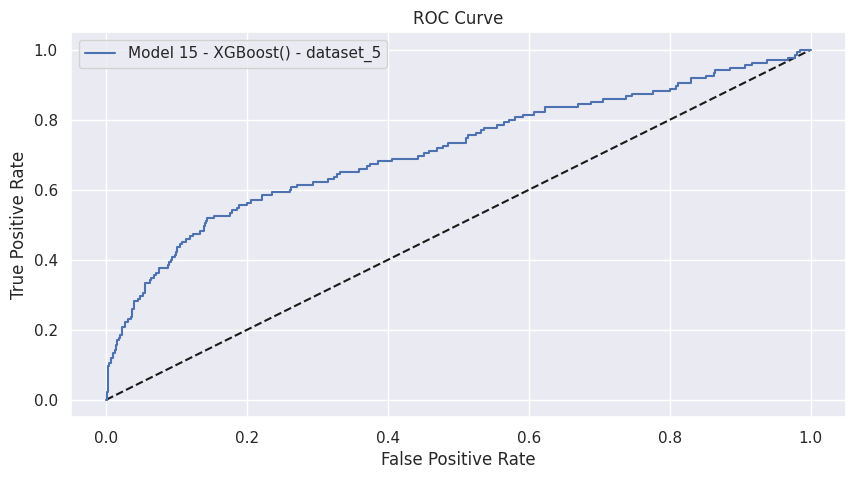

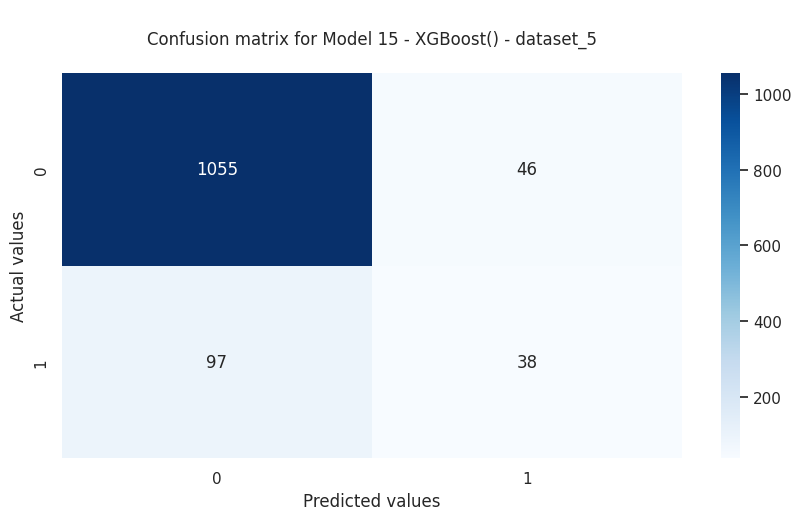

Model  F1_score       AUC
0                              Model 0 - Baseline RFC  0.295082  0.706668
1           Model 1 - Logistic Regression - dataset 1  0.443515  0.813896
2           Model 2 - Logistic Regression - dataset 2  0.380435  0.786088
3           Model 3 - Logistic Regression - dataset 3  0.402299  0.805767
4           Model 4 - Logistic Regression - dataset 4  0.413284  0.795777
5     Model 5 -Support Vector Classiffier - dataset 1  0.347107  0.761823
6    Model 6 - Support Vector Classiffier - dataset 2  0.347107  0.683409
7    Model 7 - Support Vector Classiffier - dataset 3  0.347107  0.708916
8    Model 8 - Support Vector Classiffier - dataset 4  0.347107  0.780321
9                     Model 9 - XGBoost() - dataset 1  0.424658  0.756252
10                   Model 10 - XGBoost() - dataset 2  0.402985  0.778641
11                   Model 11 - XGBoost() - dataset 3  0.415094  0.784340
12                   Model 12 - XGBoost() - dataset_4  0.312500  0.771919
13         Model 13 - Logistic Regression - dataset 5  0.368932  0.775780
14  Model 14 - Support Vector Classiffier - dataset 5  0.458904  0.772691
15                   Model 15 - XGBoost() - dataset_5  0.347032  0.711622

In [324]:
sns.set(rc={"figure.figsize":(10, 5)})
calculation_metrics(xgb_model_5, 'Model 15 - XGBoost() - dataset_5')

In [325]:
feature_importance = calculate_and_print_feature_importance_2(xgb_model_5, X_test_5 , y_test_5)
print(feature_importance)

Explained as: feature importances

Feature importances, computed as a decrease in score when feature
values are permuted (i.e. become noise). This is also known as 
permutation importance.

If feature importances are computed on the same data as used for training, 
they don't reflect importance of features for generalization. Use a held-out
dataset if you want generalization feature importances.

0.0665 ± 0.0055  emp.var.rate
0.0663 ± 0.0020  cons.conf.idx
0.0076 ± 0.0030  marital
0.0049 ± 0.0062  day_of_week
0.0029 ± 0.0019  pdays
0.0024 ± 0.0061  contact
0.0019 ± 0.0008  previous
0.0018 ± 0.0067  campaign
0.0013 ± 0.0036  poutcome
0.0011 ± 0.0076  education
0.0010 ± 0.0012  housing
-0.0003 ± 0.0043  age
-0.0016 ± 0.0047  month_year
-0.0023 ± 0.0019  loan
-0.0045 ± 0.0033  job
None


# Wyniki zbiorcze

In [329]:
top_5_auc_models = metrics_dataframe.sort_values(by=['AUC', 'F1_score'], ascending=False).head(5)
top_5_auc_models

Model  F1_score       AUC
1   Model 1 - Logistic Regression - dataset 1  0.443515  0.813896
3   Model 3 - Logistic Regression - dataset 3  0.402299  0.805767
4   Model 4 - Logistic Regression - dataset 4  0.413284  0.795777
2   Model 2 - Logistic Regression - dataset 2  0.380435  0.786088
11           Model 11 - XGBoost() - dataset 3  0.415094  0.784340

In [330]:
models = [lr_model, lr_model_3, lr_model_4, lr_model_2, lr_model]
model_names = top_5_auc_models['Model']

X_test_data_end = [X_test, X_test_3, X_test_4, X_test_2, X_test]
y_test_data_end = [y_test, y_test_3, y_test_4, y_test_2, y_test]

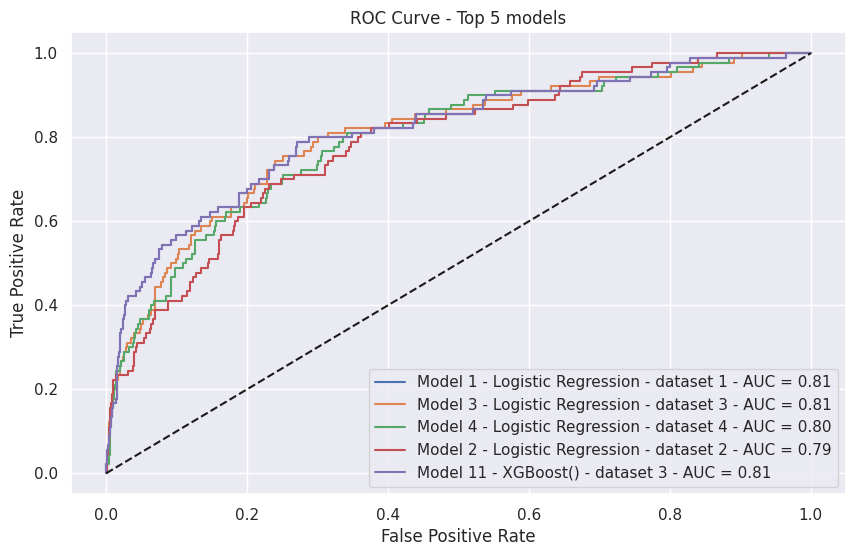

In [331]:
plt.figure(figsize=(10, 6))

for model, model_name, X_testing, y_testing in zip(models, model_names, X_test_data_end, y_test_data_end):
    try:
        predictions_proba = model.predict_proba(X_testing)
        fpr, tpr, _ = roc_curve(y_testing, predictions_proba[:, 1])
        auc_score = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} - AUC = {auc_score:.2f}')
    except Exception as e:
        print(f"An error occurred for model {model_name}: {str(e)}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Top 5 models')
plt.legend()
plt.show()